Required imports

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch.nn as nn
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm
from numpy import vstack
from numpy import argmax

from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, median_absolute_error, r2_score
from scipy.stats import median_absolute_deviation



Data overview

In [2]:
data_pd = pd.read_hdf("SP500_Options_Monthly.h5")

In [3]:
data_pd

,optid,date,secid,cp_flag,strike,bid,ask,volume,openint,impvol,...,vix,dhedged_return_mid,dhedged_return_spot,dhedged_return_spot_gamma,dhedged_return_mid_delev,dhedged_return_spot_delev,dhedged_return_spot_gamma_delev,IV_mness_deriv_1,IV_ttm_deriv_1,short_rate
0,10003234,1996-12-20,108105,P,825.0,79.750,80.750,4.0,4.0,0.163276,...,18.85,0.004046,0.000434,0.191613,0.000882,9.452300e-05,0.041769,NaN,NaN,0.052017
1,10003234,1997-01-17,108105,P,825.0,62.250,64.250,5.0,119.0,0.166865,...,18.63,0.056713,0.004622,2.198635,0.011167,9.099802e-04,0.432912,-0.030072,0.000032,0.054244
2,10003234,1997-02-21,108105,P,825.0,56.625,58.625,17.0,94.0,0.176886,...,20.55,-0.029893,-0.002148,-1.116086,-0.005773,-4.149493e-04,-0.215558,-0.036234,0.000013,0.054835
3,10003234,1997-03-21,108105,P,825.0,62.375,64.375,0.0,1238.0,0.182198,...,19.69,-0.081126,-0.006557,-3.291678,-0.016392,-1.324868e-03,-0.665094,-0.034897,0.000010,0.060077
4,10003234,1997-04-18,108105,P,825.0,64.875,66.875,300.0,1250.0,0.175205,...,18.75,0.092304,0.007934,3.583767,0.018166,1.561578e-03,0.705320,-0.028753,0.000017,0.056968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180809,117577568,2017-10-20,108105,P,2695.0,121.300,127.100,0.0,19.0,0.125499,...,9.97,-0.078302,-0.003776,-2.001284,-0.004168,-2.010069e-04,-0.106522,0.037274,0.000060,0.012243
180810,117595317,2017-10-20,108105,C,2735.0,0.150,0.300,0.0,162.0,0.095167,...,9.97,-0.955706,-0.000084,-0.208233,-0.008319,-7.268758e-07,-0.001813,0.004745,0.000174,0.012243
180811,117601432,2017-10-20,108105,C,2665.0,2.450,2.700,39.0,143.0,0.065220,...,9.97,-0.365931,-0.000366,-0.151199,-0.004222,-4.221724e-06,-0.001745,0.002268,0.000167,0.012243
180812,117646963,2017-10-20,108105,C,2770.0,0.550,0.700,0.0,10.0,0.090533,...,9.97,-0.553955,-0.000134,-0.261057,-0.007028,-1.705668e-06,-0.003312,0.002268,0.000167,0.012243


In [4]:
features = ['mness', 'ttm', 'embed_lev', 'impvol', 'gamma', 'vega', 'theta', 'strike', 'delta', 'spot_close'
                   , 'divrate', 'vix', 'short_rate', 'midprice', 'date']

In [5]:
put_df = data_pd[data_pd['cp_flag'] == 'P'][features]
call_df = data_pd[data_pd['cp_flag'] == 'C'][features]
put_df

,mness,ttm,embed_lev,impvol,gamma,vega,theta,strike,delta,spot_close,divrate,vix,short_rate,midprice,date
0,0.493527,728,4.587453,0.163276,0.002263,392.61790,2.388857,825.0,-0.499509,748.87,0.021764,18.85,0.052017,80.250,1996-12-20
1,0.264026,700,5.078717,0.166865,0.002102,404.58860,-1.370254,825.0,-0.413864,776.17,0.022156,18.63,0.054244,63.250,1997-01-17
2,0.119626,665,5.177660,0.176886,0.001925,398.23850,-4.685850,825.0,-0.372130,801.77,0.022782,20.55,0.054835,57.625,1997-02-21
3,0.211250,637,4.949190,0.182198,0.001992,388.80880,-3.081652,825.0,-0.400019,784.10,0.023084,19.69,0.060077,63.375,1997-03-21
4,0.325910,609,5.081052,0.175205,0.002214,379.39500,-0.389018,825.0,-0.436770,766.34,0.023036,18.75,0.056968,65.875,1997-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180803,-0.625458,56,39.826654,0.104692,0.003099,324.23790,-114.568500,2510.0,-0.260592,2575.21,0.018232,9.97,0.012243,16.850,2017-10-20
180804,-0.467571,56,40.341208,0.096709,0.003673,354.91720,-116.236200,2530.0,-0.315654,2575.21,0.018232,9.97,0.012243,20.150,2017-10-20
180805,0.255425,56,36.660494,0.076517,0.005031,384.66660,-102.074900,2595.0,-0.600756,2575.21,0.018232,9.97,0.012243,42.200,2017-10-20
180809,1.308051,28,18.787525,0.125499,0.001887,116.19330,-106.506800,2695.0,-0.906105,2575.21,0.018232,9.97,0.012243,124.200,2017-10-20


Forming dataset with additional features (differeting between call and put options, required for task 8).

In [6]:
put_plus = put_df
call_plus = call_df
for c in put_df.columns:
    if c!='midprice' and c != 'date':
        call_plus[c+"_additional"] = np.zeros(len(call_plus[c]))
        put_plus[c+"_additional"] = put_df[c]
put_plus

,mness,ttm,embed_lev,impvol,gamma,vega,theta,strike,delta,spot_close,...,impvol_additional,gamma_additional,vega_additional,theta_additional,strike_additional,delta_additional,spot_close_additional,divrate_additional,vix_additional,short_rate_additional
0,0.493527,728,4.587453,0.163276,0.002263,392.61790,2.388857,825.0,-0.499509,748.87,...,0.163276,0.002263,392.61790,2.388857,825.0,-0.499509,748.87,0.021764,18.85,0.052017
1,0.264026,700,5.078717,0.166865,0.002102,404.58860,-1.370254,825.0,-0.413864,776.17,...,0.166865,0.002102,404.58860,-1.370254,825.0,-0.413864,776.17,0.022156,18.63,0.054244
2,0.119626,665,5.177660,0.176886,0.001925,398.23850,-4.685850,825.0,-0.372130,801.77,...,0.176886,0.001925,398.23850,-4.685850,825.0,-0.372130,801.77,0.022782,20.55,0.054835
3,0.211250,637,4.949190,0.182198,0.001992,388.80880,-3.081652,825.0,-0.400019,784.10,...,0.182198,0.001992,388.80880,-3.081652,825.0,-0.400019,784.10,0.023084,19.69,0.060077
4,0.325910,609,5.081052,0.175205,0.002214,379.39500,-0.389018,825.0,-0.436770,766.34,...,0.175205,0.002214,379.39500,-0.389018,825.0,-0.436770,766.34,0.023036,18.75,0.056968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180803,-0.625458,56,39.826654,0.104692,0.003099,324.23790,-114.568500,2510.0,-0.260592,2575.21,...,0.104692,0.003099,324.23790,-114.568500,2510.0,-0.260592,2575.21,0.018232,9.97,0.012243
180804,-0.467571,56,40.341208,0.096709,0.003673,354.91720,-116.236200,2530.0,-0.315654,2575.21,...,0.096709,0.003673,354.91720,-116.236200,2530.0,-0.315654,2575.21,0.018232,9.97,0.012243
180805,0.255425,56,36.660494,0.076517,0.005031,384.66660,-102.074900,2595.0,-0.600756,2575.21,...,0.076517,0.005031,384.66660,-102.074900,2595.0,-0.600756,2575.21,0.018232,9.97,0.012243
180809,1.308051,28,18.787525,0.125499,0.001887,116.19330,-106.506800,2695.0,-0.906105,2575.21,...,0.125499,0.001887,116.19330,-106.506800,2695.0,-0.906105,2575.21,0.018232,9.97,0.012243


In [7]:
call_plus

,mness,ttm,embed_lev,impvol,gamma,vega,theta,strike,delta,spot_close,...,impvol_additional,gamma_additional,vega_additional,theta_additional,strike_additional,delta_additional,spot_close_additional,divrate_additional,vix_additional,short_rate_additional
42,1.857294,28,55.633217,0.169906,0.002070,16.72431,-20.102380,875.0,0.034694,801.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.488979,56,30.652784,0.132271,0.011247,92.88889,-52.013510,685.0,0.355372,666.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,1.874161,28,70.045687,0.134731,0.003244,13.18954,-12.747660,685.0,0.034270,638.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,2.210994,119,29.281115,0.166849,0.000412,39.72491,-11.555700,1650.0,0.021907,1336.61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,2.612415,91,38.801964,0.162164,0.000187,13.34660,-4.829397,1650.0,0.007264,1335.42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180807,2.417067,35,115.343944,0.087773,0.000288,14.71647,-6.823027,2670.0,0.006920,2500.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180808,1.998424,28,133.106167,0.075428,0.000942,34.87271,-17.557830,2685.0,0.020675,2575.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180810,2.283916,28,114.877257,0.095167,0.000401,18.72413,-11.936470,2735.0,0.010037,2575.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180811,1.341601,56,86.671068,0.065220,0.002420,157.72820,-33.382420,2665.0,0.086664,2575.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
total_df = pd.concat([call_plus, put_plus], axis=0)
total_df.sort_values(by='date')
total_df = total_df.reset_index()
total_df.to_csv("total_df.csv", index=False)

In [9]:
min(data_pd['midprice']), max(data_pd['midprice']), np.mean(data_pd['midprice'])

(0.025, 2212.45, 79.14769801287973)

Defining required classes

In [58]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

#         self.layer0 = nn.Linear(13, 20)
#         self.layer1 = nn.Linear(20, 32)
#         self.layer2 = nn.Linear(32, 16)
        self.out = nn.Linear(13, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
#         x = self.layer0(x)
#         x = self.act(x)
#         x = self.layer1(x)
#         x = self.act(x)
#         x = self.layer2(x)
        x = self.act(x)
        x = self.out(x)
        return x



In [88]:

# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=3, verbose=False, delta=0.001, path='checkpoint.pt', trace_func=print):

        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score >= self.best_score - self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        elif score < self.best_score - self.delta:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.8f} --> {val_loss:.8f}).  Saving model ...\n', val_loss - self.val_loss_min)
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [104]:


class Config:

    def __init__(self):

        # related to data
        self.path_to_dataset =  "SP500_Options_Monthly.h5"

        # related to model
        self.num_epochs = 5
        
        self.device = torch.device("cpu")
#         self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#         self.criterion = nn.L1Loss()
        self.criterion = nn.MSELoss()

    def path(self, fold, extended=False):
        if extended:
            return "DNN/model_extended/fold" + str(fold)
        return  "DNN/model/fold_" + str(fold)

class OptionsDataset(Dataset):

    # load the dataset
    def __init__(self, path, features, csv=False):

        # load the csv file as a dataframe
        if csv:
            df = total_df.sort_values(by='date')
#             print(df.head())
        else:
            df = pd.read_hdf(path).sort_values(by='date')
        df = df.reset_index()
#         df = df[df['midprice']<1000]
        
        self.df = df 
        # store the inputs and outputs
        self.X = df[features].to_numpy()
        self.y = pd.DataFrame({'response': df['midprice']}).to_numpy()

        self.X = torch.tensor(self.X)
        self.y = torch.tensor(self.y)

        # convert to needed further types
        self.X = self.X.long()
        self.y = self.y.to(torch.float64)

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    def get_splits(self, fold):
        train_pc = 0.85

        date = "2007-01-"
        if fold == 1:
            date = "2012-01-"
        elif fold == 2:
            date = "2017-01-"

        series = self.df.date.apply(lambda x: str(x)).str.startswith(date)
        frame = {f"is_January_{date[:5]}": series}
        df = pd.DataFrame(frame)
        january_df = df.loc[df[f'is_January_{date[:5]}']==True]

        last_date_ind = int(list(january_df.index)[-1])
        
        train = [i for i in range(0, int(last_date_ind * train_pc))]
        test = [i for i in range(int(last_date_ind * train_pc), last_date_ind + 1)]

        return (train, test)



Defining required helping functions

In [96]:
from sklearn.metrics import mean_squared_error, r2_score
def run_train_epoch(cfg, model, train_dl, criterion, optimizer):

    avg_loss = 0

    for i, (inputs, targets) in tqdm(enumerate(train_dl)):
        
        inputs = inputs.to(torch.float32)

        targets = targets.to(torch.float32)
#         print(inputs)
        
        inputs = inputs.to(cfg.device)
        targets = targets.to(cfg.device)

        # clear the gradients
        optimizer.zero_grad()

        # compute the model output
        yhat = model(inputs)

        # calculate loss
        loss = criterion(yhat, targets)

        avg_loss += loss

        # credit assignment
        loss.backward()

        # update model weights
        optimizer.step()
    
#     print(torch.isnan(targets))

    avg_loss = avg_loss / len(train_dl.dataset)
    

    return  avg_loss

def run_validation_epoch(cfg, model, test_dl, criterion, return_results=False):

    results = list()

    predictions, actuals = list(), list()

    loss = 0
    d_y = test_dl.dataset.dataset.y

    for i, (inputs, targets) in tqdm(enumerate(test_dl)):

        inputs = inputs.to(torch.float)
        
        targets = targets.to(torch.float)
        targets = targets.to(cfg.device)
        inputs = inputs.to(cfg.device)

        yhat = model(inputs)

        loss += criterion(yhat, targets)

        # retrieve numpy array
        yhat = yhat.detach().cpu().numpy()

        yhat = np.asarray(yhat)
        actual = targets.detach().cpu().numpy()

        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(actual), 1))
        
        if return_results:
            for predicted_value, actual_value in zip(yhat, actual):
                results.append(
                    [float(actual_value), float(predicted_value)])

        
        # storing
        predictions.append(yhat)
        actuals.append(actual)
        
    if return_results:
        summary_df = pd.DataFrame(results, columns=["label", "predicted"])
        return summary_df, loss / len(test_dl.dataset)
    
    loss = loss / len(test_dl.dataset)
    return loss

def train_for_a_fold(cfg, fold, dataset, extended=False):

    PATH_TO_SAVE = cfg.path(fold, extended= extended)
    if extended:
        model = NeuralNetExtended()
    else:
        model = NeuralNet()
    model.to(cfg.device)

    criterion = cfg.criterion

    optimizer = SGD(model.parameters(), lr=0.05)

    stopper = EarlyStopping(patience=10, verbose=True, path = PATH_TO_SAVE + '/fold' + str(fold) + '_regression.pth')

    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

    indices_train, indices_test = dataset.get_splits(fold)
    
    train_dl = DataLoader(Subset(dataset, indices_train), batch_size=1024)
    test_dl = DataLoader(Subset(dataset, indices_test), batch_size=1024)

    for epoch in range(cfg.num_epochs):

        print("EPOCH:", epoch)
        train_loss = run_train_epoch(cfg, model, train_dl, criterion, optimizer)
        test_loss = run_validation_epoch(cfg, model, test_dl, criterion)

        stopper(test_loss, model)

        message = 'epoch {:d}/{:d}, train {} {:.4f}, \n Test {} {:.4f}, best test {} {:.4f}'.format(
                  epoch + 1, cfg.num_epochs, 'MSE', train_loss,
                  'MSE', test_loss,
                  'MSE', stopper.best_score)

        print(message)

        scheduler.step()

        if stopper.early_stop:
            break

    print("Model saved at " + stopper.path)
    
def get_test(df, fold):
        start_date = "2007-01-"
        end_date = "2012-01-"
        if fold == 1:
            start_date = "2012-01-"
            end_date = "2017-01-"
        elif fold == 2:
            start_date = "2017-01-"
            end_date = "2017-10-"

        start_series = df.date.apply(lambda x: str(x)).str.startswith(start_date)
        end_series = df.date.apply(lambda x: str(x)).str.startswith(end_date)
    
        start_frame = {f"is_January_{start_date[:5]}": start_series}
        end_frame = {f"is_January_{end_date[:5]}": end_series}

        start_df = pd.DataFrame(start_frame)
        end_df = pd.DataFrame(end_frame)

        january_df = start_df.loc[start_df[f'is_January_{start_date[:5]}']==True]
        df_five_years_end = end_df.loc[end_df[f'is_January_{end_date[:5]}']==True]

        start_date_ind = int(list(january_df.index)[-1])
        end_date_ind = int(list(df_five_years_end.index)[-1])
        
        test = [i for i in range(start_date_ind, end_date_ind + 1)]

        return test
    
    
def test_for_a_fold(cfg, fold, dataset, extended = False):
    
    
    indices = get_test(data_pd, fold)
    test_dl = DataLoader(Subset(dataset, indices), batch_size=256)
    if extended:
        model = NeuralNetExtended()
        model.load_state_dict(torch.load(cfg.path(fold, extended=extended)+'/fold' + str(fold) + '_regression.pth'))
    else:
        model = NeuralNet()
        model.load_state_dict(torch.load(cfg.path(fold)+'/fold' + str(fold) + '_regression.pth'))
        
    criterion = nn.MSELoss()
    df, mse = run_validation_epoch(cfg, model, test_dl, criterion, True)
    df.to_csv(cfg.path(fold, extended=extended)+'/preds.csv', index=False)
    return df

Training for 3 folds without differetiating on call and put.

In [77]:
cfg = Config()
cfg.num_epochs = 50
features = ['mness', 'ttm', 'embed_lev', 'impvol', 'gamma', 'vega', 'theta', 'strike', 'delta', 'spot_close'
                   , 'divrate', 'vix', 'short_rate']

dataset = OptionsDataset(cfg.path_to_dataset, features = features)

Fold 0


446it [00:00, 2125.11it/s]

EPOCH: 0


1273it [00:00, 2559.61it/s]
8it [00:00, 215.63it/s]
240it [00:00, 2399.04it/s]

Validation loss decreased (inf --> 3.92010975).  Saving model ...
 tensor(-inf, grad_fn=<SubBackward0>)
epoch 1/50, train MSE 302.2769, 
 Test MSE 3.9201, best test MSE 3.9201
EPOCH: 1


1273it [00:00, 2649.36it/s]
8it [00:00, 187.47it/s]
224it [00:00, 2234.62it/s]

Validation loss decreased (3.92010975 --> 3.32183194).  Saving model ...
 tensor(-0.5983, grad_fn=<SubBackward0>)
epoch 2/50, train MSE 229.6878, 
 Test MSE 3.3218, best test MSE 3.3218
EPOCH: 2


1273it [00:00, 2557.58it/s]
8it [00:00, 237.08it/s]
551it [00:00, 2704.26it/s]

Validation loss decreased (3.32183194 --> 2.93801641).  Saving model ...
 tensor(-0.3838, grad_fn=<SubBackward0>)
epoch 3/50, train MSE 187.2309, 
 Test MSE 2.9380, best test MSE 2.9380
EPOCH: 3


1273it [00:00, 2816.69it/s]
8it [00:00, 243.83it/s]
255it [00:00, 2542.81it/s]

Validation loss decreased (2.93801641 --> 2.67990136).  Saving model ...
 tensor(-0.2581, grad_fn=<SubBackward0>)
epoch 4/50, train MSE 162.4184, 
 Test MSE 2.6799, best test MSE 2.6799
EPOCH: 4


1273it [00:00, 2617.24it/s]
8it [00:00, 240.32it/s]
278it [00:00, 2770.98it/s]

Validation loss decreased (2.67990136 --> 2.50013804).  Saving model ...
 tensor(-0.1798, grad_fn=<SubBackward0>)
epoch 5/50, train MSE 147.7685, 
 Test MSE 2.5001, best test MSE 2.5001
EPOCH: 5


1273it [00:00, 2703.01it/s]
8it [00:00, 246.69it/s]
268it [00:00, 2673.10it/s]

Validation loss decreased (2.50013804 --> 2.37205195).  Saving model ...
 tensor(-0.1281, grad_fn=<SubBackward0>)
epoch 6/50, train MSE 139.0406, 
 Test MSE 2.3721, best test MSE 2.3721
EPOCH: 6


1273it [00:00, 2773.55it/s]
8it [00:00, 246.18it/s]
561it [00:00, 2782.32it/s]

Validation loss decreased (2.37205195 --> 2.27942228).  Saving model ...
 tensor(-0.0926, grad_fn=<SubBackward0>)
epoch 7/50, train MSE 133.8005, 
 Test MSE 2.2794, best test MSE 2.2794
EPOCH: 7


1273it [00:00, 2821.38it/s]
8it [00:00, 254.40it/s]
222it [00:00, 2212.55it/s]

Validation loss decreased (2.27942228 --> 2.21177173).  Saving model ...
 tensor(-0.0677, grad_fn=<SubBackward0>)
epoch 8/50, train MSE 130.6331, 
 Test MSE 2.2118, best test MSE 2.2118
EPOCH: 8


1273it [00:00, 2090.20it/s]
8it [00:00, 193.04it/s]
232it [00:00, 2315.76it/s]

Validation loss decreased (2.21177173 --> 2.16199827).  Saving model ...
 tensor(-0.0498, grad_fn=<SubBackward0>)
epoch 9/50, train MSE 128.7072, 
 Test MSE 2.1620, best test MSE 2.1620
EPOCH: 9


1273it [00:00, 2517.59it/s]
8it [00:00, 62.40it/s]
216it [00:00, 2152.85it/s]

Validation loss decreased (2.16199827 --> 2.12513900).  Saving model ...
 tensor(-0.0369, grad_fn=<SubBackward0>)
epoch 10/50, train MSE 127.5299, 
 Test MSE 2.1251, best test MSE 2.1251
EPOCH: 10


1273it [00:00, 2405.33it/s]
8it [00:00, 185.49it/s]
227it [00:00, 2268.77it/s]

Validation loss decreased (2.12513900 --> 2.06743622).  Saving model ...
 tensor(-0.0577, grad_fn=<SubBackward0>)
epoch 11/50, train MSE 118.5184, 
 Test MSE 2.0674, best test MSE 2.0674
EPOCH: 11


1273it [00:00, 2450.97it/s]
8it [00:00, 179.11it/s]
258it [00:00, 2577.63it/s]

Validation loss decreased (2.06743622 --> 2.05109596).  Saving model ...
 tensor(-0.0163, grad_fn=<SubBackward0>)
epoch 12/50, train MSE 118.1097, 
 Test MSE 2.0511, best test MSE 2.0511
EPOCH: 12


1273it [00:00, 2782.31it/s]
8it [00:00, 201.49it/s]
227it [00:00, 2264.77it/s]

Validation loss decreased (2.05109596 --> 2.03855491).  Saving model ...
 tensor(-0.0125, grad_fn=<SubBackward0>)
epoch 13/50, train MSE 117.8637, 
 Test MSE 2.0386, best test MSE 2.0386
EPOCH: 13


1273it [00:00, 2655.57it/s]
8it [00:00, 231.99it/s]
261it [00:00, 2608.14it/s]

Validation loss decreased (2.03855491 --> 2.02887201).  Saving model ...
 tensor(-0.0097, grad_fn=<SubBackward0>)
epoch 14/50, train MSE 117.7038, 
 Test MSE 2.0289, best test MSE 2.0289
EPOCH: 14


1273it [00:00, 2685.90it/s]
8it [00:00, 229.61it/s]
264it [00:00, 2634.36it/s]

Validation loss decreased (2.02887201 --> 2.02135921).  Saving model ...
 tensor(-0.0075, grad_fn=<SubBackward0>)
epoch 15/50, train MSE 117.5987, 
 Test MSE 2.0214, best test MSE 2.0214
EPOCH: 15


1273it [00:00, 2785.95it/s]
8it [00:00, 184.70it/s]
215it [00:00, 2148.47it/s]

Validation loss decreased (2.02135921 --> 2.01549864).  Saving model ...
 tensor(-0.0059, grad_fn=<SubBackward0>)
epoch 16/50, train MSE 117.5287, 
 Test MSE 2.0155, best test MSE 2.0155
EPOCH: 16


1273it [00:00, 2545.53it/s]
8it [00:00, 237.35it/s]
240it [00:00, 2391.30it/s]

Validation loss decreased (2.01549864 --> 2.01090312).  Saving model ...
 tensor(-0.0046, grad_fn=<SubBackward0>)
epoch 17/50, train MSE 117.4816, 
 Test MSE 2.0109, best test MSE 2.0109
EPOCH: 17


1273it [00:00, 2554.39it/s]
8it [00:00, 238.09it/s]
533it [00:00, 2648.53it/s]

Validation loss decreased (2.01090312 --> 2.00728226).  Saving model ...
 tensor(-0.0036, grad_fn=<SubBackward0>)
epoch 18/50, train MSE 117.4490, 
 Test MSE 2.0073, best test MSE 2.0073
EPOCH: 18


1273it [00:00, 2736.90it/s]
8it [00:00, 233.64it/s]
273it [00:00, 2728.91it/s]

Validation loss decreased (2.00728226 --> 2.00441456).  Saving model ...
 tensor(-0.0029, grad_fn=<SubBackward0>)
epoch 19/50, train MSE 117.4258, 
 Test MSE 2.0044, best test MSE 2.0044
EPOCH: 19


1273it [00:00, 2774.44it/s]
8it [00:00, 73.59it/s]
240it [00:00, 2391.47it/s]

Validation loss decreased (2.00441456 --> 2.00213885).  Saving model ...
 tensor(-0.0023, grad_fn=<SubBackward0>)
epoch 20/50, train MSE 117.4088, 
 Test MSE 2.0021, best test MSE 2.0021
EPOCH: 20


1273it [00:00, 2740.96it/s]
8it [00:00, 241.82it/s]
269it [00:00, 2684.01it/s]

Validation loss decreased (2.00213885 --> 1.99359429).  Saving model ...
 tensor(-0.0085, grad_fn=<SubBackward0>)
epoch 21/50, train MSE 113.9153, 
 Test MSE 1.9936, best test MSE 1.9936
EPOCH: 21


1273it [00:00, 2803.11it/s]
8it [00:00, 239.11it/s]
263it [00:00, 2628.19it/s]

EarlyStopping counter: 1 out of 10
epoch 22/50, train MSE 113.8787, 
 Test MSE 1.9926, best test MSE 1.9936
EPOCH: 22


1273it [00:00, 2770.96it/s]
8it [00:00, 253.07it/s]
269it [00:00, 2683.99it/s]

Validation loss decreased (1.99359429 --> 1.99186158).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 23/50, train MSE 113.8714, 
 Test MSE 1.9919, best test MSE 1.9919
EPOCH: 23


1273it [00:00, 2753.50it/s]
8it [00:00, 189.14it/s]
214it [00:00, 2134.86it/s]

EarlyStopping counter: 1 out of 10
epoch 24/50, train MSE 113.8646, 
 Test MSE 1.9912, best test MSE 1.9919
EPOCH: 24


1273it [00:00, 2676.09it/s]
8it [00:00, 238.54it/s]
267it [00:00, 2665.36it/s]

Validation loss decreased (1.99186158 --> 1.99068141).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 25/50, train MSE 113.8588, 
 Test MSE 1.9907, best test MSE 1.9907
EPOCH: 25


1273it [00:00, 2758.37it/s]
8it [00:00, 223.38it/s]
257it [00:00, 2569.95it/s]

EarlyStopping counter: 1 out of 10
epoch 26/50, train MSE 113.8536, 
 Test MSE 1.9902, best test MSE 1.9907
EPOCH: 26


1273it [00:00, 2780.30it/s]
8it [00:00, 236.83it/s]
270it [00:00, 2692.78it/s]

EarlyStopping counter: 2 out of 10
epoch 27/50, train MSE 113.8486, 
 Test MSE 1.9899, best test MSE 1.9907
EPOCH: 27


1273it [00:00, 2816.15it/s]
8it [00:00, 214.50it/s]
250it [00:00, 2495.17it/s]

Validation loss decreased (1.99068141 --> 1.98955607).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 28/50, train MSE 113.8439, 
 Test MSE 1.9896, best test MSE 1.9896
EPOCH: 28


1273it [00:00, 2705.91it/s]
8it [00:00, 68.86it/s]
422it [00:00, 2049.83it/s]

EarlyStopping counter: 1 out of 10
epoch 29/50, train MSE 113.8394, 
 Test MSE 1.9893, best test MSE 1.9896
EPOCH: 29


1273it [00:00, 2281.24it/s]
8it [00:00, 214.08it/s]
211it [00:00, 2104.94it/s]

EarlyStopping counter: 2 out of 10
epoch 30/50, train MSE 113.8353, 
 Test MSE 1.9891, best test MSE 1.9896
EPOCH: 30


1273it [00:00, 2288.28it/s]
8it [00:00, 178.86it/s]
218it [00:00, 2171.42it/s]

EarlyStopping counter: 3 out of 10
epoch 31/50, train MSE 111.9782, 
 Test MSE 1.9908, best test MSE 1.9896
EPOCH: 31


1273it [00:00, 2296.23it/s]
8it [00:00, 240.47it/s]
545it [00:00, 2682.07it/s]

EarlyStopping counter: 4 out of 10
epoch 32/50, train MSE 111.9468, 
 Test MSE 1.9909, best test MSE 1.9896
EPOCH: 32


1273it [00:00, 2756.05it/s]
8it [00:00, 205.97it/s]
229it [00:00, 2288.40it/s]

EarlyStopping counter: 5 out of 10
epoch 33/50, train MSE 111.9433, 
 Test MSE 1.9909, best test MSE 1.9896
EPOCH: 33


1273it [00:00, 2632.91it/s]
8it [00:00, 242.24it/s]
549it [00:00, 2686.65it/s]

EarlyStopping counter: 6 out of 10
epoch 34/50, train MSE 111.9398, 
 Test MSE 1.9909, best test MSE 1.9896
EPOCH: 34


1273it [00:00, 2770.79it/s]
8it [00:00, 221.65it/s]
258it [00:00, 2575.03it/s]

EarlyStopping counter: 7 out of 10
epoch 35/50, train MSE 111.9367, 
 Test MSE 1.9909, best test MSE 1.9896
EPOCH: 35


1273it [00:00, 2779.16it/s]
8it [00:00, 258.76it/s]
269it [00:00, 2689.92it/s]

EarlyStopping counter: 8 out of 10
epoch 36/50, train MSE 111.9337, 
 Test MSE 1.9909, best test MSE 1.9896
EPOCH: 36


1273it [00:00, 2757.29it/s]
8it [00:00, 234.59it/s]
554it [00:00, 2733.10it/s]

EarlyStopping counter: 9 out of 10
epoch 37/50, train MSE 111.9310, 
 Test MSE 1.9909, best test MSE 1.9896
EPOCH: 37


1273it [00:00, 2828.22it/s]
8it [00:00, 72.97it/s]


EarlyStopping counter: 10 out of 10
epoch 38/50, train MSE 111.9284, 
 Test MSE 1.9909, best test MSE 1.9896
Model saved at DNN/model/fold_0/fold0_regression.pth


25it [00:00, 709.14it/s]


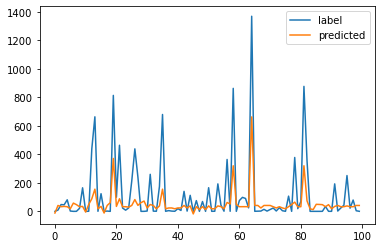

Fold 1


579it [00:00, 2898.40it/s]

EPOCH: 0


2530it [00:00, 2895.77it/s]
14it [00:00, 214.04it/s]
251it [00:00, 2501.64it/s]

Validation loss decreased (inf --> 13.73996544).  Saving model ...
 tensor(-inf, grad_fn=<SubBackward0>)
epoch 1/50, train MSE 311.3329, 
 Test MSE 13.7400, best test MSE 13.7400
EPOCH: 1


2530it [00:00, 2817.35it/s]
14it [00:00, 98.55it/s]
237it [00:00, 2368.44it/s]

Validation loss decreased (13.73996544 --> 9.50659180).  Saving model ...
 tensor(-4.2334, grad_fn=<SubBackward0>)
epoch 2/50, train MSE 173.3158, 
 Test MSE 9.5066, best test MSE 9.5066
EPOCH: 2


2530it [00:00, 2775.58it/s]
14it [00:00, 160.95it/s]
206it [00:00, 2052.12it/s]

Validation loss decreased (9.50659180 --> 8.31564522).  Saving model ...
 tensor(-1.1909, grad_fn=<SubBackward0>)
epoch 3/50, train MSE 155.1150, 
 Test MSE 8.3156, best test MSE 8.3156
EPOCH: 3


2530it [00:01, 2421.68it/s]
14it [00:00, 213.98it/s]
273it [00:00, 2720.86it/s]

Validation loss decreased (8.31564522 --> 7.92533064).  Saving model ...
 tensor(-0.3903, grad_fn=<SubBackward0>)
epoch 4/50, train MSE 152.5172, 
 Test MSE 7.9253, best test MSE 7.9253
EPOCH: 4


2530it [00:00, 2668.84it/s]
14it [00:00, 207.95it/s]
232it [00:00, 2311.20it/s]

Validation loss decreased (7.92533064 --> 7.78575993).  Saving model ...
 tensor(-0.1396, grad_fn=<SubBackward0>)
epoch 5/50, train MSE 152.1381, 
 Test MSE 7.7858, best test MSE 7.7858
EPOCH: 5


2530it [00:01, 2175.44it/s]
14it [00:00, 165.58it/s]
212it [00:00, 2118.59it/s]

Validation loss decreased (7.78575993 --> 7.73372364).  Saving model ...
 tensor(-0.0520, grad_fn=<SubBackward0>)
epoch 6/50, train MSE 152.0811, 
 Test MSE 7.7337, best test MSE 7.7337
EPOCH: 6


2530it [00:01, 2427.05it/s]
14it [00:00, 97.20it/s]
459it [00:00, 2263.35it/s]

Validation loss decreased (7.73372364 --> 7.71416521).  Saving model ...
 tensor(-0.0196, grad_fn=<SubBackward0>)
epoch 7/50, train MSE 152.0684, 
 Test MSE 7.7142, best test MSE 7.7142
EPOCH: 7


2530it [00:01, 2432.92it/s]
14it [00:00, 171.55it/s]
231it [00:00, 2308.84it/s]

Validation loss decreased (7.71416521 --> 7.70702505).  Saving model ...
 tensor(-0.0071, grad_fn=<SubBackward0>)
epoch 8/50, train MSE 152.0609, 
 Test MSE 7.7070, best test MSE 7.7070
EPOCH: 8


2530it [00:00, 2556.77it/s]
14it [00:00, 186.03it/s]
245it [00:00, 2448.53it/s]

Validation loss decreased (7.70702505 --> 7.70463181).  Saving model ...
 tensor(-0.0024, grad_fn=<SubBackward0>)
epoch 9/50, train MSE 152.0542, 
 Test MSE 7.7046, best test MSE 7.7046
EPOCH: 9


2530it [00:00, 2673.66it/s]
14it [00:00, 187.56it/s]
496it [00:00, 2429.83it/s]

EarlyStopping counter: 1 out of 10
epoch 10/50, train MSE 152.0477, 
 Test MSE 7.7041, best test MSE 7.7046
EPOCH: 10


2530it [00:00, 2593.20it/s]
14it [00:00, 197.47it/s]
562it [00:00, 2766.83it/s]

EarlyStopping counter: 2 out of 10
epoch 11/50, train MSE 142.5309, 
 Test MSE 7.7701, best test MSE 7.7046
EPOCH: 11


2530it [00:00, 2710.81it/s]
14it [00:00, 87.29it/s]
470it [00:00, 2286.69it/s]

EarlyStopping counter: 3 out of 10
epoch 12/50, train MSE 142.5224, 
 Test MSE 7.7737, best test MSE 7.7046
EPOCH: 12


2530it [00:01, 2453.60it/s]
14it [00:00, 170.36it/s]
248it [00:00, 2476.91it/s]

EarlyStopping counter: 4 out of 10
epoch 13/50, train MSE 142.5175, 
 Test MSE 7.7754, best test MSE 7.7046
EPOCH: 13


2530it [00:00, 2744.00it/s]
14it [00:00, 209.62it/s]
556it [00:00, 2757.83it/s]

EarlyStopping counter: 5 out of 10
epoch 14/50, train MSE 142.5128, 
 Test MSE 7.7764, best test MSE 7.7046
EPOCH: 14


2530it [00:00, 2713.62it/s]
14it [00:00, 171.69it/s]
232it [00:00, 2319.28it/s]

EarlyStopping counter: 6 out of 10
epoch 15/50, train MSE 142.5086, 
 Test MSE 7.7770, best test MSE 7.7046
EPOCH: 15


2530it [00:00, 2627.57it/s]
14it [00:00, 198.29it/s]
537it [00:00, 2670.00it/s]

EarlyStopping counter: 7 out of 10
epoch 16/50, train MSE 142.5049, 
 Test MSE 7.7775, best test MSE 7.7046
EPOCH: 16


2530it [00:00, 2673.91it/s]
14it [00:00, 96.40it/s]
545it [00:00, 2687.22it/s]

EarlyStopping counter: 8 out of 10
epoch 17/50, train MSE 142.5011, 
 Test MSE 7.7779, best test MSE 7.7046
EPOCH: 17


2530it [00:01, 2509.87it/s]
14it [00:00, 157.67it/s]
444it [00:00, 2192.11it/s]

EarlyStopping counter: 9 out of 10
epoch 18/50, train MSE 142.4979, 
 Test MSE 7.7782, best test MSE 7.7046
EPOCH: 18


2530it [00:01, 2353.26it/s]
14it [00:00, 154.02it/s]


EarlyStopping counter: 10 out of 10
epoch 19/50, train MSE 142.4947, 
 Test MSE 7.7785, best test MSE 7.7046
Model saved at DNN/model/fold_1/fold1_regression.pth


35it [00:00, 801.43it/s]


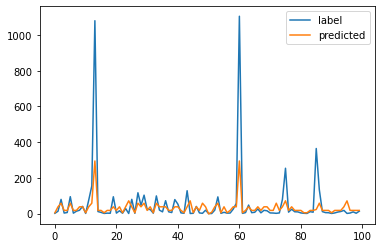

Fold 2


570it [00:00, 2891.82it/s]

EPOCH: 0


4481it [00:01, 2924.35it/s]
25it [00:00, 238.86it/s]
286it [00:00, 2847.07it/s]

Validation loss decreased (inf --> 15.77578259).  Saving model ...
 tensor(-inf, grad_fn=<SubBackward0>)
epoch 1/50, train MSE 333.9196, 
 Test MSE 15.7758, best test MSE 15.7758
EPOCH: 1


4481it [00:01, 2893.53it/s]
25it [00:00, 250.31it/s]
578it [00:00, 2852.80it/s]

Validation loss decreased (15.77578259 --> 13.60445309).  Saving model ...
 tensor(-2.1713, grad_fn=<SubBackward0>)
epoch 2/50, train MSE 212.9571, 
 Test MSE 13.6045, best test MSE 13.6045
EPOCH: 2


4481it [00:01, 2941.08it/s]
25it [00:00, 134.46it/s]
257it [00:00, 2562.21it/s]

Validation loss decreased (13.60445309 --> 13.17065334).  Saving model ...
 tensor(-0.4338, grad_fn=<SubBackward0>)
epoch 3/50, train MSE 211.8585, 
 Test MSE 13.1707, best test MSE 13.1707
EPOCH: 3


4481it [00:01, 2914.14it/s]
25it [00:00, 244.79it/s]
275it [00:00, 2749.01it/s]

Validation loss decreased (13.17065334 --> 13.07532406).  Saving model ...
 tensor(-0.0953, grad_fn=<SubBackward0>)
epoch 4/50, train MSE 212.9881, 
 Test MSE 13.0753, best test MSE 13.0753
EPOCH: 4


4481it [00:01, 2689.82it/s]
25it [00:00, 259.72it/s]
275it [00:00, 2745.34it/s]

Validation loss decreased (13.07532406 --> 13.05501080).  Saving model ...
 tensor(-0.0203, grad_fn=<SubBackward0>)
epoch 5/50, train MSE 213.3217, 
 Test MSE 13.0550, best test MSE 13.0550
EPOCH: 5


4481it [00:01, 2937.23it/s]
25it [00:00, 134.06it/s]
290it [00:00, 2891.97it/s]

Validation loss decreased (13.05501080 --> 13.05162716).  Saving model ...
 tensor(-0.0034, grad_fn=<SubBackward0>)
epoch 6/50, train MSE 213.4017, 
 Test MSE 13.0516, best test MSE 13.0516
EPOCH: 6


4481it [00:01, 2683.14it/s]
25it [00:00, 246.32it/s]
536it [00:00, 2700.67it/s]

EarlyStopping counter: 1 out of 10
epoch 7/50, train MSE 213.4196, 
 Test MSE 13.0518, best test MSE 13.0516
EPOCH: 7


4481it [00:01, 2893.01it/s]
25it [00:00, 222.65it/s]
555it [00:00, 2758.07it/s]

EarlyStopping counter: 2 out of 10
epoch 8/50, train MSE 213.4230, 
 Test MSE 13.0526, best test MSE 13.0516
EPOCH: 8


4481it [00:01, 2684.96it/s]
25it [00:00, 116.00it/s]
554it [00:00, 2760.94it/s]

EarlyStopping counter: 3 out of 10
epoch 9/50, train MSE 213.4237, 
 Test MSE 13.0533, best test MSE 13.0516
EPOCH: 9


4481it [00:01, 2821.61it/s]
25it [00:00, 239.65it/s]
278it [00:00, 2771.63it/s]

EarlyStopping counter: 4 out of 10
epoch 10/50, train MSE 213.4232, 
 Test MSE 13.0539, best test MSE 13.0516
EPOCH: 10


4481it [00:01, 2853.67it/s]
25it [00:00, 139.38it/s]
239it [00:00, 2383.96it/s]

EarlyStopping counter: 5 out of 10
epoch 11/50, train MSE 200.6416, 
 Test MSE 13.4198, best test MSE 13.0516
EPOCH: 11


4481it [00:01, 2838.76it/s]
25it [00:00, 235.27it/s]
281it [00:00, 2804.59it/s]

EarlyStopping counter: 6 out of 10
epoch 12/50, train MSE 200.2783, 
 Test MSE 13.4386, best test MSE 13.0516
EPOCH: 12


4481it [00:01, 2733.22it/s]
25it [00:00, 192.22it/s]
404it [00:00, 1833.06it/s]

EarlyStopping counter: 7 out of 10
epoch 13/50, train MSE 200.2157, 
 Test MSE 13.4434, best test MSE 13.0516
EPOCH: 13


4481it [00:01, 2744.24it/s]
25it [00:00, 111.19it/s]
249it [00:00, 2487.74it/s]

EarlyStopping counter: 8 out of 10
epoch 14/50, train MSE 200.1992, 
 Test MSE 13.4447, best test MSE 13.0516
EPOCH: 14


4481it [00:01, 2943.80it/s]
25it [00:00, 259.48it/s]
278it [00:00, 2772.24it/s]

EarlyStopping counter: 9 out of 10
epoch 15/50, train MSE 200.1944, 
 Test MSE 13.4451, best test MSE 13.0516
EPOCH: 15


4481it [00:01, 2823.84it/s]
25it [00:00, 240.31it/s]


EarlyStopping counter: 10 out of 10
epoch 16/50, train MSE 200.1928, 
 Test MSE 13.4453, best test MSE 13.0516
Model saved at DNN/model/fold_2/fold2_regression.pth


4it [00:00, 311.79it/s]


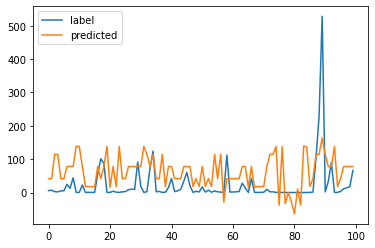

{0: [20479.696421989156, 0.5279579255827014],
 1: [11751.408045644424, 0.4346289276683716],
 2: [16670.27655080934, 0.612781599934153]}

In [64]:
metrics = {}
for fold in range(3):
    print("Fold", fold)
    train_for_a_fold(cfg, fold, dataset)
    df = test_for_a_fold(cfg, fold, dataset, extended = False)
    mse = mean_squared_error(df['label'], df['predicted'])
    r2 = r2_score(df['label'], df['predicted'])
    metrics[fold] = [mse, r2]
    df[:100].plot()
    plt.show()
    
metrics

In [ ]:
metrics

Adding features

In [100]:
class NeuralNetExtended(nn.Module):
    def __init__(self):
        super(NeuralNetExtended, self).__init__()

#         self.layer0 = nn.Linear(26, 20)
#         self.layer1 = nn.Linear(20, 32)
#         self.layer2 = nn.Linear(32, 16)
        self.out = nn.Linear(26, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
#         x = self.layer0(x)
#         x = self.act(x)
#         x = self.layer1(x)
#         x = self.act(x)
#         x = self.layer2(x)
        x = self.act(x)
        x = self.out(x)
        return x

In [105]:
cfg = Config()
cfg.num_epochs = 200
features_2 = []
for f in features:
    if f != 'midprice' and f != 'date':
        features_2.append(f)
        features_2.append(f+"_additional")
total_df.columns

Index(['index', 'mness', 'ttm', 'embed_lev', 'impvol', 'gamma', 'vega',
       'theta', 'strike', 'delta', 'spot_close', 'divrate', 'vix',
       'short_rate', 'midprice', 'date', 'mness_additional', 'ttm_additional',
       'embed_lev_additional', 'impvol_additional', 'gamma_additional',
       'vega_additional', 'theta_additional', 'strike_additional',
       'delta_additional', 'spot_close_additional', 'divrate_additional',
       'vix_additional', 'short_rate_additional'],
      dtype='object')

Fold 0


207it [00:00, 982.50it/s]

EPOCH: 0


319it [00:00, 1084.25it/s]
8it [00:00, 165.34it/s]
98it [00:00, 972.93it/s]

Validation loss decreased (inf --> 5.47754431).  Saving model ...
 tensor(-inf, grad_fn=<SubBackward0>)
epoch 1/200, train MSE 68.6039, 
 Test MSE 5.4775, best test MSE 5.4775
EPOCH: 1


319it [00:00, 1092.92it/s]
8it [00:00, 178.40it/s]
96it [00:00, 958.25it/s]

Validation loss decreased (5.47754431 --> 5.09531403).  Saving model ...
 tensor(-0.3822, grad_fn=<SubBackward0>)
epoch 2/200, train MSE 57.6226, 
 Test MSE 5.0953, best test MSE 5.0953
EPOCH: 2


319it [00:00, 1092.11it/s]
8it [00:00, 201.99it/s]
128it [00:00, 1279.13it/s]

Validation loss decreased (5.09531403 --> 4.53852272).  Saving model ...
 tensor(-0.5568, grad_fn=<SubBackward0>)
epoch 3/200, train MSE 50.3796, 
 Test MSE 4.5385, best test MSE 4.5385
EPOCH: 3


319it [00:00, 1360.60it/s]
8it [00:00, 219.49it/s]
132it [00:00, 1319.40it/s]

Validation loss decreased (4.53852272 --> 4.11217880).  Saving model ...
 tensor(-0.4263, grad_fn=<SubBackward0>)
epoch 4/200, train MSE 44.7501, 
 Test MSE 4.1122, best test MSE 4.1122
EPOCH: 4


319it [00:00, 1307.87it/s]
8it [00:00, 262.01it/s]
130it [00:00, 1296.15it/s]

Validation loss decreased (4.11217880 --> 3.78953648).  Saving model ...
 tensor(-0.3226, grad_fn=<SubBackward0>)
epoch 5/200, train MSE 40.4233, 
 Test MSE 3.7895, best test MSE 3.7895
EPOCH: 5


319it [00:00, 1328.88it/s]
8it [00:00, 224.38it/s]
275it [00:00, 1346.34it/s]

Validation loss decreased (3.78953648 --> 3.54027867).  Saving model ...
 tensor(-0.2493, grad_fn=<SubBackward0>)
epoch 6/200, train MSE 37.0561, 
 Test MSE 3.5403, best test MSE 3.5403
EPOCH: 6


319it [00:00, 1370.84it/s]
8it [00:00, 226.92it/s]
277it [00:00, 1353.20it/s]

Validation loss decreased (3.54027867 --> 3.34267163).  Saving model ...
 tensor(-0.1976, grad_fn=<SubBackward0>)
epoch 7/200, train MSE 34.3966, 
 Test MSE 3.3427, best test MSE 3.3427
EPOCH: 7


319it [00:00, 1367.93it/s]
8it [00:00, 223.98it/s]
115it [00:00, 1143.30it/s]

Validation loss decreased (3.34267163 --> 3.18159652).  Saving model ...
 tensor(-0.1611, grad_fn=<SubBackward0>)
epoch 8/200, train MSE 32.2633, 
 Test MSE 3.1816, best test MSE 3.1816
EPOCH: 8


319it [00:00, 1258.30it/s]
8it [00:00, 266.43it/s]
135it [00:00, 1341.23it/s]

Validation loss decreased (3.18159652 --> 3.04662442).  Saving model ...
 tensor(-0.1350, grad_fn=<SubBackward0>)
epoch 9/200, train MSE 30.5251, 
 Test MSE 3.0466, best test MSE 3.0466
EPOCH: 9


319it [00:00, 1282.47it/s]
8it [00:00, 266.93it/s]
274it [00:00, 1335.51it/s]

Validation loss decreased (3.04662442 --> 2.93058538).  Saving model ...
 tensor(-0.1160, grad_fn=<SubBackward0>)
epoch 10/200, train MSE 29.0869, 
 Test MSE 2.9306, best test MSE 2.9306
EPOCH: 10


319it [00:00, 1363.08it/s]
8it [00:00, 228.99it/s]
137it [00:00, 1369.82it/s]

Validation loss decreased (2.93058538 --> 2.80807281).  Saving model ...
 tensor(-0.1225, grad_fn=<SubBackward0>)
epoch 11/200, train MSE 27.9331, 
 Test MSE 2.8081, best test MSE 2.8081
EPOCH: 11


319it [00:00, 1375.80it/s]
8it [00:00, 67.19it/s]
122it [00:00, 1212.69it/s]

Validation loss decreased (2.80807281 --> 2.72590160).  Saving model ...
 tensor(-0.0822, grad_fn=<SubBackward0>)
epoch 12/200, train MSE 26.9733, 
 Test MSE 2.7259, best test MSE 2.7259
EPOCH: 12


319it [00:00, 1308.64it/s]
8it [00:00, 269.62it/s]
130it [00:00, 1295.52it/s]

Validation loss decreased (2.72590160 --> 2.65188789).  Saving model ...
 tensor(-0.0740, grad_fn=<SubBackward0>)
epoch 13/200, train MSE 26.1469, 
 Test MSE 2.6519, best test MSE 2.6519
EPOCH: 13


319it [00:00, 1371.52it/s]
8it [00:00, 219.02it/s]
132it [00:00, 1317.12it/s]

Validation loss decreased (2.65188789 --> 2.58345628).  Saving model ...
 tensor(-0.0684, grad_fn=<SubBackward0>)
epoch 14/200, train MSE 25.4207, 
 Test MSE 2.5835, best test MSE 2.5835
EPOCH: 14


319it [00:00, 1364.67it/s]
8it [00:00, 220.99it/s]
125it [00:00, 1249.75it/s]

Validation loss decreased (2.58345628 --> 2.51965213).  Saving model ...
 tensor(-0.0638, grad_fn=<SubBackward0>)
epoch 15/200, train MSE 24.7767, 
 Test MSE 2.5197, best test MSE 2.5197
EPOCH: 15


319it [00:00, 1304.58it/s]
8it [00:00, 224.41it/s]
129it [00:00, 1283.52it/s]

Validation loss decreased (2.51965213 --> 2.45987320).  Saving model ...
 tensor(-0.0598, grad_fn=<SubBackward0>)
epoch 16/200, train MSE 24.2016, 
 Test MSE 2.4599, best test MSE 2.4599
EPOCH: 16


319it [00:00, 1318.52it/s]
8it [00:00, 216.84it/s]
126it [00:00, 1256.63it/s]

Validation loss decreased (2.45987320 --> 2.40367222).  Saving model ...
 tensor(-0.0562, grad_fn=<SubBackward0>)
epoch 17/200, train MSE 23.6848, 
 Test MSE 2.4037, best test MSE 2.4037
EPOCH: 17


319it [00:00, 1349.25it/s]
8it [00:00, 223.51it/s]
266it [00:00, 1315.45it/s]

Validation loss decreased (2.40367222 --> 2.35071898).  Saving model ...
 tensor(-0.0530, grad_fn=<SubBackward0>)
epoch 18/200, train MSE 23.2181, 
 Test MSE 2.3507, best test MSE 2.3507
EPOCH: 18


319it [00:00, 1336.85it/s]
8it [00:00, 228.46it/s]
278it [00:00, 1357.93it/s]

Validation loss decreased (2.35071898 --> 2.30075264).  Saving model ...
 tensor(-0.0500, grad_fn=<SubBackward0>)
epoch 19/200, train MSE 22.7948, 
 Test MSE 2.3008, best test MSE 2.3008
EPOCH: 19


319it [00:00, 1383.69it/s]
8it [00:00, 221.98it/s]
271it [00:00, 1319.15it/s]

Validation loss decreased (2.30075264 --> 2.25358009).  Saving model ...
 tensor(-0.0472, grad_fn=<SubBackward0>)
epoch 20/200, train MSE 22.4093, 
 Test MSE 2.2536, best test MSE 2.2536
EPOCH: 20


319it [00:00, 1353.44it/s]
8it [00:00, 225.49it/s]
131it [00:00, 1307.35it/s]

Validation loss decreased (2.25358009 --> 2.19712329).  Saving model ...
 tensor(-0.0565, grad_fn=<SubBackward0>)
epoch 21/200, train MSE 22.0966, 
 Test MSE 2.1971, best test MSE 2.1971
EPOCH: 21


319it [00:00, 1339.15it/s]
8it [00:00, 70.70it/s]
114it [00:00, 1139.46it/s]

Validation loss decreased (2.19712329 --> 2.15839005).  Saving model ...
 tensor(-0.0387, grad_fn=<SubBackward0>)
epoch 22/200, train MSE 21.7958, 
 Test MSE 2.1584, best test MSE 2.1584
EPOCH: 22


319it [00:00, 1072.40it/s]
8it [00:00, 189.36it/s]
106it [00:00, 1054.65it/s]

Validation loss decreased (2.15839005 --> 2.12249112).  Saving model ...
 tensor(-0.0359, grad_fn=<SubBackward0>)
epoch 23/200, train MSE 21.5224, 
 Test MSE 2.1225, best test MSE 2.1225
EPOCH: 23


319it [00:00, 1102.56it/s]
8it [00:00, 215.06it/s]
110it [00:00, 1098.42it/s]

Validation loss decreased (2.12249112 --> 2.08847284).  Saving model ...
 tensor(-0.0340, grad_fn=<SubBackward0>)
epoch 24/200, train MSE 21.2696, 
 Test MSE 2.0885, best test MSE 2.0885
EPOCH: 24


319it [00:00, 1171.15it/s]
8it [00:00, 194.08it/s]
105it [00:00, 1041.76it/s]

Validation loss decreased (2.08847284 --> 2.05615616).  Saving model ...
 tensor(-0.0323, grad_fn=<SubBackward0>)
epoch 25/200, train MSE 21.0352, 
 Test MSE 2.0562, best test MSE 2.0562
EPOCH: 25


319it [00:00, 1152.69it/s]
8it [00:00, 211.46it/s]
237it [00:00, 1152.20it/s]

Validation loss decreased (2.05615616 --> 2.02544475).  Saving model ...
 tensor(-0.0307, grad_fn=<SubBackward0>)
epoch 26/200, train MSE 20.8174, 
 Test MSE 2.0254, best test MSE 2.0254
EPOCH: 26


319it [00:00, 1193.33it/s]
8it [00:00, 212.51it/s]
119it [00:00, 1181.10it/s]

Validation loss decreased (2.02544475 --> 1.99626684).  Saving model ...
 tensor(-0.0292, grad_fn=<SubBackward0>)
epoch 27/200, train MSE 20.6149, 
 Test MSE 1.9963, best test MSE 1.9963
EPOCH: 27


319it [00:00, 1297.11it/s]
8it [00:00, 230.43it/s]
130it [00:00, 1292.75it/s]

Validation loss decreased (1.99626684 --> 1.96855021).  Saving model ...
 tensor(-0.0277, grad_fn=<SubBackward0>)
epoch 28/200, train MSE 20.4263, 
 Test MSE 1.9686, best test MSE 1.9686
EPOCH: 28


319it [00:00, 1214.42it/s]
8it [00:00, 205.41it/s]
113it [00:00, 1126.18it/s]

Validation loss decreased (1.96855021 --> 1.94222093).  Saving model ...
 tensor(-0.0263, grad_fn=<SubBackward0>)
epoch 29/200, train MSE 20.2506, 
 Test MSE 1.9422, best test MSE 1.9422
EPOCH: 29


319it [00:00, 1165.16it/s]
8it [00:00, 211.75it/s]
115it [00:00, 1141.32it/s]

Validation loss decreased (1.94222093 --> 1.91722131).  Saving model ...
 tensor(-0.0250, grad_fn=<SubBackward0>)
epoch 30/200, train MSE 20.0866, 
 Test MSE 1.9172, best test MSE 1.9172
EPOCH: 30


319it [00:00, 1168.72it/s]
8it [00:00, 69.29it/s]
105it [00:00, 1049.62it/s]

Validation loss decreased (1.91722131 --> 1.88268852).  Saving model ...
 tensor(-0.0345, grad_fn=<SubBackward0>)
epoch 31/200, train MSE 19.9731, 
 Test MSE 1.8827, best test MSE 1.8827
EPOCH: 31


319it [00:00, 1213.22it/s]
8it [00:00, 224.26it/s]
123it [00:00, 1222.58it/s]

Validation loss decreased (1.88268852 --> 1.86150658).  Saving model ...
 tensor(-0.0212, grad_fn=<SubBackward0>)
epoch 32/200, train MSE 19.8393, 
 Test MSE 1.8615, best test MSE 1.8615
EPOCH: 32


319it [00:00, 1278.34it/s]
8it [00:00, 265.91it/s]
132it [00:00, 1317.46it/s]

Validation loss decreased (1.86150658 --> 1.84200323).  Saving model ...
 tensor(-0.0195, grad_fn=<SubBackward0>)
epoch 33/200, train MSE 19.7158, 
 Test MSE 1.8420, best test MSE 1.8420
EPOCH: 33


319it [00:00, 1357.65it/s]
8it [00:00, 250.87it/s]
135it [00:00, 1347.86it/s]

Validation loss decreased (1.84200323 --> 1.82350147).  Saving model ...
 tensor(-0.0185, grad_fn=<SubBackward0>)
epoch 34/200, train MSE 19.5998, 
 Test MSE 1.8235, best test MSE 1.8235
EPOCH: 34


319it [00:00, 1330.63it/s]
8it [00:00, 219.26it/s]
117it [00:00, 1167.64it/s]

Validation loss decreased (1.82350147 --> 1.80586946).  Saving model ...
 tensor(-0.0176, grad_fn=<SubBackward0>)
epoch 35/200, train MSE 19.4905, 
 Test MSE 1.8059, best test MSE 1.8059
EPOCH: 35


319it [00:00, 1216.93it/s]
8it [00:00, 219.12it/s]
102it [00:00, 1018.71it/s]

Validation loss decreased (1.80586946 --> 1.78904152).  Saving model ...
 tensor(-0.0168, grad_fn=<SubBackward0>)
epoch 36/200, train MSE 19.3874, 
 Test MSE 1.7890, best test MSE 1.7890
EPOCH: 36


319it [00:00, 1149.14it/s]
8it [00:00, 231.02it/s]
137it [00:00, 1361.90it/s]

Validation loss decreased (1.78904152 --> 1.77297223).  Saving model ...
 tensor(-0.0161, grad_fn=<SubBackward0>)
epoch 37/200, train MSE 19.2901, 
 Test MSE 1.7730, best test MSE 1.7730
EPOCH: 37


319it [00:00, 1377.15it/s]
8it [00:00, 231.31it/s]
279it [00:00, 1382.85it/s]

Validation loss decreased (1.77297223 --> 1.75762618).  Saving model ...
 tensor(-0.0153, grad_fn=<SubBackward0>)
epoch 38/200, train MSE 19.1982, 
 Test MSE 1.7576, best test MSE 1.7576
EPOCH: 38


319it [00:00, 1385.39it/s]
8it [00:00, 239.28it/s]
281it [00:00, 1380.47it/s]

Validation loss decreased (1.75762618 --> 1.74297249).  Saving model ...
 tensor(-0.0147, grad_fn=<SubBackward0>)
epoch 39/200, train MSE 19.1112, 
 Test MSE 1.7430, best test MSE 1.7430
EPOCH: 39


319it [00:00, 1390.33it/s]
8it [00:00, 236.25it/s]
132it [00:00, 1313.30it/s]

Validation loss decreased (1.74297249 --> 1.72896814).  Saving model ...
 tensor(-0.0140, grad_fn=<SubBackward0>)
epoch 40/200, train MSE 19.0289, 
 Test MSE 1.7290, best test MSE 1.7290
EPOCH: 40


319it [00:00, 1331.70it/s]
8it [00:00, 71.96it/s]
117it [00:00, 1168.99it/s]

Validation loss decreased (1.72896814 --> 1.70564306).  Saving model ...
 tensor(-0.0233, grad_fn=<SubBackward0>)
epoch 41/200, train MSE 18.9922, 
 Test MSE 1.7056, best test MSE 1.7056
EPOCH: 41


319it [00:00, 1275.31it/s]
8it [00:00, 257.66it/s]
279it [00:00, 1362.02it/s]

Validation loss decreased (1.70564306 --> 1.69332409).  Saving model ...
 tensor(-0.0123, grad_fn=<SubBackward0>)
epoch 42/200, train MSE 18.9228, 
 Test MSE 1.6933, best test MSE 1.6933
EPOCH: 42


319it [00:00, 1378.45it/s]
8it [00:00, 229.56it/s]
129it [00:00, 1288.63it/s]

Validation loss decreased (1.69332409 --> 1.68208277).  Saving model ...
 tensor(-0.0112, grad_fn=<SubBackward0>)
epoch 43/200, train MSE 18.8582, 
 Test MSE 1.6821, best test MSE 1.6821
EPOCH: 43


319it [00:00, 1326.59it/s]
8it [00:00, 234.50it/s]
130it [00:00, 1294.34it/s]

Validation loss decreased (1.68208277 --> 1.67141235).  Saving model ...
 tensor(-0.0107, grad_fn=<SubBackward0>)
epoch 44/200, train MSE 18.7968, 
 Test MSE 1.6714, best test MSE 1.6714
EPOCH: 44


319it [00:00, 1356.16it/s]
8it [00:00, 238.81it/s]
125it [00:00, 1249.94it/s]

Validation loss decreased (1.67141235 --> 1.66120493).  Saving model ...
 tensor(-0.0102, grad_fn=<SubBackward0>)
epoch 45/200, train MSE 18.7383, 
 Test MSE 1.6612, best test MSE 1.6612
EPOCH: 45


319it [00:00, 1327.85it/s]
8it [00:00, 226.50it/s]
126it [00:00, 1258.03it/s]

Validation loss decreased (1.66120493 --> 1.65140700).  Saving model ...
 tensor(-0.0098, grad_fn=<SubBackward0>)
epoch 46/200, train MSE 18.6824, 
 Test MSE 1.6514, best test MSE 1.6514
EPOCH: 46


319it [00:00, 1277.33it/s]
8it [00:00, 255.62it/s]
274it [00:00, 1340.38it/s]

Validation loss decreased (1.65140700 --> 1.64199996).  Saving model ...
 tensor(-0.0094, grad_fn=<SubBackward0>)
epoch 47/200, train MSE 18.6290, 
 Test MSE 1.6420, best test MSE 1.6420
EPOCH: 47


319it [00:00, 1366.68it/s]
8it [00:00, 215.91it/s]
273it [00:00, 1338.22it/s]

Validation loss decreased (1.64199996 --> 1.63295650).  Saving model ...
 tensor(-0.0090, grad_fn=<SubBackward0>)
epoch 48/200, train MSE 18.5779, 
 Test MSE 1.6330, best test MSE 1.6330
EPOCH: 48


319it [00:00, 1359.68it/s]
8it [00:00, 220.54it/s]
129it [00:00, 1284.90it/s]

Validation loss decreased (1.63295650 --> 1.62426579).  Saving model ...
 tensor(-0.0087, grad_fn=<SubBackward0>)
epoch 49/200, train MSE 18.5290, 
 Test MSE 1.6243, best test MSE 1.6243
EPOCH: 49


319it [00:00, 1342.98it/s]
8it [00:00, 204.83it/s]
107it [00:00, 1062.69it/s]

Validation loss decreased (1.62426579 --> 1.61590695).  Saving model ...
 tensor(-0.0084, grad_fn=<SubBackward0>)
epoch 50/200, train MSE 18.4821, 
 Test MSE 1.6159, best test MSE 1.6159
EPOCH: 50


319it [00:00, 1012.25it/s]
8it [00:00, 61.94it/s]
101it [00:00, 1005.56it/s]

Validation loss decreased (1.61590695 --> 1.59910858).  Saving model ...
 tensor(-0.0168, grad_fn=<SubBackward0>)
epoch 51/200, train MSE 18.4793, 
 Test MSE 1.5991, best test MSE 1.5991
EPOCH: 51


319it [00:00, 1173.29it/s]
8it [00:00, 232.22it/s]
270it [00:00, 1341.10it/s]

Validation loss decreased (1.59910858 --> 1.59140980).  Saving model ...
 tensor(-0.0077, grad_fn=<SubBackward0>)
epoch 52/200, train MSE 18.4382, 
 Test MSE 1.5914, best test MSE 1.5914
EPOCH: 52


319it [00:00, 1351.21it/s]
8it [00:00, 214.93it/s]
131it [00:00, 1304.95it/s]

Validation loss decreased (1.59140980 --> 1.58447230).  Saving model ...
 tensor(-0.0069, grad_fn=<SubBackward0>)
epoch 53/200, train MSE 18.4000, 
 Test MSE 1.5845, best test MSE 1.5845
EPOCH: 53


319it [00:00, 1364.96it/s]
8it [00:00, 254.20it/s]
125it [00:00, 1249.49it/s]

Validation loss decreased (1.58447230 --> 1.57789707).  Saving model ...
 tensor(-0.0066, grad_fn=<SubBackward0>)
epoch 54/200, train MSE 18.3633, 
 Test MSE 1.5779, best test MSE 1.5779
EPOCH: 54


319it [00:00, 1345.96it/s]
8it [00:00, 234.96it/s]
268it [00:00, 1303.53it/s]

Validation loss decreased (1.57789707 --> 1.57158864).  Saving model ...
 tensor(-0.0063, grad_fn=<SubBackward0>)
epoch 55/200, train MSE 18.3280, 
 Test MSE 1.5716, best test MSE 1.5716
EPOCH: 55


319it [00:00, 1339.91it/s]
8it [00:00, 225.42it/s]
130it [00:00, 1295.41it/s]

Validation loss decreased (1.57158864 --> 1.56551421).  Saving model ...
 tensor(-0.0061, grad_fn=<SubBackward0>)
epoch 56/200, train MSE 18.2939, 
 Test MSE 1.5655, best test MSE 1.5655
EPOCH: 56


319it [00:00, 1357.71it/s]
8it [00:00, 221.51it/s]
130it [00:00, 1294.68it/s]

Validation loss decreased (1.56551421 --> 1.55964327).  Saving model ...
 tensor(-0.0059, grad_fn=<SubBackward0>)
epoch 57/200, train MSE 18.2610, 
 Test MSE 1.5596, best test MSE 1.5596
EPOCH: 57


319it [00:00, 1369.79it/s]
8it [00:00, 231.06it/s]
129it [00:00, 1287.93it/s]

Validation loss decreased (1.55964327 --> 1.55397213).  Saving model ...
 tensor(-0.0057, grad_fn=<SubBackward0>)
epoch 58/200, train MSE 18.2291, 
 Test MSE 1.5540, best test MSE 1.5540
EPOCH: 58


319it [00:00, 1329.66it/s]
8it [00:00, 221.39it/s]
136it [00:00, 1355.98it/s]

Validation loss decreased (1.55397213 --> 1.54848552).  Saving model ...
 tensor(-0.0055, grad_fn=<SubBackward0>)
epoch 59/200, train MSE 18.1983, 
 Test MSE 1.5485, best test MSE 1.5485
EPOCH: 59


319it [00:00, 1383.11it/s]
8it [00:00, 76.25it/s]
111it [00:00, 1109.87it/s]

Validation loss decreased (1.54848552 --> 1.54318023).  Saving model ...
 tensor(-0.0053, grad_fn=<SubBackward0>)
epoch 60/200, train MSE 18.1684, 
 Test MSE 1.5432, best test MSE 1.5432
EPOCH: 60


319it [00:00, 1285.70it/s]
8it [00:00, 223.54it/s]
133it [00:00, 1325.49it/s]

Validation loss decreased (1.54318023 --> 1.53058076).  Saving model ...
 tensor(-0.0126, grad_fn=<SubBackward0>)
epoch 61/200, train MSE 18.1817, 
 Test MSE 1.5306, best test MSE 1.5306
EPOCH: 61


319it [00:00, 1379.14it/s]
8it [00:00, 257.05it/s]
134it [00:00, 1338.14it/s]

Validation loss decreased (1.53058076 --> 1.52542663).  Saving model ...
 tensor(-0.0052, grad_fn=<SubBackward0>)
epoch 62/200, train MSE 18.1543, 
 Test MSE 1.5254, best test MSE 1.5254
EPOCH: 62


319it [00:00, 1327.21it/s]
8it [00:00, 221.15it/s]
279it [00:00, 1348.66it/s]

Validation loss decreased (1.52542663 --> 1.52085924).  Saving model ...
 tensor(-0.0046, grad_fn=<SubBackward0>)
epoch 63/200, train MSE 18.1292, 
 Test MSE 1.5209, best test MSE 1.5209
EPOCH: 63


319it [00:00, 1376.61it/s]
8it [00:00, 253.78it/s]
135it [00:00, 1347.77it/s]

Validation loss decreased (1.52085924 --> 1.51654947).  Saving model ...
 tensor(-0.0043, grad_fn=<SubBackward0>)
epoch 64/200, train MSE 18.1048, 
 Test MSE 1.5165, best test MSE 1.5165
EPOCH: 64


319it [00:00, 1378.62it/s]
8it [00:00, 239.95it/s]
135it [00:00, 1345.28it/s]

Validation loss decreased (1.51654947 --> 1.51240754).  Saving model ...
 tensor(-0.0041, grad_fn=<SubBackward0>)
epoch 65/200, train MSE 18.0812, 
 Test MSE 1.5124, best test MSE 1.5124
EPOCH: 65


319it [00:00, 1333.96it/s]
8it [00:00, 212.00it/s]
262it [00:00, 1286.20it/s]

Validation loss decreased (1.51240754 --> 1.50840938).  Saving model ...
 tensor(-0.0040, grad_fn=<SubBackward0>)
epoch 66/200, train MSE 18.0582, 
 Test MSE 1.5084, best test MSE 1.5084
EPOCH: 66


319it [00:00, 1319.05it/s]
8it [00:00, 227.18it/s]
129it [00:00, 1284.03it/s]

Validation loss decreased (1.50840938 --> 1.50453413).  Saving model ...
 tensor(-0.0039, grad_fn=<SubBackward0>)
epoch 67/200, train MSE 18.0357, 
 Test MSE 1.5045, best test MSE 1.5045
EPOCH: 67


319it [00:00, 1350.82it/s]
8it [00:00, 213.56it/s]
129it [00:00, 1287.85it/s]

Validation loss decreased (1.50453413 --> 1.50077283).  Saving model ...
 tensor(-0.0038, grad_fn=<SubBackward0>)
epoch 68/200, train MSE 18.0138, 
 Test MSE 1.5008, best test MSE 1.5008
EPOCH: 68


319it [00:00, 1321.33it/s]
8it [00:00, 222.50it/s]
275it [00:00, 1350.85it/s]

Validation loss decreased (1.50077283 --> 1.49711609).  Saving model ...
 tensor(-0.0037, grad_fn=<SubBackward0>)
epoch 69/200, train MSE 17.9925, 
 Test MSE 1.4971, best test MSE 1.4971
EPOCH: 69


319it [00:00, 1365.22it/s]
8it [00:00, 75.75it/s]
114it [00:00, 1134.57it/s]

Validation loss decreased (1.49711609 --> 1.49356437).  Saving model ...
 tensor(-0.0036, grad_fn=<SubBackward0>)
epoch 70/200, train MSE 17.9716, 
 Test MSE 1.4936, best test MSE 1.4936
EPOCH: 70


319it [00:00, 1275.46it/s]
8it [00:00, 207.79it/s]
127it [00:00, 1267.03it/s]

Validation loss decreased (1.49356437 --> 1.48389113).  Saving model ...
 tensor(-0.0097, grad_fn=<SubBackward0>)
epoch 71/200, train MSE 17.9927, 
 Test MSE 1.4839, best test MSE 1.4839
EPOCH: 71


319it [00:00, 1314.20it/s]
8it [00:00, 214.80it/s]
105it [00:00, 1042.02it/s]

Validation loss decreased (1.48389113 --> 1.48022354).  Saving model ...
 tensor(-0.0037, grad_fn=<SubBackward0>)
epoch 72/200, train MSE 17.9725, 
 Test MSE 1.4802, best test MSE 1.4802
EPOCH: 72


319it [00:00, 1016.44it/s]
8it [00:00, 195.26it/s]
104it [00:00, 1033.32it/s]

Validation loss decreased (1.48022354 --> 1.47703612).  Saving model ...
 tensor(-0.0032, grad_fn=<SubBackward0>)
epoch 73/200, train MSE 17.9545, 
 Test MSE 1.4770, best test MSE 1.4770
EPOCH: 73


319it [00:00, 1077.46it/s]
8it [00:00, 240.48it/s]
128it [00:00, 1272.69it/s]

Validation loss decreased (1.47703612 --> 1.47404897).  Saving model ...
 tensor(-0.0030, grad_fn=<SubBackward0>)
epoch 74/200, train MSE 17.9369, 
 Test MSE 1.4740, best test MSE 1.4740
EPOCH: 74


319it [00:00, 1359.48it/s]
8it [00:00, 221.90it/s]
129it [00:00, 1281.80it/s]

Validation loss decreased (1.47404897 --> 1.47118688).  Saving model ...
 tensor(-0.0029, grad_fn=<SubBackward0>)
epoch 75/200, train MSE 17.9198, 
 Test MSE 1.4712, best test MSE 1.4712
EPOCH: 75


319it [00:00, 1308.66it/s]
8it [00:00, 221.31it/s]
132it [00:00, 1314.28it/s]

Validation loss decreased (1.47118688 --> 1.46841598).  Saving model ...
 tensor(-0.0028, grad_fn=<SubBackward0>)
epoch 76/200, train MSE 17.9030, 
 Test MSE 1.4684, best test MSE 1.4684
EPOCH: 76


319it [00:00, 1354.40it/s]
8it [00:00, 220.85it/s]
131it [00:00, 1303.07it/s]

Validation loss decreased (1.46841598 --> 1.46572435).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 77/200, train MSE 17.8864, 
 Test MSE 1.4657, best test MSE 1.4657
EPOCH: 77


319it [00:00, 1361.48it/s]
8it [00:00, 255.37it/s]
133it [00:00, 1327.53it/s]

Validation loss decreased (1.46572435 --> 1.46310556).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 78/200, train MSE 17.8702, 
 Test MSE 1.4631, best test MSE 1.4631
EPOCH: 78


319it [00:00, 1356.40it/s]
8it [00:00, 216.43it/s]
272it [00:00, 1333.23it/s]

Validation loss decreased (1.46310556 --> 1.46055079).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 79/200, train MSE 17.8543, 
 Test MSE 1.4606, best test MSE 1.4606
EPOCH: 79


319it [00:00, 1357.21it/s]
8it [00:00, 73.22it/s]
122it [00:00, 1215.15it/s]

Validation loss decreased (1.46055079 --> 1.45806348).  Saving model ...
 tensor(-0.0025, grad_fn=<SubBackward0>)
epoch 80/200, train MSE 17.8387, 
 Test MSE 1.4581, best test MSE 1.4581
EPOCH: 80


319it [00:00, 1311.44it/s]
8it [00:00, 226.36it/s]
135it [00:00, 1343.95it/s]

Validation loss decreased (1.45806348 --> 1.45056260).  Saving model ...
 tensor(-0.0075, grad_fn=<SubBackward0>)
epoch 81/200, train MSE 17.8634, 
 Test MSE 1.4506, best test MSE 1.4506
EPOCH: 81


319it [00:00, 1345.94it/s]
8it [00:00, 238.86it/s]
128it [00:00, 1273.07it/s]

Validation loss decreased (1.45056260 --> 1.44781649).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 82/200, train MSE 17.8473, 
 Test MSE 1.4478, best test MSE 1.4478
EPOCH: 82


319it [00:00, 1323.64it/s]
8it [00:00, 224.34it/s]
134it [00:00, 1339.61it/s]

Validation loss decreased (1.44781649 --> 1.44547451).  Saving model ...
 tensor(-0.0023, grad_fn=<SubBackward0>)
epoch 83/200, train MSE 17.8335, 
 Test MSE 1.4455, best test MSE 1.4455
EPOCH: 83


319it [00:00, 1379.32it/s]
8it [00:00, 218.74it/s]
275it [00:00, 1337.40it/s]

Validation loss decreased (1.44547451 --> 1.44330537).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 84/200, train MSE 17.8200, 
 Test MSE 1.4433, best test MSE 1.4433
EPOCH: 84


319it [00:00, 1360.25it/s]
8it [00:00, 226.76it/s]
265it [00:00, 1305.35it/s]

Validation loss decreased (1.44330537 --> 1.44123530).  Saving model ...
 tensor(-0.0021, grad_fn=<SubBackward0>)
epoch 85/200, train MSE 17.8068, 
 Test MSE 1.4412, best test MSE 1.4412
EPOCH: 85


319it [00:00, 1329.69it/s]
8it [00:00, 202.47it/s]
124it [00:00, 1233.99it/s]

Validation loss decreased (1.44123530 --> 1.43923163).  Saving model ...
 tensor(-0.0020, grad_fn=<SubBackward0>)
epoch 86/200, train MSE 17.7938, 
 Test MSE 1.4392, best test MSE 1.4392
EPOCH: 86


319it [00:00, 1308.21it/s]
8it [00:00, 224.35it/s]
133it [00:00, 1325.62it/s]

Validation loss decreased (1.43923163 --> 1.43728065).  Saving model ...
 tensor(-0.0020, grad_fn=<SubBackward0>)
epoch 87/200, train MSE 17.7810, 
 Test MSE 1.4373, best test MSE 1.4373
EPOCH: 87


319it [00:00, 1385.56it/s]
8it [00:00, 204.38it/s]
265it [00:00, 1307.20it/s]

Validation loss decreased (1.43728065 --> 1.43538070).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 88/200, train MSE 17.7683, 
 Test MSE 1.4354, best test MSE 1.4354
EPOCH: 88


319it [00:00, 1332.34it/s]
8it [00:00, 226.28it/s]
277it [00:00, 1341.94it/s]

Validation loss decreased (1.43538070 --> 1.43352556).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 89/200, train MSE 17.7558, 
 Test MSE 1.4335, best test MSE 1.4335
EPOCH: 89


319it [00:00, 1370.98it/s]
8it [00:00, 72.47it/s]
114it [00:00, 1135.25it/s]

Validation loss decreased (1.43352556 --> 1.43170893).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 90/200, train MSE 17.7434, 
 Test MSE 1.4317, best test MSE 1.4317
EPOCH: 90


319it [00:00, 1289.97it/s]
8it [00:00, 258.62it/s]
132it [00:00, 1311.22it/s]

Validation loss decreased (1.43170893 --> 1.42590237).  Saving model ...
 tensor(-0.0058, grad_fn=<SubBackward0>)
epoch 91/200, train MSE 17.7693, 
 Test MSE 1.4259, best test MSE 1.4259
EPOCH: 91


319it [00:00, 1365.59it/s]
8it [00:00, 218.72it/s]
136it [00:00, 1354.84it/s]

Validation loss decreased (1.42590237 --> 1.42375493).  Saving model ...
 tensor(-0.0021, grad_fn=<SubBackward0>)
epoch 92/200, train MSE 17.7558, 
 Test MSE 1.4238, best test MSE 1.4238
EPOCH: 92


319it [00:00, 1396.43it/s]
8it [00:00, 224.72it/s]
139it [00:00, 1388.65it/s]

Validation loss decreased (1.42375493 --> 1.42196012).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 93/200, train MSE 17.7448, 
 Test MSE 1.4220, best test MSE 1.4220
EPOCH: 93


319it [00:00, 1387.99it/s]
8it [00:00, 224.67it/s]
132it [00:00, 1318.35it/s]

Validation loss decreased (1.42196012 --> 1.42031503).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 94/200, train MSE 17.7340, 
 Test MSE 1.4203, best test MSE 1.4203
EPOCH: 94


319it [00:00, 1331.41it/s]
8it [00:00, 215.00it/s]
126it [00:00, 1256.16it/s]

Validation loss decreased (1.42031503 --> 1.41875875).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 95/200, train MSE 17.7234, 
 Test MSE 1.4188, best test MSE 1.4188
EPOCH: 95


319it [00:00, 1333.63it/s]
8it [00:00, 217.59it/s]
133it [00:00, 1322.76it/s]

Validation loss decreased (1.41875875 --> 1.41725135).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 96/200, train MSE 17.7129, 
 Test MSE 1.4173, best test MSE 1.4173
EPOCH: 96


319it [00:00, 1332.56it/s]
8it [00:00, 212.88it/s]
128it [00:00, 1277.14it/s]

Validation loss decreased (1.41725135 --> 1.41578650).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 97/200, train MSE 17.7025, 
 Test MSE 1.4158, best test MSE 1.4158
EPOCH: 97


319it [00:00, 1350.50it/s]
8it [00:00, 217.20it/s]
125it [00:00, 1242.24it/s]

Validation loss decreased (1.41578650 --> 1.41435611).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 98/200, train MSE 17.6922, 
 Test MSE 1.4144, best test MSE 1.4144
EPOCH: 98


319it [00:00, 1336.42it/s]
8it [00:00, 69.88it/s]
116it [00:00, 1158.90it/s]

Validation loss decreased (1.41435611 --> 1.41295874).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 99/200, train MSE 17.6820, 
 Test MSE 1.4130, best test MSE 1.4130
EPOCH: 99


319it [00:00, 1294.00it/s]
8it [00:00, 274.42it/s]
131it [00:00, 1301.34it/s]

Validation loss decreased (1.41295874 --> 1.41158962).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 100/200, train MSE 17.6719, 
 Test MSE 1.4116, best test MSE 1.4116
EPOCH: 100


319it [00:00, 1369.11it/s]
8it [00:00, 214.50it/s]
120it [00:00, 1198.37it/s]

Validation loss decreased (1.41158962 --> 1.40715754).  Saving model ...
 tensor(-0.0044, grad_fn=<SubBackward0>)
epoch 101/200, train MSE 17.6976, 
 Test MSE 1.4072, best test MSE 1.4072
EPOCH: 101


319it [00:00, 1289.69it/s]
8it [00:00, 217.66it/s]
132it [00:00, 1318.88it/s]

Validation loss decreased (1.40715754 --> 1.40542471).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 102/200, train MSE 17.6859, 
 Test MSE 1.4054, best test MSE 1.4054
EPOCH: 102


319it [00:00, 1369.30it/s]
8it [00:00, 213.56it/s]
108it [00:00, 1074.96it/s]

Validation loss decreased (1.40542471 --> 1.40399599).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 103/200, train MSE 17.6768, 
 Test MSE 1.4040, best test MSE 1.4040
EPOCH: 103


319it [00:00, 1234.56it/s]
8it [00:00, 245.47it/s]
135it [00:00, 1348.69it/s]

Validation loss decreased (1.40399599 --> 1.40270650).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 104/200, train MSE 17.6679, 
 Test MSE 1.4027, best test MSE 1.4027
EPOCH: 104


319it [00:00, 1331.65it/s]
8it [00:00, 272.39it/s]
134it [00:00, 1333.03it/s]

Validation loss decreased (1.40270650 --> 1.40148771).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 105/200, train MSE 17.6591, 
 Test MSE 1.4015, best test MSE 1.4015
EPOCH: 105


319it [00:00, 1392.03it/s]
8it [00:00, 224.20it/s]
274it [00:00, 1331.93it/s]

Validation loss decreased (1.40148771 --> 1.40031660).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 106/200, train MSE 17.6503, 
 Test MSE 1.4003, best test MSE 1.4003
EPOCH: 106


319it [00:00, 1362.08it/s]
8it [00:00, 210.91it/s]
126it [00:00, 1256.31it/s]

Validation loss decreased (1.40031660 --> 1.39918208).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 107/200, train MSE 17.6417, 
 Test MSE 1.3992, best test MSE 1.3992
EPOCH: 107


319it [00:00, 1329.07it/s]
8it [00:00, 224.22it/s]
126it [00:00, 1255.41it/s]

Validation loss decreased (1.39918208 --> 1.39807200).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 108/200, train MSE 17.6331, 
 Test MSE 1.3981, best test MSE 1.3981
EPOCH: 108


319it [00:00, 1347.78it/s]
8it [00:00, 73.63it/s]
119it [00:00, 1185.11it/s]

Validation loss decreased (1.39807200 --> 1.39698792).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 109/200, train MSE 17.6246, 
 Test MSE 1.3970, best test MSE 1.3970
EPOCH: 109


319it [00:00, 1329.31it/s]
8it [00:00, 263.30it/s]
131it [00:00, 1303.44it/s]

Validation loss decreased (1.39698792 --> 1.39592314).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 110/200, train MSE 17.6162, 
 Test MSE 1.3959, best test MSE 1.3959
EPOCH: 110


319it [00:00, 1365.83it/s]
8it [00:00, 219.65it/s]
129it [00:00, 1286.66it/s]

Validation loss decreased (1.39592314 --> 1.39262879).  Saving model ...
 tensor(-0.0033, grad_fn=<SubBackward0>)
epoch 111/200, train MSE 17.6408, 
 Test MSE 1.3926, best test MSE 1.3926
EPOCH: 111


319it [00:00, 1250.43it/s]
8it [00:00, 257.77it/s]
131it [00:00, 1304.89it/s]

Validation loss decreased (1.39262879 --> 1.39119804).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 112/200, train MSE 17.6305, 
 Test MSE 1.3912, best test MSE 1.3912
EPOCH: 112


319it [00:00, 1363.22it/s]
8it [00:00, 212.46it/s]
130it [00:00, 1297.25it/s]

Validation loss decreased (1.39119804 --> 1.39002526).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 113/200, train MSE 17.6228, 
 Test MSE 1.3900, best test MSE 1.3900
EPOCH: 113


319it [00:00, 1364.91it/s]
8it [00:00, 231.94it/s]
270it [00:00, 1312.43it/s]

Validation loss decreased (1.39002526 --> 1.38897800).  Saving model ...
 tensor(-0.0010, grad_fn=<SubBackward0>)
epoch 114/200, train MSE 17.6153, 
 Test MSE 1.3890, best test MSE 1.3890
EPOCH: 114


319it [00:00, 1346.41it/s]
8it [00:00, 229.31it/s]
275it [00:00, 1357.16it/s]

EarlyStopping counter: 1 out of 10
epoch 115/200, train MSE 17.6079, 
 Test MSE 1.3880, best test MSE 1.3890
EPOCH: 115


319it [00:00, 1335.36it/s]
8it [00:00, 206.36it/s]
125it [00:00, 1249.47it/s]

Validation loss decreased (1.38897800 --> 1.38706398).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 116/200, train MSE 17.6005, 
 Test MSE 1.3871, best test MSE 1.3871
EPOCH: 116


319it [00:00, 1351.84it/s]
8it [00:00, 221.50it/s]
266it [00:00, 1313.90it/s]

EarlyStopping counter: 1 out of 10
epoch 117/200, train MSE 17.5932, 
 Test MSE 1.3862, best test MSE 1.3871
EPOCH: 117


319it [00:00, 1314.30it/s]
8it [00:00, 70.55it/s]
102it [00:00, 1019.78it/s]

Validation loss decreased (1.38706398 --> 1.38527274).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 118/200, train MSE 17.5859, 
 Test MSE 1.3853, best test MSE 1.3853
EPOCH: 118


319it [00:00, 1245.74it/s]
8it [00:00, 256.45it/s]
133it [00:00, 1326.91it/s]

EarlyStopping counter: 1 out of 10
epoch 119/200, train MSE 17.5786, 
 Test MSE 1.3844, best test MSE 1.3853
EPOCH: 119


319it [00:00, 1371.19it/s]
8it [00:00, 217.66it/s]
128it [00:00, 1272.96it/s]

Validation loss decreased (1.38527274 --> 1.38356376).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 120/200, train MSE 17.5715, 
 Test MSE 1.3836, best test MSE 1.3836
EPOCH: 120


319it [00:00, 1323.96it/s]
8it [00:00, 214.44it/s]
276it [00:00, 1340.99it/s]

Validation loss decreased (1.38356376 --> 1.38121021).  Saving model ...
 tensor(-0.0024, grad_fn=<SubBackward0>)
epoch 121/200, train MSE 17.5947, 
 Test MSE 1.3812, best test MSE 1.3812
EPOCH: 121


319it [00:00, 1372.21it/s]
8it [00:00, 213.04it/s]
127it [00:00, 1261.77it/s]

Validation loss decreased (1.38121021 --> 1.38001287).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 122/200, train MSE 17.5856, 
 Test MSE 1.3800, best test MSE 1.3800
EPOCH: 122


319it [00:00, 1344.40it/s]
8it [00:00, 223.19it/s]
125it [00:00, 1249.74it/s]

EarlyStopping counter: 1 out of 10
epoch 123/200, train MSE 17.5790, 
 Test MSE 1.3790, best test MSE 1.3800
EPOCH: 123


319it [00:00, 1345.70it/s]
8it [00:00, 214.24it/s]
130it [00:00, 1293.42it/s]

Validation loss decreased (1.38001287 --> 1.37815678).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 124/200, train MSE 17.5725, 
 Test MSE 1.3782, best test MSE 1.3782
EPOCH: 124


319it [00:00, 1349.45it/s]
8it [00:00, 212.24it/s]
267it [00:00, 1309.99it/s]

EarlyStopping counter: 1 out of 10
epoch 125/200, train MSE 17.5662, 
 Test MSE 1.3774, best test MSE 1.3782
EPOCH: 125


319it [00:00, 1336.64it/s]
8it [00:00, 224.09it/s]
272it [00:00, 1316.26it/s]

Validation loss decreased (1.37815678 --> 1.37658107).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 126/200, train MSE 17.5598, 
 Test MSE 1.3766, best test MSE 1.3766
EPOCH: 126


319it [00:00, 1357.90it/s]
8it [00:00, 207.46it/s]
275it [00:00, 1365.32it/s]

EarlyStopping counter: 1 out of 10
epoch 127/200, train MSE 17.5535, 
 Test MSE 1.3758, best test MSE 1.3766
EPOCH: 127


319it [00:00, 1343.43it/s]
8it [00:00, 71.69it/s]
114it [00:00, 1136.37it/s]

Validation loss decreased (1.37658107 --> 1.37511969).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 128/200, train MSE 17.5473, 
 Test MSE 1.3751, best test MSE 1.3751
EPOCH: 128


319it [00:00, 1301.70it/s]
8it [00:00, 267.74it/s]
133it [00:00, 1323.00it/s]

EarlyStopping counter: 1 out of 10
epoch 129/200, train MSE 17.5410, 
 Test MSE 1.3744, best test MSE 1.3751
EPOCH: 129


319it [00:00, 1369.68it/s]
8it [00:00, 216.46it/s]
116it [00:00, 1154.32it/s]

Validation loss decreased (1.37511969 --> 1.37372589).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 130/200, train MSE 17.5348, 
 Test MSE 1.3737, best test MSE 1.3737
EPOCH: 130


319it [00:00, 1292.43it/s]
8it [00:00, 261.57it/s]
135it [00:00, 1341.60it/s]

Validation loss decreased (1.37372589 --> 1.37215257).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 131/200, train MSE 17.5566, 
 Test MSE 1.3722, best test MSE 1.3722
EPOCH: 131


319it [00:00, 1366.39it/s]
8it [00:00, 216.87it/s]
132it [00:00, 1317.17it/s]

Validation loss decreased (1.37215257 --> 1.37114429).  Saving model ...
 tensor(-0.0010, grad_fn=<SubBackward0>)
epoch 132/200, train MSE 17.5485, 
 Test MSE 1.3711, best test MSE 1.3711
EPOCH: 132


319it [00:00, 1369.81it/s]
8it [00:00, 218.07it/s]
127it [00:00, 1261.89it/s]

EarlyStopping counter: 1 out of 10
epoch 133/200, train MSE 17.5428, 
 Test MSE 1.3703, best test MSE 1.3711
EPOCH: 133


319it [00:00, 1307.36it/s]
8it [00:00, 271.39it/s]
131it [00:00, 1307.32it/s]

Validation loss decreased (1.37114429 --> 1.36955965).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 134/200, train MSE 17.5372, 
 Test MSE 1.3696, best test MSE 1.3696
EPOCH: 134


319it [00:00, 1307.27it/s]
8it [00:00, 203.62it/s]
129it [00:00, 1283.82it/s]

EarlyStopping counter: 1 out of 10
epoch 135/200, train MSE 17.5317, 
 Test MSE 1.3689, best test MSE 1.3696
EPOCH: 135


319it [00:00, 1364.33it/s]
8it [00:00, 206.94it/s]
273it [00:00, 1349.37it/s]

Validation loss decreased (1.36955965 --> 1.36823785).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 136/200, train MSE 17.5262, 
 Test MSE 1.3682, best test MSE 1.3682
EPOCH: 136


319it [00:00, 1366.23it/s]
8it [00:00, 210.28it/s]
275it [00:00, 1332.79it/s]

EarlyStopping counter: 1 out of 10
epoch 137/200, train MSE 17.5207, 
 Test MSE 1.3676, best test MSE 1.3682
EPOCH: 137


319it [00:00, 1368.61it/s]
8it [00:00, 74.96it/s]
113it [00:00, 1126.53it/s]

Validation loss decreased (1.36823785 --> 1.36701953).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 138/200, train MSE 17.5153, 
 Test MSE 1.3670, best test MSE 1.3670
EPOCH: 138


319it [00:00, 1263.24it/s]
8it [00:00, 233.08it/s]
255it [00:00, 1266.75it/s]

EarlyStopping counter: 1 out of 10
epoch 139/200, train MSE 17.5099, 
 Test MSE 1.3664, best test MSE 1.3670
EPOCH: 139


319it [00:00, 1272.49it/s]
8it [00:00, 210.52it/s]
123it [00:00, 1223.95it/s]

Validation loss decreased (1.36701953 --> 1.36586285).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 140/200, train MSE 17.5045, 
 Test MSE 1.3659, best test MSE 1.3659
EPOCH: 140


319it [00:00, 1282.05it/s]
8it [00:00, 183.17it/s]
105it [00:00, 1045.83it/s]

EarlyStopping counter: 1 out of 10
epoch 141/200, train MSE 17.5248, 
 Test MSE 1.3649, best test MSE 1.3659
EPOCH: 141


319it [00:00, 1069.25it/s]
8it [00:00, 186.95it/s]
104it [00:00, 1034.11it/s]

Validation loss decreased (1.36586285 --> 1.36406815).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 142/200, train MSE 17.5177, 
 Test MSE 1.3641, best test MSE 1.3641
EPOCH: 142


319it [00:00, 1063.47it/s]
8it [00:00, 184.91it/s]
99it [00:00, 986.44it/s]

EarlyStopping counter: 1 out of 10
epoch 143/200, train MSE 17.5127, 
 Test MSE 1.3633, best test MSE 1.3641
EPOCH: 143


319it [00:00, 1015.96it/s]
8it [00:00, 185.10it/s]
101it [00:00, 1008.66it/s]

Validation loss decreased (1.36406815 --> 1.36269701).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 144/200, train MSE 17.5078, 
 Test MSE 1.3627, best test MSE 1.3627
EPOCH: 144


319it [00:00, 1034.02it/s]
8it [00:00, 179.79it/s]
220it [00:00, 1080.25it/s]

EarlyStopping counter: 1 out of 10
epoch 145/200, train MSE 17.5030, 
 Test MSE 1.3621, best test MSE 1.3627
EPOCH: 145


319it [00:00, 1092.53it/s]
8it [00:00, 190.17it/s]
105it [00:00, 1048.91it/s]

Validation loss decreased (1.36269701 --> 1.36156511).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 146/200, train MSE 17.4982, 
 Test MSE 1.3616, best test MSE 1.3616
EPOCH: 146


319it [00:00, 1097.73it/s]
8it [00:00, 187.02it/s]
211it [00:00, 1057.57it/s]

EarlyStopping counter: 1 out of 10
epoch 147/200, train MSE 17.4934, 
 Test MSE 1.3610, best test MSE 1.3616
EPOCH: 147


319it [00:00, 1064.44it/s]
8it [00:00, 65.13it/s]
114it [00:00, 1136.78it/s]

Validation loss decreased (1.36156511 --> 1.36053610).  Saving model ...
 tensor(-0.0010, grad_fn=<SubBackward0>)
epoch 148/200, train MSE 17.4887, 
 Test MSE 1.3605, best test MSE 1.3605
EPOCH: 148


319it [00:00, 1276.91it/s]
8it [00:00, 257.84it/s]
270it [00:00, 1320.87it/s]

EarlyStopping counter: 1 out of 10
epoch 149/200, train MSE 17.4840, 
 Test MSE 1.3600, best test MSE 1.3605
EPOCH: 149


319it [00:00, 1337.12it/s]
8it [00:00, 186.97it/s]
102it [00:00, 1015.05it/s]

EarlyStopping counter: 2 out of 10
epoch 150/200, train MSE 17.4792, 
 Test MSE 1.3596, best test MSE 1.3605
EPOCH: 150


319it [00:00, 1129.31it/s]
8it [00:00, 219.52it/s]
130it [00:00, 1295.86it/s]

Validation loss decreased (1.36053610 --> 1.35912812).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 151/200, train MSE 17.4983, 
 Test MSE 1.3591, best test MSE 1.3591
EPOCH: 151


319it [00:00, 1347.34it/s]
8it [00:00, 217.84it/s]
130it [00:00, 1294.94it/s]

EarlyStopping counter: 1 out of 10
epoch 152/200, train MSE 17.4922, 
 Test MSE 1.3584, best test MSE 1.3591
EPOCH: 152


319it [00:00, 1342.03it/s]
8it [00:00, 222.06it/s]
267it [00:00, 1312.34it/s]

Validation loss decreased (1.35912812 --> 1.35776746).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 153/200, train MSE 17.4877, 
 Test MSE 1.3578, best test MSE 1.3578
EPOCH: 153


319it [00:00, 1335.76it/s]
8it [00:00, 230.73it/s]
137it [00:00, 1366.04it/s]

EarlyStopping counter: 1 out of 10
epoch 154/200, train MSE 17.4834, 
 Test MSE 1.3572, best test MSE 1.3578
EPOCH: 154


319it [00:00, 1293.00it/s]
8it [00:00, 187.95it/s]
121it [00:00, 1201.60it/s]

Validation loss decreased (1.35776746 --> 1.35669911).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 155/200, train MSE 17.4792, 
 Test MSE 1.3567, best test MSE 1.3567
EPOCH: 155


319it [00:00, 1294.62it/s]
8it [00:00, 215.87it/s]
263it [00:00, 1284.95it/s]

EarlyStopping counter: 1 out of 10
epoch 156/200, train MSE 17.4750, 
 Test MSE 1.3562, best test MSE 1.3567
EPOCH: 156


319it [00:00, 1273.20it/s]
8it [00:00, 65.49it/s]
91it [00:00, 904.31it/s]

EarlyStopping counter: 2 out of 10
epoch 157/200, train MSE 17.4708, 
 Test MSE 1.3558, best test MSE 1.3567
EPOCH: 157


319it [00:00, 958.90it/s]
8it [00:00, 184.60it/s]
99it [00:00, 989.25it/s]

Validation loss decreased (1.35669911 --> 1.35533750).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 158/200, train MSE 17.4666, 
 Test MSE 1.3553, best test MSE 1.3553
EPOCH: 158


319it [00:00, 1058.24it/s]
8it [00:00, 229.67it/s]
128it [00:00, 1272.24it/s]

EarlyStopping counter: 1 out of 10
epoch 159/200, train MSE 17.4625, 
 Test MSE 1.3549, best test MSE 1.3553
EPOCH: 159


319it [00:00, 1327.14it/s]
8it [00:00, 244.72it/s]
271it [00:00, 1326.82it/s]

EarlyStopping counter: 2 out of 10
epoch 160/200, train MSE 17.4583, 
 Test MSE 1.3545, best test MSE 1.3553
EPOCH: 160


319it [00:00, 1347.83it/s]
8it [00:00, 206.05it/s]
106it [00:00, 1057.84it/s]

EarlyStopping counter: 3 out of 10
epoch 161/200, train MSE 17.4765, 
 Test MSE 1.3545, best test MSE 1.3553
EPOCH: 161


319it [00:00, 1120.95it/s]
8it [00:00, 200.00it/s]
123it [00:00, 1229.72it/s]

Validation loss decreased (1.35533750 --> 1.35386097).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 162/200, train MSE 17.4712, 
 Test MSE 1.3539, best test MSE 1.3539
EPOCH: 162


319it [00:00, 1324.62it/s]
8it [00:00, 228.41it/s]
128it [00:00, 1272.91it/s]

EarlyStopping counter: 1 out of 10
epoch 163/200, train MSE 17.4672, 
 Test MSE 1.3533, best test MSE 1.3539
EPOCH: 163


319it [00:00, 1275.01it/s]
8it [00:00, 208.35it/s]
115it [00:00, 1144.80it/s]

Validation loss decreased (1.35386097 --> 1.35280335).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 164/200, train MSE 17.4635, 
 Test MSE 1.3528, best test MSE 1.3528
EPOCH: 164


319it [00:00, 1203.71it/s]
8it [00:00, 215.49it/s]
111it [00:00, 1108.70it/s]

EarlyStopping counter: 1 out of 10
epoch 165/200, train MSE 17.4597, 
 Test MSE 1.3524, best test MSE 1.3528
EPOCH: 165


319it [00:00, 1185.89it/s]
8it [00:00, 210.57it/s]
235it [00:00, 1127.02it/s]

EarlyStopping counter: 2 out of 10
epoch 166/200, train MSE 17.4560, 
 Test MSE 1.3519, best test MSE 1.3528
EPOCH: 166


319it [00:00, 1176.28it/s]
8it [00:00, 69.46it/s]
107it [00:00, 1066.76it/s]

Validation loss decreased (1.35280335 --> 1.35154486).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 167/200, train MSE 17.4524, 
 Test MSE 1.3515, best test MSE 1.3515
EPOCH: 167


319it [00:00, 1083.77it/s]
8it [00:00, 211.05it/s]
236it [00:00, 1173.14it/s]

EarlyStopping counter: 1 out of 10
epoch 168/200, train MSE 17.4487, 
 Test MSE 1.3512, best test MSE 1.3515
EPOCH: 168


319it [00:00, 1191.35it/s]
8it [00:00, 212.46it/s]
116it [00:00, 1159.83it/s]

EarlyStopping counter: 2 out of 10
epoch 169/200, train MSE 17.4450, 
 Test MSE 1.3508, best test MSE 1.3515
EPOCH: 169


319it [00:00, 1177.76it/s]
8it [00:00, 210.32it/s]
116it [00:00, 1156.52it/s]

Validation loss decreased (1.35154486 --> 1.35044503).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 170/200, train MSE 17.4414, 
 Test MSE 1.3504, best test MSE 1.3504
EPOCH: 170


319it [00:00, 1188.12it/s]
8it [00:00, 207.73it/s]
113it [00:00, 1126.74it/s]

EarlyStopping counter: 1 out of 10
epoch 171/200, train MSE 17.4590, 
 Test MSE 1.3507, best test MSE 1.3504
EPOCH: 171


319it [00:00, 1144.97it/s]
8it [00:00, 200.83it/s]
111it [00:00, 1101.44it/s]

EarlyStopping counter: 2 out of 10
epoch 172/200, train MSE 17.4544, 
 Test MSE 1.3502, best test MSE 1.3504
EPOCH: 172


319it [00:00, 1089.99it/s]
8it [00:00, 194.52it/s]
109it [00:00, 1082.77it/s]

EarlyStopping counter: 3 out of 10
epoch 173/200, train MSE 17.4509, 
 Test MSE 1.3497, best test MSE 1.3504
EPOCH: 173


319it [00:00, 1121.08it/s]
8it [00:00, 193.13it/s]
102it [00:00, 1018.12it/s]

Validation loss decreased (1.35044503 --> 1.34926832).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 174/200, train MSE 17.4475, 
 Test MSE 1.3493, best test MSE 1.3493
EPOCH: 174


319it [00:00, 1071.02it/s]
8it [00:00, 190.65it/s]
217it [00:00, 1067.87it/s]

EarlyStopping counter: 1 out of 10
epoch 175/200, train MSE 17.4443, 
 Test MSE 1.3489, best test MSE 1.3493
EPOCH: 175


319it [00:00, 1047.57it/s]
8it [00:00, 190.37it/s]
109it [00:00, 1081.88it/s]

EarlyStopping counter: 2 out of 10
epoch 176/200, train MSE 17.4410, 
 Test MSE 1.3485, best test MSE 1.3493
EPOCH: 176


319it [00:00, 1110.97it/s]
8it [00:00, 65.25it/s]
105it [00:00, 1048.18it/s]

Validation loss decreased (1.34926832 --> 1.34815264).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 177/200, train MSE 17.4377, 
 Test MSE 1.3482, best test MSE 1.3482
EPOCH: 177


319it [00:00, 1207.62it/s]
8it [00:00, 228.65it/s]
130it [00:00, 1291.59it/s]

EarlyStopping counter: 1 out of 10
epoch 178/200, train MSE 17.4345, 
 Test MSE 1.3478, best test MSE 1.3482
EPOCH: 178


319it [00:00, 1363.60it/s]
8it [00:00, 218.90it/s]
127it [00:00, 1266.50it/s]

EarlyStopping counter: 2 out of 10
epoch 179/200, train MSE 17.4313, 
 Test MSE 1.3475, best test MSE 1.3482
EPOCH: 179


319it [00:00, 1297.69it/s]
8it [00:00, 208.72it/s]
225it [00:00, 1061.31it/s]

EarlyStopping counter: 3 out of 10
epoch 180/200, train MSE 17.4280, 
 Test MSE 1.3472, best test MSE 1.3482
EPOCH: 180


319it [00:00, 1184.32it/s]
8it [00:00, 226.07it/s]
246it [00:00, 1238.25it/s]

EarlyStopping counter: 4 out of 10
epoch 181/200, train MSE 17.4454, 
 Test MSE 1.3477, best test MSE 1.3482
EPOCH: 181


319it [00:00, 1186.42it/s]
8it [00:00, 200.52it/s]
226it [00:00, 1099.71it/s]

EarlyStopping counter: 5 out of 10
epoch 182/200, train MSE 17.4416, 
 Test MSE 1.3473, best test MSE 1.3482
EPOCH: 182


319it [00:00, 1159.44it/s]
8it [00:00, 202.55it/s]
117it [00:00, 1166.59it/s]

Validation loss decreased (1.34815264 --> 1.34682918).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 183/200, train MSE 17.4384, 
 Test MSE 1.3468, best test MSE 1.3468
EPOCH: 183


319it [00:00, 1273.90it/s]
8it [00:00, 243.97it/s]
260it [00:00, 1262.81it/s]

EarlyStopping counter: 1 out of 10
epoch 184/200, train MSE 17.4355, 
 Test MSE 1.3464, best test MSE 1.3468
EPOCH: 184


319it [00:00, 1270.92it/s]
8it [00:00, 211.04it/s]
100it [00:00, 996.36it/s]

EarlyStopping counter: 2 out of 10
epoch 185/200, train MSE 17.4326, 
 Test MSE 1.3461, best test MSE 1.3468
EPOCH: 185


319it [00:00, 1082.64it/s]
8it [00:00, 63.88it/s]
101it [00:00, 1008.43it/s]

Validation loss decreased (1.34682918 --> 1.34574485).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 186/200, train MSE 17.4297, 
 Test MSE 1.3457, best test MSE 1.3457
EPOCH: 186


319it [00:00, 1084.06it/s]
8it [00:00, 196.25it/s]
107it [00:00, 1065.07it/s]

EarlyStopping counter: 1 out of 10
epoch 187/200, train MSE 17.4268, 
 Test MSE 1.3454, best test MSE 1.3457
EPOCH: 187


319it [00:00, 1095.76it/s]
8it [00:00, 183.97it/s]
121it [00:00, 1208.31it/s]

EarlyStopping counter: 2 out of 10
epoch 188/200, train MSE 17.4239, 
 Test MSE 1.3451, best test MSE 1.3457
EPOCH: 188


319it [00:00, 1321.12it/s]
8it [00:00, 238.39it/s]
273it [00:00, 1342.63it/s]

EarlyStopping counter: 3 out of 10
epoch 189/200, train MSE 17.4211, 
 Test MSE 1.3449, best test MSE 1.3457
EPOCH: 189


319it [00:00, 1362.66it/s]
8it [00:00, 231.24it/s]
119it [00:00, 1180.19it/s]

Validation loss decreased (1.34574485 --> 1.34458697).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 190/200, train MSE 17.4182, 
 Test MSE 1.3446, best test MSE 1.3446
EPOCH: 190


319it [00:00, 1191.82it/s]
8it [00:00, 210.60it/s]
251it [00:00, 1222.33it/s]

EarlyStopping counter: 1 out of 10
epoch 191/200, train MSE 17.4358, 
 Test MSE 1.3453, best test MSE 1.3446
EPOCH: 191


319it [00:00, 1247.54it/s]
8it [00:00, 213.65it/s]
261it [00:00, 1281.86it/s]

EarlyStopping counter: 2 out of 10
epoch 192/200, train MSE 17.4325, 
 Test MSE 1.3449, best test MSE 1.3446
EPOCH: 192


319it [00:00, 1294.65it/s]
8it [00:00, 239.27it/s]
243it [00:00, 1210.63it/s]

EarlyStopping counter: 3 out of 10
epoch 193/200, train MSE 17.4298, 
 Test MSE 1.3445, best test MSE 1.3446
EPOCH: 193


319it [00:00, 1188.74it/s]
8it [00:00, 194.48it/s]
107it [00:00, 1063.46it/s]

EarlyStopping counter: 4 out of 10
epoch 194/200, train MSE 17.4271, 
 Test MSE 1.3442, best test MSE 1.3446
EPOCH: 194


319it [00:00, 1137.68it/s]
8it [00:00, 208.59it/s]
113it [00:00, 1121.83it/s]

EarlyStopping counter: 5 out of 10
epoch 195/200, train MSE 17.4246, 
 Test MSE 1.3438, best test MSE 1.3446
EPOCH: 195


319it [00:00, 1188.23it/s]
8it [00:00, 66.05it/s]
108it [00:00, 1073.70it/s]

Validation loss decreased (1.34458697 --> 1.34354138).  Saving model ...
 tensor(-0.0010, grad_fn=<SubBackward0>)
epoch 196/200, train MSE 17.4220, 
 Test MSE 1.3435, best test MSE 1.3435
EPOCH: 196


319it [00:00, 1180.89it/s]
8it [00:00, 201.37it/s]
230it [00:00, 1134.14it/s]

EarlyStopping counter: 1 out of 10
epoch 197/200, train MSE 17.4194, 
 Test MSE 1.3433, best test MSE 1.3435
EPOCH: 197


319it [00:00, 1178.40it/s]
8it [00:00, 221.80it/s]
271it [00:00, 1319.94it/s]

EarlyStopping counter: 2 out of 10
epoch 198/200, train MSE 17.4169, 
 Test MSE 1.3430, best test MSE 1.3435
EPOCH: 198


319it [00:00, 1350.57it/s]
8it [00:00, 213.57it/s]
126it [00:00, 1256.62it/s]

EarlyStopping counter: 3 out of 10
epoch 199/200, train MSE 17.4143, 
 Test MSE 1.3427, best test MSE 1.3435
EPOCH: 199


319it [00:00, 1290.02it/s]
8it [00:00, 193.47it/s]


Validation loss decreased (1.34354138 --> 1.34250760).  Saving model ...
 tensor(-0.0010, grad_fn=<SubBackward0>)
epoch 200/200, train MSE 17.4118, 
 Test MSE 1.3425, best test MSE 1.3425
Model saved at DNN/model_extended/fold0/fold0_regression.pth


25it [00:00, 493.16it/s]


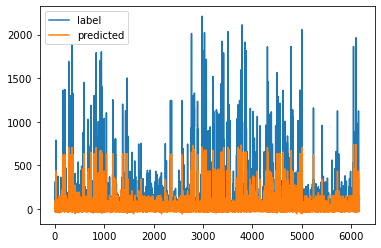

Fold 1


100it [00:00, 994.71it/s]

EPOCH: 0


633it [00:00, 1117.14it/s]
14it [00:00, 154.72it/s]
249it [00:00, 1197.11it/s]

Validation loss decreased (inf --> 20.75855637).  Saving model ...
 tensor(-inf, grad_fn=<SubBackward0>)
epoch 1/200, train MSE 84.8898, 
 Test MSE 20.7586, best test MSE 20.7586
EPOCH: 1


633it [00:00, 1334.37it/s]
14it [00:00, 223.63it/s]
130it [00:00, 1293.82it/s]

Validation loss decreased (20.75855637 --> 15.79756832).  Saving model ...
 tensor(-4.9610, grad_fn=<SubBackward0>)
epoch 2/200, train MSE 58.3977, 
 Test MSE 15.7976, best test MSE 15.7976
EPOCH: 2


633it [00:00, 1386.58it/s]
14it [00:00, 230.57it/s]
137it [00:00, 1365.06it/s]

Validation loss decreased (15.79756832 --> 12.89627171).  Saving model ...
 tensor(-2.9013, grad_fn=<SubBackward0>)
epoch 3/200, train MSE 43.6501, 
 Test MSE 12.8963, best test MSE 12.8963
EPOCH: 3


633it [00:00, 1409.34it/s]
14it [00:00, 225.15it/s]
266it [00:00, 1294.19it/s]

Validation loss decreased (12.89627171 --> 11.08030605).  Saving model ...
 tensor(-1.8160, grad_fn=<SubBackward0>)
epoch 4/200, train MSE 35.6299, 
 Test MSE 11.0803, best test MSE 11.0803
EPOCH: 4


633it [00:00, 1370.22it/s]
14it [00:00, 224.04it/s]
142it [00:00, 1414.17it/s]

Validation loss decreased (11.08030605 --> 9.88798809).  Saving model ...
 tensor(-1.1923, grad_fn=<SubBackward0>)
epoch 5/200, train MSE 31.0557, 
 Test MSE 9.8880, best test MSE 9.8880
EPOCH: 5


633it [00:00, 1421.10it/s]
14it [00:00, 112.13it/s]
113it [00:00, 1129.15it/s]

Validation loss decreased (9.88798809 --> 9.07516575).  Saving model ...
 tensor(-0.8128, grad_fn=<SubBackward0>)
epoch 6/200, train MSE 28.3154, 
 Test MSE 9.0752, best test MSE 9.0752
EPOCH: 6


633it [00:00, 1359.83it/s]
14it [00:00, 224.12it/s]
120it [00:00, 1197.35it/s]

Validation loss decreased (9.07516575 --> 8.50429821).  Saving model ...
 tensor(-0.5709, grad_fn=<SubBackward0>)
epoch 7/200, train MSE 26.6021, 
 Test MSE 8.5043, best test MSE 8.5043
EPOCH: 7


633it [00:00, 1362.66it/s]
14it [00:00, 222.77it/s]
135it [00:00, 1347.36it/s]

Validation loss decreased (8.50429821 --> 8.09356308).  Saving model ...
 tensor(-0.4107, grad_fn=<SubBackward0>)
epoch 8/200, train MSE 25.4925, 
 Test MSE 8.0936, best test MSE 8.0936
EPOCH: 8


633it [00:00, 1340.52it/s]
14it [00:00, 227.32it/s]
137it [00:00, 1368.97it/s]

Validation loss decreased (8.09356308 --> 7.79191542).  Saving model ...
 tensor(-0.3016, grad_fn=<SubBackward0>)
epoch 9/200, train MSE 24.7530, 
 Test MSE 7.7919, best test MSE 7.7919
EPOCH: 9


633it [00:00, 1434.91it/s]
14it [00:00, 237.24it/s]
273it [00:00, 1328.75it/s]

Validation loss decreased (7.79191542 --> 7.56634426).  Saving model ...
 tensor(-0.2256, grad_fn=<SubBackward0>)
epoch 10/200, train MSE 24.2478, 
 Test MSE 7.5663, best test MSE 7.5663
EPOCH: 10


633it [00:00, 1396.14it/s]
14it [00:00, 95.29it/s]
116it [00:00, 1159.40it/s]

Validation loss decreased (7.56634426 --> 7.30255508).  Saving model ...
 tensor(-0.2638, grad_fn=<SubBackward0>)
epoch 11/200, train MSE 23.8589, 
 Test MSE 7.3026, best test MSE 7.3026
EPOCH: 11


633it [00:00, 1181.01it/s]
14it [00:00, 198.79it/s]
129it [00:00, 1284.59it/s]

Validation loss decreased (7.30255508 --> 7.17186737).  Saving model ...
 tensor(-0.1307, grad_fn=<SubBackward0>)
epoch 12/200, train MSE 23.5905, 
 Test MSE 7.1719, best test MSE 7.1719
EPOCH: 12


633it [00:00, 1192.55it/s]
14it [00:00, 188.81it/s]
131it [00:00, 1307.20it/s]

Validation loss decreased (7.17186737 --> 7.06592941).  Saving model ...
 tensor(-0.1059, grad_fn=<SubBackward0>)
epoch 13/200, train MSE 23.4128, 
 Test MSE 7.0659, best test MSE 7.0659
EPOCH: 13


633it [00:00, 1386.32it/s]
14it [00:00, 195.17it/s]
115it [00:00, 1142.18it/s]

Validation loss decreased (7.06592941 --> 6.97985935).  Saving model ...
 tensor(-0.0861, grad_fn=<SubBackward0>)
epoch 14/200, train MSE 23.2765, 
 Test MSE 6.9799, best test MSE 6.9799
EPOCH: 14


633it [00:00, 1277.19it/s]
14it [00:00, 168.83it/s]
204it [00:00, 1011.32it/s]

Validation loss decreased (6.97985935 --> 6.90927076).  Saving model ...
 tensor(-0.0706, grad_fn=<SubBackward0>)
epoch 15/200, train MSE 23.1693, 
 Test MSE 6.9093, best test MSE 6.9093
EPOCH: 15


633it [00:00, 1035.70it/s]
14it [00:00, 88.21it/s]
114it [00:00, 1139.25it/s]

Validation loss decreased (6.90927076 --> 6.85078096).  Saving model ...
 tensor(-0.0585, grad_fn=<SubBackward0>)
epoch 16/200, train MSE 23.0825, 
 Test MSE 6.8508, best test MSE 6.8508
EPOCH: 16


633it [00:00, 1290.17it/s]
14it [00:00, 164.77it/s]
128it [00:00, 1272.01it/s]

Validation loss decreased (6.85078096 --> 6.80185127).  Saving model ...
 tensor(-0.0489, grad_fn=<SubBackward0>)
epoch 17/200, train MSE 23.0105, 
 Test MSE 6.8019, best test MSE 6.8019
EPOCH: 17


633it [00:00, 1310.27it/s]
14it [00:00, 199.45it/s]
134it [00:00, 1330.55it/s]

Validation loss decreased (6.80185127 --> 6.76052046).  Saving model ...
 tensor(-0.0413, grad_fn=<SubBackward0>)
epoch 18/200, train MSE 22.9490, 
 Test MSE 6.7605, best test MSE 6.7605
EPOCH: 18


633it [00:00, 1317.48it/s]
14it [00:00, 204.60it/s]
124it [00:00, 1232.60it/s]

Validation loss decreased (6.76052046 --> 6.72529888).  Saving model ...
 tensor(-0.0352, grad_fn=<SubBackward0>)
epoch 19/200, train MSE 22.8952, 
 Test MSE 6.7253, best test MSE 6.7253
EPOCH: 19


633it [00:00, 1222.23it/s]
14it [00:00, 169.59it/s]
263it [00:00, 1270.16it/s]

Validation loss decreased (6.72529888 --> 6.69503260).  Saving model ...
 tensor(-0.0303, grad_fn=<SubBackward0>)
epoch 20/200, train MSE 22.8470, 
 Test MSE 6.6950, best test MSE 6.6950
EPOCH: 20


633it [00:00, 1372.09it/s]
14it [00:00, 96.03it/s]
120it [00:00, 1198.96it/s]

Validation loss decreased (6.69503260 --> 6.58629179).  Saving model ...
 tensor(-0.1087, grad_fn=<SubBackward0>)
epoch 21/200, train MSE 22.7843, 
 Test MSE 6.5863, best test MSE 6.5863
EPOCH: 21


633it [00:00, 1225.13it/s]
14it [00:00, 176.96it/s]
132it [00:00, 1318.77it/s]

Validation loss decreased (6.58629179 --> 6.56584072).  Saving model ...
 tensor(-0.0205, grad_fn=<SubBackward0>)
epoch 22/200, train MSE 22.7296, 
 Test MSE 6.5658, best test MSE 6.5658
EPOCH: 22


633it [00:00, 1195.71it/s]
14it [00:00, 179.58it/s]
134it [00:00, 1334.34it/s]

Validation loss decreased (6.56584072 --> 6.54628468).  Saving model ...
 tensor(-0.0196, grad_fn=<SubBackward0>)
epoch 23/200, train MSE 22.6934, 
 Test MSE 6.5463, best test MSE 6.5463
EPOCH: 23


633it [00:00, 1408.84it/s]
14it [00:00, 210.25it/s]
260it [00:00, 1285.04it/s]

Validation loss decreased (6.54628468 --> 6.52862835).  Saving model ...
 tensor(-0.0177, grad_fn=<SubBackward0>)
epoch 24/200, train MSE 22.6595, 
 Test MSE 6.5286, best test MSE 6.5286
EPOCH: 24


633it [00:00, 1376.79it/s]
14it [00:00, 217.69it/s]
140it [00:00, 1399.87it/s]

Validation loss decreased (6.52862835 --> 6.51272583).  Saving model ...
 tensor(-0.0159, grad_fn=<SubBackward0>)
epoch 25/200, train MSE 22.6269, 
 Test MSE 6.5127, best test MSE 6.5127
EPOCH: 25


633it [00:00, 1443.52it/s]
14it [00:00, 98.15it/s]
267it [00:00, 1283.07it/s]

Validation loss decreased (6.51272583 --> 6.49833250).  Saving model ...
 tensor(-0.0144, grad_fn=<SubBackward0>)
epoch 26/200, train MSE 22.5953, 
 Test MSE 6.4983, best test MSE 6.4983
EPOCH: 26


633it [00:00, 1400.18it/s]
14it [00:00, 203.79it/s]
281it [00:00, 1371.20it/s]

Validation loss decreased (6.49833250 --> 6.48523712).  Saving model ...
 tensor(-0.0131, grad_fn=<SubBackward0>)
epoch 27/200, train MSE 22.5646, 
 Test MSE 6.4852, best test MSE 6.4852
EPOCH: 27


633it [00:00, 1413.97it/s]
14it [00:00, 203.83it/s]
135it [00:00, 1348.18it/s]

Validation loss decreased (6.48523712 --> 6.47324991).  Saving model ...
 tensor(-0.0120, grad_fn=<SubBackward0>)
epoch 28/200, train MSE 22.5345, 
 Test MSE 6.4732, best test MSE 6.4732
EPOCH: 28


633it [00:00, 1379.92it/s]
14it [00:00, 215.13it/s]
270it [00:00, 1349.92it/s]

Validation loss decreased (6.47324991 --> 6.46220970).  Saving model ...
 tensor(-0.0110, grad_fn=<SubBackward0>)
epoch 29/200, train MSE 22.5052, 
 Test MSE 6.4622, best test MSE 6.4622
EPOCH: 29


633it [00:00, 1401.02it/s]
14it [00:00, 225.65it/s]
135it [00:00, 1349.23it/s]

Validation loss decreased (6.46220970 --> 6.45199823).  Saving model ...
 tensor(-0.0102, grad_fn=<SubBackward0>)
epoch 30/200, train MSE 22.4763, 
 Test MSE 6.4520, best test MSE 6.4520
EPOCH: 30


633it [00:00, 1415.76it/s]
14it [00:00, 96.88it/s]
125it [00:00, 1247.75it/s]

Validation loss decreased (6.45199823 --> 6.39183283).  Saving model ...
 tensor(-0.0602, grad_fn=<SubBackward0>)
epoch 31/200, train MSE 22.4489, 
 Test MSE 6.3918, best test MSE 6.3918
EPOCH: 31


633it [00:00, 1390.30it/s]
14it [00:00, 215.75it/s]
135it [00:00, 1342.93it/s]

Validation loss decreased (6.39183283 --> 6.38542557).  Saving model ...
 tensor(-0.0064, grad_fn=<SubBackward0>)
epoch 32/200, train MSE 22.4103, 
 Test MSE 6.3854, best test MSE 6.3854
EPOCH: 32


633it [00:00, 1385.71it/s]
14it [00:00, 222.83it/s]
285it [00:00, 1415.44it/s]

Validation loss decreased (6.38542557 --> 6.37780142).  Saving model ...
 tensor(-0.0076, grad_fn=<SubBackward0>)
epoch 33/200, train MSE 22.3845, 
 Test MSE 6.3778, best test MSE 6.3778
EPOCH: 33


633it [00:00, 1441.68it/s]
14it [00:00, 239.81it/s]
277it [00:00, 1364.03it/s]

Validation loss decreased (6.37780142 --> 6.37036037).  Saving model ...
 tensor(-0.0074, grad_fn=<SubBackward0>)
epoch 34/200, train MSE 22.3599, 
 Test MSE 6.3704, best test MSE 6.3704
EPOCH: 34


633it [00:00, 1419.47it/s]
14it [00:00, 103.54it/s]
113it [00:00, 1123.20it/s]

Validation loss decreased (6.37036037 --> 6.36326981).  Saving model ...
 tensor(-0.0071, grad_fn=<SubBackward0>)
epoch 35/200, train MSE 22.3356, 
 Test MSE 6.3633, best test MSE 6.3633
EPOCH: 35


633it [00:00, 1359.45it/s]
14it [00:00, 215.86it/s]
136it [00:00, 1353.05it/s]

Validation loss decreased (6.36326981 --> 6.35652781).  Saving model ...
 tensor(-0.0067, grad_fn=<SubBackward0>)
epoch 36/200, train MSE 22.3117, 
 Test MSE 6.3565, best test MSE 6.3565
EPOCH: 36


633it [00:00, 1401.19it/s]
14it [00:00, 215.36it/s]
129it [00:00, 1284.35it/s]

Validation loss decreased (6.35652781 --> 6.35009050).  Saving model ...
 tensor(-0.0064, grad_fn=<SubBackward0>)
epoch 37/200, train MSE 22.2880, 
 Test MSE 6.3501, best test MSE 6.3501
EPOCH: 37


633it [00:00, 1374.28it/s]
14it [00:00, 217.50it/s]
144it [00:00, 1430.65it/s]

Validation loss decreased (6.35009050 --> 6.34392595).  Saving model ...
 tensor(-0.0062, grad_fn=<SubBackward0>)
epoch 38/200, train MSE 22.2646, 
 Test MSE 6.3439, best test MSE 6.3439
EPOCH: 38


633it [00:00, 1384.02it/s]
14it [00:00, 222.74it/s]
138it [00:00, 1371.59it/s]

Validation loss decreased (6.34392595 --> 6.33801365).  Saving model ...
 tensor(-0.0059, grad_fn=<SubBackward0>)
epoch 39/200, train MSE 22.2415, 
 Test MSE 6.3380, best test MSE 6.3380
EPOCH: 39


633it [00:00, 1356.19it/s]
14it [00:00, 109.37it/s]
107it [00:00, 1066.16it/s]

Validation loss decreased (6.33801365 --> 6.33231688).  Saving model ...
 tensor(-0.0057, grad_fn=<SubBackward0>)
epoch 40/200, train MSE 22.2187, 
 Test MSE 6.3323, best test MSE 6.3323
EPOCH: 40


633it [00:00, 1348.49it/s]
14it [00:00, 224.86it/s]
139it [00:00, 1384.71it/s]

Validation loss decreased (6.33231688 --> 6.29848576).  Saving model ...
 tensor(-0.0338, grad_fn=<SubBackward0>)
epoch 41/200, train MSE 22.2081, 
 Test MSE 6.2985, best test MSE 6.2985
EPOCH: 41


633it [00:00, 1419.66it/s]
14it [00:00, 233.14it/s]
135it [00:00, 1349.02it/s]

Validation loss decreased (6.29848576 --> 6.29569197).  Saving model ...
 tensor(-0.0028, grad_fn=<SubBackward0>)
epoch 42/200, train MSE 22.1767, 
 Test MSE 6.2957, best test MSE 6.2957
EPOCH: 42


633it [00:00, 1405.55it/s]
14it [00:00, 216.67it/s]
144it [00:00, 1430.62it/s]

Validation loss decreased (6.29569197 --> 6.29122686).  Saving model ...
 tensor(-0.0045, grad_fn=<SubBackward0>)
epoch 43/200, train MSE 22.1557, 
 Test MSE 6.2912, best test MSE 6.2912
EPOCH: 43


633it [00:00, 1406.75it/s]
14it [00:00, 214.90it/s]
137it [00:00, 1360.09it/s]

Validation loss decreased (6.29122686 --> 6.28659725).  Saving model ...
 tensor(-0.0046, grad_fn=<SubBackward0>)
epoch 44/200, train MSE 22.1358, 
 Test MSE 6.2866, best test MSE 6.2866
EPOCH: 44


633it [00:00, 1411.02it/s]
14it [00:00, 104.12it/s]
109it [00:00, 1088.70it/s]

Validation loss decreased (6.28659725 --> 6.28204393).  Saving model ...
 tensor(-0.0046, grad_fn=<SubBackward0>)
epoch 45/200, train MSE 22.1161, 
 Test MSE 6.2820, best test MSE 6.2820
EPOCH: 45


633it [00:00, 1365.04it/s]
14it [00:00, 217.07it/s]
133it [00:00, 1324.66it/s]

Validation loss decreased (6.28204393 --> 6.27758074).  Saving model ...
 tensor(-0.0045, grad_fn=<SubBackward0>)
epoch 46/200, train MSE 22.0967, 
 Test MSE 6.2776, best test MSE 6.2776
EPOCH: 46


633it [00:00, 1416.51it/s]
14it [00:00, 226.33it/s]
137it [00:00, 1366.17it/s]

Validation loss decreased (6.27758074 --> 6.27324009).  Saving model ...
 tensor(-0.0043, grad_fn=<SubBackward0>)
epoch 47/200, train MSE 22.0775, 
 Test MSE 6.2732, best test MSE 6.2732
EPOCH: 47


633it [00:00, 1350.64it/s]
14it [00:00, 213.23it/s]
130it [00:00, 1295.19it/s]

Validation loss decreased (6.27324009 --> 6.26899767).  Saving model ...
 tensor(-0.0042, grad_fn=<SubBackward0>)
epoch 48/200, train MSE 22.0584, 
 Test MSE 6.2690, best test MSE 6.2690
EPOCH: 48


633it [00:00, 1339.33it/s]
14it [00:00, 211.33it/s]
136it [00:00, 1359.61it/s]

Validation loss decreased (6.26899767 --> 6.26484442).  Saving model ...
 tensor(-0.0042, grad_fn=<SubBackward0>)
epoch 49/200, train MSE 22.0395, 
 Test MSE 6.2648, best test MSE 6.2648
EPOCH: 49


633it [00:00, 1261.08it/s]
14it [00:00, 103.67it/s]
109it [00:00, 1083.99it/s]

Validation loss decreased (6.26484442 --> 6.26078463).  Saving model ...
 tensor(-0.0041, grad_fn=<SubBackward0>)
epoch 50/200, train MSE 22.0209, 
 Test MSE 6.2608, best test MSE 6.2608
EPOCH: 50


633it [00:00, 1326.20it/s]
14it [00:00, 222.31it/s]
276it [00:00, 1390.32it/s]

Validation loss decreased (6.26078463 --> 6.24245787).  Saving model ...
 tensor(-0.0183, grad_fn=<SubBackward0>)
epoch 51/200, train MSE 22.0204, 
 Test MSE 6.2425, best test MSE 6.2425
EPOCH: 51


633it [00:00, 1402.93it/s]
14it [00:00, 209.58it/s]
130it [00:00, 1293.28it/s]

Validation loss decreased (6.24245787 --> 6.24118376).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 52/200, train MSE 21.9943, 
 Test MSE 6.2412, best test MSE 6.2412
EPOCH: 52


633it [00:00, 1403.91it/s]
14it [00:00, 213.17it/s]
115it [00:00, 1149.01it/s]

Validation loss decreased (6.24118376 --> 6.23809814).  Saving model ...
 tensor(-0.0031, grad_fn=<SubBackward0>)
epoch 53/200, train MSE 21.9768, 
 Test MSE 6.2381, best test MSE 6.2381
EPOCH: 53


633it [00:00, 1370.61it/s]
14it [00:00, 209.94it/s]
133it [00:00, 1328.49it/s]

Validation loss decreased (6.23809814 --> 6.23468971).  Saving model ...
 tensor(-0.0034, grad_fn=<SubBackward0>)
epoch 54/200, train MSE 21.9603, 
 Test MSE 6.2347, best test MSE 6.2347
EPOCH: 54


633it [00:00, 1413.03it/s]
14it [00:00, 97.90it/s]
116it [00:00, 1159.08it/s]

Validation loss decreased (6.23468971 --> 6.23126650).  Saving model ...
 tensor(-0.0034, grad_fn=<SubBackward0>)
epoch 55/200, train MSE 21.9441, 
 Test MSE 6.2313, best test MSE 6.2313
EPOCH: 55


633it [00:00, 1392.89it/s]
14it [00:00, 217.02it/s]
128it [00:00, 1278.59it/s]

Validation loss decreased (6.23126650 --> 6.22787189).  Saving model ...
 tensor(-0.0034, grad_fn=<SubBackward0>)
epoch 56/200, train MSE 21.9281, 
 Test MSE 6.2279, best test MSE 6.2279
EPOCH: 56


633it [00:00, 1387.84it/s]
14it [00:00, 216.34it/s]
132it [00:00, 1316.82it/s]

Validation loss decreased (6.22787189 --> 6.22452641).  Saving model ...
 tensor(-0.0033, grad_fn=<SubBackward0>)
epoch 57/200, train MSE 21.9122, 
 Test MSE 6.2245, best test MSE 6.2245
EPOCH: 57


633it [00:00, 1428.02it/s]
14it [00:00, 211.70it/s]
133it [00:00, 1324.95it/s]

Validation loss decreased (6.22452641 --> 6.22123289).  Saving model ...
 tensor(-0.0033, grad_fn=<SubBackward0>)
epoch 58/200, train MSE 21.8964, 
 Test MSE 6.2212, best test MSE 6.2212
EPOCH: 58


633it [00:00, 1387.98it/s]
14it [00:00, 211.40it/s]
278it [00:00, 1363.47it/s]

Validation loss decreased (6.22123289 --> 6.21799421).  Saving model ...
 tensor(-0.0032, grad_fn=<SubBackward0>)
epoch 59/200, train MSE 21.8808, 
 Test MSE 6.2180, best test MSE 6.2180
EPOCH: 59


633it [00:00, 1390.82it/s]
14it [00:00, 94.46it/s]
101it [00:00, 1004.14it/s]

Validation loss decreased (6.21799421 --> 6.21479893).  Saving model ...
 tensor(-0.0032, grad_fn=<SubBackward0>)
epoch 60/200, train MSE 21.8653, 
 Test MSE 6.2148, best test MSE 6.2148
EPOCH: 60


633it [00:00, 1042.08it/s]
14it [00:00, 209.88it/s]
135it [00:00, 1346.00it/s]

Validation loss decreased (6.21479893 --> 6.20565796).  Saving model ...
 tensor(-0.0091, grad_fn=<SubBackward0>)
epoch 61/200, train MSE 21.8711, 
 Test MSE 6.2057, best test MSE 6.2057
EPOCH: 61


633it [00:00, 1384.34it/s]
14it [00:00, 212.37it/s]
276it [00:00, 1352.27it/s]

EarlyStopping counter: 1 out of 10
epoch 62/200, train MSE 21.8491, 
 Test MSE 6.2053, best test MSE 6.2057
EPOCH: 62


633it [00:00, 1413.94it/s]
14it [00:00, 206.57it/s]
134it [00:00, 1332.39it/s]

Validation loss decreased (6.20565796 --> 6.20303631).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 63/200, train MSE 21.8343, 
 Test MSE 6.2030, best test MSE 6.2030
EPOCH: 63


633it [00:00, 1416.12it/s]
14it [00:00, 241.97it/s]
132it [00:00, 1312.04it/s]

Validation loss decreased (6.20303631 --> 6.20038652).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 64/200, train MSE 21.8205, 
 Test MSE 6.2004, best test MSE 6.2004
EPOCH: 64


633it [00:00, 1401.54it/s]
14it [00:00, 90.21it/s]
268it [00:00, 1280.88it/s]

Validation loss decreased (6.20038652 --> 6.19765520).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 65/200, train MSE 21.8070, 
 Test MSE 6.1977, best test MSE 6.1977
EPOCH: 65


633it [00:00, 1397.27it/s]
14it [00:00, 212.34it/s]
130it [00:00, 1294.95it/s]

Validation loss decreased (6.19765520 --> 6.19491911).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 66/200, train MSE 21.7936, 
 Test MSE 6.1949, best test MSE 6.1949
EPOCH: 66


633it [00:00, 1396.97it/s]
14it [00:00, 195.52it/s]
277it [00:00, 1365.68it/s]

Validation loss decreased (6.19491911 --> 6.19220352).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 67/200, train MSE 21.7803, 
 Test MSE 6.1922, best test MSE 6.1922
EPOCH: 67


633it [00:00, 1410.92it/s]
14it [00:00, 212.62it/s]
128it [00:00, 1272.28it/s]

Validation loss decreased (6.19220352 --> 6.18952084).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 68/200, train MSE 21.7671, 
 Test MSE 6.1895, best test MSE 6.1895
EPOCH: 68


633it [00:00, 1386.41it/s]
14it [00:00, 219.49it/s]
276it [00:00, 1347.82it/s]

Validation loss decreased (6.18952084 --> 6.18687487).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 69/200, train MSE 21.7540, 
 Test MSE 6.1869, best test MSE 6.1869
EPOCH: 69


633it [00:00, 1412.30it/s]
14it [00:00, 92.64it/s]
123it [00:00, 1227.48it/s]

Validation loss decreased (6.18687487 --> 6.18424940).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 70/200, train MSE 21.7410, 
 Test MSE 6.1842, best test MSE 6.1842
EPOCH: 70


633it [00:00, 1360.06it/s]
14it [00:00, 219.18it/s]
278it [00:00, 1361.10it/s]

Validation loss decreased (6.18424940 --> 6.18045998).  Saving model ...
 tensor(-0.0038, grad_fn=<SubBackward0>)
epoch 71/200, train MSE 21.7507, 
 Test MSE 6.1805, best test MSE 6.1805
EPOCH: 71


633it [00:00, 1404.13it/s]
14it [00:00, 216.53it/s]
273it [00:00, 1328.39it/s]

EarlyStopping counter: 1 out of 10
epoch 72/200, train MSE 21.7321, 
 Test MSE 6.1807, best test MSE 6.1805
EPOCH: 72


633it [00:00, 1369.62it/s]
14it [00:00, 219.27it/s]
131it [00:00, 1302.47it/s]

Validation loss decreased (6.18045998 --> 6.17907858).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 73/200, train MSE 21.7195, 
 Test MSE 6.1791, best test MSE 6.1791
EPOCH: 73


633it [00:00, 1378.85it/s]
14it [00:00, 223.48it/s]
274it [00:00, 1331.58it/s]

Validation loss decreased (6.17907858 --> 6.17697859).  Saving model ...
 tensor(-0.0021, grad_fn=<SubBackward0>)
epoch 74/200, train MSE 21.7078, 
 Test MSE 6.1770, best test MSE 6.1770
EPOCH: 74


633it [00:00, 1413.48it/s]
14it [00:00, 94.18it/s]
123it [00:00, 1227.60it/s]

Validation loss decreased (6.17697859 --> 6.17475080).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 75/200, train MSE 21.6964, 
 Test MSE 6.1748, best test MSE 6.1748
EPOCH: 75


633it [00:00, 1363.72it/s]
14it [00:00, 216.76it/s]
136it [00:00, 1351.42it/s]

Validation loss decreased (6.17475080 --> 6.17249966).  Saving model ...
 tensor(-0.0023, grad_fn=<SubBackward0>)
epoch 76/200, train MSE 21.6851, 
 Test MSE 6.1725, best test MSE 6.1725
EPOCH: 76


633it [00:00, 1414.89it/s]
14it [00:00, 210.24it/s]
131it [00:00, 1304.61it/s]

Validation loss decreased (6.17249966 --> 6.17025375).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 77/200, train MSE 21.6738, 
 Test MSE 6.1703, best test MSE 6.1703
EPOCH: 77


633it [00:00, 1415.11it/s]
14it [00:00, 236.83it/s]
126it [00:00, 1259.12it/s]

Validation loss decreased (6.17025375 --> 6.16803122).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 78/200, train MSE 21.6626, 
 Test MSE 6.1680, best test MSE 6.1680
EPOCH: 78


633it [00:00, 1409.92it/s]
14it [00:00, 218.08it/s]
141it [00:00, 1403.91it/s]

Validation loss decreased (6.16803122 --> 6.16581583).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 79/200, train MSE 21.6516, 
 Test MSE 6.1658, best test MSE 6.1658
EPOCH: 79


633it [00:00, 1429.87it/s]
14it [00:00, 91.94it/s]
273it [00:00, 1317.07it/s]

Validation loss decreased (6.16581583 --> 6.16362333).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 80/200, train MSE 21.6406, 
 Test MSE 6.1636, best test MSE 6.1636
EPOCH: 80


633it [00:00, 1402.67it/s]
14it [00:00, 215.46it/s]
138it [00:00, 1379.17it/s]

EarlyStopping counter: 1 out of 10
epoch 81/200, train MSE 21.6527, 
 Test MSE 6.1628, best test MSE 6.1636
EPOCH: 81


633it [00:00, 1416.27it/s]
14it [00:00, 211.36it/s]
282it [00:00, 1407.20it/s]

EarlyStopping counter: 2 out of 10
epoch 82/200, train MSE 21.6369, 
 Test MSE 6.1635, best test MSE 6.1636
EPOCH: 82


633it [00:00, 1417.23it/s]
14it [00:00, 213.91it/s]
136it [00:00, 1351.47it/s]

Validation loss decreased (6.16362333 --> 6.16237879).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 83/200, train MSE 21.6260, 
 Test MSE 6.1624, best test MSE 6.1624
EPOCH: 83


633it [00:00, 1367.64it/s]
14it [00:00, 101.05it/s]
112it [00:00, 1112.46it/s]

Validation loss decreased (6.16237879 --> 6.16073370).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 84/200, train MSE 21.6160, 
 Test MSE 6.1607, best test MSE 6.1607
EPOCH: 84


633it [00:00, 1357.19it/s]
14it [00:00, 218.25it/s]
128it [00:00, 1277.41it/s]

Validation loss decreased (6.16073370 --> 6.15891838).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 85/200, train MSE 21.6063, 
 Test MSE 6.1589, best test MSE 6.1589
EPOCH: 85


633it [00:00, 1393.03it/s]
14it [00:00, 221.08it/s]
266it [00:00, 1298.36it/s]

Validation loss decreased (6.15891838 --> 6.15705109).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 86/200, train MSE 21.5967, 
 Test MSE 6.1571, best test MSE 6.1571
EPOCH: 86


633it [00:00, 1399.89it/s]
14it [00:00, 214.59it/s]
127it [00:00, 1262.07it/s]

Validation loss decreased (6.15705109 --> 6.15518713).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 87/200, train MSE 21.5871, 
 Test MSE 6.1552, best test MSE 6.1552
EPOCH: 87


633it [00:00, 1399.28it/s]
14it [00:00, 205.66it/s]
272it [00:00, 1330.78it/s]

Validation loss decreased (6.15518713 --> 6.15331793).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 88/200, train MSE 21.5776, 
 Test MSE 6.1533, best test MSE 6.1533
EPOCH: 88


633it [00:00, 1402.19it/s]
14it [00:00, 91.74it/s]
118it [00:00, 1176.55it/s]

Validation loss decreased (6.15331793 --> 6.15145445).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 89/200, train MSE 21.5682, 
 Test MSE 6.1515, best test MSE 6.1515
EPOCH: 89


633it [00:00, 1380.06it/s]
14it [00:00, 214.30it/s]
132it [00:00, 1316.67it/s]

Validation loss decreased (6.15145445 --> 6.14959526).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 90/200, train MSE 21.5588, 
 Test MSE 6.1496, best test MSE 6.1496
EPOCH: 90


633it [00:00, 1401.45it/s]
14it [00:00, 216.17it/s]
139it [00:00, 1386.82it/s]

EarlyStopping counter: 1 out of 10
epoch 91/200, train MSE 21.5723, 
 Test MSE 6.1503, best test MSE 6.1496
EPOCH: 91


633it [00:00, 1417.67it/s]
14it [00:00, 236.04it/s]
279it [00:00, 1392.34it/s]

EarlyStopping counter: 2 out of 10
epoch 92/200, train MSE 21.5589, 
 Test MSE 6.1514, best test MSE 6.1496
EPOCH: 92


633it [00:00, 1420.87it/s]
14it [00:00, 217.42it/s]
138it [00:00, 1377.10it/s]

EarlyStopping counter: 3 out of 10
epoch 93/200, train MSE 21.5494, 
 Test MSE 6.1506, best test MSE 6.1496
EPOCH: 93


633it [00:00, 1405.25it/s]
14it [00:00, 93.11it/s]
116it [00:00, 1154.52it/s]

EarlyStopping counter: 4 out of 10
epoch 94/200, train MSE 21.5408, 
 Test MSE 6.1494, best test MSE 6.1496
EPOCH: 94


633it [00:00, 1346.32it/s]
14it [00:00, 213.01it/s]
277it [00:00, 1377.98it/s]

Validation loss decreased (6.14959526 --> 6.14790154).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 95/200, train MSE 21.5324, 
 Test MSE 6.1479, best test MSE 6.1479
EPOCH: 95


633it [00:00, 1401.91it/s]
14it [00:00, 220.08it/s]
260it [00:00, 1219.41it/s]

Validation loss decreased (6.14790154 --> 6.14635563).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 96/200, train MSE 21.5242, 
 Test MSE 6.1464, best test MSE 6.1464
EPOCH: 96


633it [00:00, 1376.15it/s]
14it [00:00, 224.43it/s]
139it [00:00, 1380.83it/s]

Validation loss decreased (6.14635563 --> 6.14478397).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 97/200, train MSE 21.5160, 
 Test MSE 6.1448, best test MSE 6.1448
EPOCH: 97


633it [00:00, 1404.18it/s]
14it [00:00, 219.23it/s]
267it [00:00, 1332.26it/s]

Validation loss decreased (6.14478397 --> 6.14320898).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 98/200, train MSE 21.5078, 
 Test MSE 6.1432, best test MSE 6.1432
EPOCH: 98


633it [00:00, 1390.18it/s]
14it [00:00, 93.83it/s]
120it [00:00, 1199.48it/s]

Validation loss decreased (6.14320898 --> 6.14163351).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 99/200, train MSE 21.4997, 
 Test MSE 6.1416, best test MSE 6.1416
EPOCH: 99


633it [00:00, 1392.11it/s]
14it [00:00, 216.43it/s]
123it [00:00, 1228.01it/s]

Validation loss decreased (6.14163351 --> 6.14005232).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 100/200, train MSE 21.4917, 
 Test MSE 6.1401, best test MSE 6.1401
EPOCH: 100


633it [00:00, 1368.11it/s]
14it [00:00, 215.05it/s]
279it [00:00, 1373.25it/s]

EarlyStopping counter: 1 out of 10
epoch 101/200, train MSE 21.5060, 
 Test MSE 6.1415, best test MSE 6.1401
EPOCH: 101


633it [00:00, 1422.96it/s]
14it [00:00, 213.03it/s]
130it [00:00, 1288.14it/s]

EarlyStopping counter: 2 out of 10
epoch 102/200, train MSE 21.4946, 
 Test MSE 6.1428, best test MSE 6.1401
EPOCH: 102


633it [00:00, 1392.74it/s]
14it [00:00, 213.71it/s]
267it [00:00, 1325.41it/s]

EarlyStopping counter: 3 out of 10
epoch 103/200, train MSE 21.4863, 
 Test MSE 6.1424, best test MSE 6.1401
EPOCH: 103


633it [00:00, 1393.21it/s]
14it [00:00, 95.74it/s]
125it [00:00, 1248.44it/s]

EarlyStopping counter: 4 out of 10
epoch 104/200, train MSE 21.4789, 
 Test MSE 6.1414, best test MSE 6.1401
EPOCH: 104


633it [00:00, 1381.04it/s]
14it [00:00, 213.61it/s]
140it [00:00, 1398.07it/s]

EarlyStopping counter: 5 out of 10
epoch 105/200, train MSE 21.4716, 
 Test MSE 6.1402, best test MSE 6.1401
EPOCH: 105


633it [00:00, 1429.74it/s]
14it [00:00, 213.77it/s]
133it [00:00, 1327.70it/s]

Validation loss decreased (6.14005232 --> 6.13894558).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 106/200, train MSE 21.4645, 
 Test MSE 6.1389, best test MSE 6.1389
EPOCH: 106


633it [00:00, 1396.96it/s]
14it [00:00, 213.30it/s]
106it [00:00, 1054.63it/s]

Validation loss decreased (6.13894558 --> 6.13762760).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 107/200, train MSE 21.4574, 
 Test MSE 6.1376, best test MSE 6.1376
EPOCH: 107


633it [00:00, 1052.48it/s]
14it [00:00, 173.74it/s]
270it [00:00, 1324.36it/s]

Validation loss decreased (6.13762760 --> 6.13629580).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 108/200, train MSE 21.4504, 
 Test MSE 6.1363, best test MSE 6.1363
EPOCH: 108


633it [00:00, 1402.90it/s]
14it [00:00, 94.60it/s]
271it [00:00, 1317.67it/s]

Validation loss decreased (6.13629580 --> 6.13495922).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 109/200, train MSE 21.4434, 
 Test MSE 6.1350, best test MSE 6.1350
EPOCH: 109


633it [00:00, 1393.16it/s]
14it [00:00, 208.86it/s]
136it [00:00, 1355.72it/s]

Validation loss decreased (6.13495922 --> 6.13362885).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 110/200, train MSE 21.4365, 
 Test MSE 6.1336, best test MSE 6.1336
EPOCH: 110


633it [00:00, 1408.16it/s]
14it [00:00, 195.12it/s]
270it [00:00, 1310.83it/s]

EarlyStopping counter: 1 out of 10
epoch 111/200, train MSE 21.4512, 
 Test MSE 6.1353, best test MSE 6.1336
EPOCH: 111


633it [00:00, 1395.16it/s]
14it [00:00, 217.48it/s]
137it [00:00, 1367.36it/s]

EarlyStopping counter: 2 out of 10
epoch 112/200, train MSE 21.4415, 
 Test MSE 6.1367, best test MSE 6.1336
EPOCH: 112


633it [00:00, 1418.77it/s]
14it [00:00, 241.76it/s]
140it [00:00, 1399.54it/s]

EarlyStopping counter: 3 out of 10
epoch 113/200, train MSE 21.4343, 
 Test MSE 6.1366, best test MSE 6.1336
EPOCH: 113


633it [00:00, 1390.79it/s]
14it [00:00, 93.35it/s]
125it [00:00, 1242.38it/s]

EarlyStopping counter: 4 out of 10
epoch 114/200, train MSE 21.4278, 
 Test MSE 6.1359, best test MSE 6.1336
EPOCH: 114


633it [00:00, 1379.54it/s]
14it [00:00, 214.67it/s]
135it [00:00, 1348.22it/s]

EarlyStopping counter: 5 out of 10
epoch 115/200, train MSE 21.4215, 
 Test MSE 6.1350, best test MSE 6.1336
EPOCH: 115


633it [00:00, 1390.60it/s]
14it [00:00, 203.00it/s]
277it [00:00, 1342.40it/s]

EarlyStopping counter: 6 out of 10
epoch 116/200, train MSE 21.4153, 
 Test MSE 6.1340, best test MSE 6.1336
EPOCH: 116


633it [00:00, 1379.59it/s]
14it [00:00, 213.10it/s]
140it [00:00, 1397.88it/s]

EarlyStopping counter: 7 out of 10
epoch 117/200, train MSE 21.4092, 
 Test MSE 6.1329, best test MSE 6.1336
EPOCH: 117


633it [00:00, 1425.35it/s]
14it [00:00, 106.66it/s]
114it [00:00, 1137.72it/s]

Validation loss decreased (6.13362885 --> 6.13173723).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 118/200, train MSE 21.4031, 
 Test MSE 6.1317, best test MSE 6.1317
EPOCH: 118


633it [00:00, 1372.71it/s]
14it [00:00, 212.86it/s]
136it [00:00, 1358.93it/s]

Validation loss decreased (6.13173723 --> 6.13061142).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 119/200, train MSE 21.3970, 
 Test MSE 6.1306, best test MSE 6.1306
EPOCH: 119


633it [00:00, 1431.15it/s]
14it [00:00, 238.37it/s]
131it [00:00, 1306.05it/s]

Validation loss decreased (6.13061142 --> 6.12947178).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 120/200, train MSE 21.3910, 
 Test MSE 6.1295, best test MSE 6.1295
EPOCH: 120


633it [00:00, 1379.08it/s]
14it [00:00, 206.06it/s]
132it [00:00, 1317.17it/s]

EarlyStopping counter: 1 out of 10
epoch 121/200, train MSE 21.4059, 
 Test MSE 6.1313, best test MSE 6.1295
EPOCH: 121


633it [00:00, 1406.00it/s]
14it [00:00, 208.95it/s]
267it [00:00, 1311.55it/s]

EarlyStopping counter: 2 out of 10
epoch 122/200, train MSE 21.3977, 
 Test MSE 6.1327, best test MSE 6.1295
EPOCH: 122


633it [00:00, 1394.10it/s]
14it [00:00, 98.40it/s]
262it [00:00, 1235.52it/s]

EarlyStopping counter: 3 out of 10
epoch 123/200, train MSE 21.3913, 
 Test MSE 6.1329, best test MSE 6.1295
EPOCH: 123


633it [00:00, 1377.23it/s]
14it [00:00, 219.64it/s]
269it [00:00, 1346.00it/s]

EarlyStopping counter: 4 out of 10
epoch 124/200, train MSE 21.3857, 
 Test MSE 6.1324, best test MSE 6.1295
EPOCH: 124


633it [00:00, 1393.87it/s]
14it [00:00, 202.93it/s]
279it [00:00, 1360.02it/s]

EarlyStopping counter: 5 out of 10
epoch 125/200, train MSE 21.3802, 
 Test MSE 6.1317, best test MSE 6.1295
EPOCH: 125


633it [00:00, 1424.09it/s]
14it [00:00, 214.83it/s]
281it [00:00, 1368.58it/s]

EarlyStopping counter: 6 out of 10
epoch 126/200, train MSE 21.3748, 
 Test MSE 6.1308, best test MSE 6.1295
EPOCH: 126


633it [00:00, 1417.00it/s]
14it [00:00, 204.11it/s]
266it [00:00, 1318.58it/s]

EarlyStopping counter: 7 out of 10
epoch 127/200, train MSE 21.3694, 
 Test MSE 6.1299, best test MSE 6.1295
EPOCH: 127


633it [00:00, 1368.51it/s]
14it [00:00, 94.80it/s]
263it [00:00, 1258.37it/s]

EarlyStopping counter: 8 out of 10
epoch 128/200, train MSE 21.3642, 
 Test MSE 6.1290, best test MSE 6.1295
EPOCH: 128


633it [00:00, 1368.41it/s]
14it [00:00, 222.52it/s]
138it [00:00, 1379.28it/s]

Validation loss decreased (6.12947178 --> 6.12805033).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 129/200, train MSE 21.3589, 
 Test MSE 6.1281, best test MSE 6.1281
EPOCH: 129


633it [00:00, 1412.11it/s]
14it [00:00, 218.59it/s]
143it [00:00, 1423.61it/s]

EarlyStopping counter: 1 out of 10
epoch 130/200, train MSE 21.3536, 
 Test MSE 6.1271, best test MSE 6.1281
EPOCH: 130


633it [00:00, 1423.66it/s]
14it [00:00, 219.92it/s]
135it [00:00, 1342.68it/s]

EarlyStopping counter: 2 out of 10
epoch 131/200, train MSE 21.3688, 
 Test MSE 6.1289, best test MSE 6.1281
EPOCH: 131


633it [00:00, 1423.76it/s]
14it [00:00, 238.49it/s]
272it [00:00, 1348.05it/s]

EarlyStopping counter: 3 out of 10
epoch 132/200, train MSE 21.3617, 
 Test MSE 6.1304, best test MSE 6.1281
EPOCH: 132


633it [00:00, 1383.14it/s]
14it [00:00, 94.81it/s]
127it [00:00, 1260.54it/s]

EarlyStopping counter: 4 out of 10
epoch 133/200, train MSE 21.3562, 
 Test MSE 6.1307, best test MSE 6.1281
EPOCH: 133


633it [00:00, 1377.65it/s]
14it [00:00, 212.45it/s]
131it [00:00, 1304.25it/s]

EarlyStopping counter: 5 out of 10
epoch 134/200, train MSE 21.3512, 
 Test MSE 6.1304, best test MSE 6.1281
EPOCH: 134


633it [00:00, 1411.43it/s]
14it [00:00, 213.83it/s]
278it [00:00, 1374.20it/s]

EarlyStopping counter: 6 out of 10
epoch 135/200, train MSE 21.3464, 
 Test MSE 6.1299, best test MSE 6.1281
EPOCH: 135


633it [00:00, 1422.06it/s]
14it [00:00, 207.36it/s]
277it [00:00, 1349.27it/s]

EarlyStopping counter: 7 out of 10
epoch 136/200, train MSE 21.3417, 
 Test MSE 6.1292, best test MSE 6.1281
EPOCH: 136


633it [00:00, 1411.00it/s]
14it [00:00, 216.60it/s]
272it [00:00, 1339.25it/s]

EarlyStopping counter: 8 out of 10
epoch 137/200, train MSE 21.3370, 
 Test MSE 6.1285, best test MSE 6.1281
EPOCH: 137


633it [00:00, 1413.73it/s]
14it [00:00, 95.19it/s]
124it [00:00, 1235.54it/s]

EarlyStopping counter: 9 out of 10
epoch 138/200, train MSE 21.3324, 
 Test MSE 6.1277, best test MSE 6.1281
EPOCH: 138


633it [00:00, 1349.62it/s]
14it [00:00, 211.27it/s]
285it [00:00, 1412.06it/s]

Validation loss decreased (6.12805033 --> 6.12694407).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 139/200, train MSE 21.3278, 
 Test MSE 6.1269, best test MSE 6.1269
EPOCH: 139


633it [00:00, 1430.80it/s]
14it [00:00, 235.54it/s]
268it [00:00, 1334.78it/s]

EarlyStopping counter: 1 out of 10
epoch 140/200, train MSE 21.3232, 
 Test MSE 6.1261, best test MSE 6.1269
EPOCH: 140


633it [00:00, 1394.35it/s]
14it [00:00, 210.29it/s]
282it [00:00, 1415.79it/s]

EarlyStopping counter: 2 out of 10
epoch 141/200, train MSE 21.3386, 
 Test MSE 6.1279, best test MSE 6.1269
EPOCH: 141


633it [00:00, 1412.44it/s]
14it [00:00, 241.37it/s]
139it [00:00, 1384.43it/s]

EarlyStopping counter: 3 out of 10
epoch 142/200, train MSE 21.3326, 
 Test MSE 6.1294, best test MSE 6.1269
EPOCH: 142


633it [00:00, 1410.09it/s]
14it [00:00, 94.73it/s]
266it [00:00, 1293.36it/s]

EarlyStopping counter: 4 out of 10
epoch 143/200, train MSE 21.3278, 
 Test MSE 6.1299, best test MSE 6.1269
EPOCH: 143


633it [00:00, 1313.31it/s]
14it [00:00, 215.65it/s]
133it [00:00, 1328.49it/s]

EarlyStopping counter: 5 out of 10
epoch 144/200, train MSE 21.3234, 
 Test MSE 6.1298, best test MSE 6.1269
EPOCH: 144


633it [00:00, 1371.59it/s]
14it [00:00, 219.58it/s]
138it [00:00, 1375.40it/s]

EarlyStopping counter: 6 out of 10
epoch 145/200, train MSE 21.3192, 
 Test MSE 6.1294, best test MSE 6.1269
EPOCH: 145


633it [00:00, 1405.50it/s]
14it [00:00, 213.81it/s]
129it [00:00, 1283.89it/s]

EarlyStopping counter: 7 out of 10
epoch 146/200, train MSE 21.3150, 
 Test MSE 6.1289, best test MSE 6.1269
EPOCH: 146


633it [00:00, 1374.11it/s]
14it [00:00, 98.46it/s]
112it [00:00, 1113.18it/s]

EarlyStopping counter: 8 out of 10
epoch 147/200, train MSE 21.3109, 
 Test MSE 6.1284, best test MSE 6.1269
EPOCH: 147


633it [00:00, 1373.87it/s]
14it [00:00, 216.26it/s]
132it [00:00, 1313.80it/s]

EarlyStopping counter: 9 out of 10
epoch 148/200, train MSE 21.3069, 
 Test MSE 6.1277, best test MSE 6.1269
EPOCH: 148


633it [00:00, 1399.35it/s]
14it [00:00, 204.35it/s]


EarlyStopping counter: 10 out of 10
epoch 149/200, train MSE 21.3028, 
 Test MSE 6.1271, best test MSE 6.1269
Model saved at DNN/model_extended/fold1/fold1_regression.pth


35it [00:00, 702.13it/s]


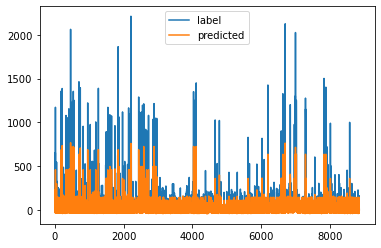

Fold 2


139it [00:00, 1387.48it/s]

EPOCH: 0


1121it [00:00, 1412.47it/s]
25it [00:00, 219.17it/s]
134it [00:00, 1338.20it/s]

Validation loss decreased (inf --> 26.19038010).  Saving model ...
 tensor(-inf, grad_fn=<SubBackward0>)
epoch 1/200, train MSE 94.6044, 
 Test MSE 26.1904, best test MSE 26.1904
EPOCH: 1


1121it [00:00, 1450.47it/s]
25it [00:00, 232.96it/s]
131it [00:00, 1306.67it/s]

Validation loss decreased (26.19038010 --> 20.99855995).  Saving model ...
 tensor(-5.1918, grad_fn=<SubBackward0>)
epoch 2/200, train MSE 59.3825, 
 Test MSE 20.9986, best test MSE 20.9986
EPOCH: 2


1121it [00:00, 1397.37it/s]
25it [00:00, 235.66it/s]
126it [00:00, 1254.93it/s]

Validation loss decreased (20.99855995 --> 18.40648651).  Saving model ...
 tensor(-2.5921, grad_fn=<SubBackward0>)
epoch 3/200, train MSE 45.3187, 
 Test MSE 18.4065, best test MSE 18.4065
EPOCH: 3


1121it [00:00, 1441.91it/s]
25it [00:00, 127.96it/s]
124it [00:00, 1232.08it/s]

Validation loss decreased (18.40648651 --> 16.94809532).  Saving model ...
 tensor(-1.4584, grad_fn=<SubBackward0>)
epoch 4/200, train MSE 39.1827, 
 Test MSE 16.9481, best test MSE 16.9481
EPOCH: 4


1121it [00:00, 1419.31it/s]
25it [00:00, 230.07it/s]
133it [00:00, 1327.69it/s]

Validation loss decreased (16.94809532 --> 16.05415154).  Saving model ...
 tensor(-0.8939, grad_fn=<SubBackward0>)
epoch 5/200, train MSE 36.2038, 
 Test MSE 16.0542, best test MSE 16.0542
EPOCH: 5


1121it [00:00, 1410.40it/s]
25it [00:00, 222.05it/s]
127it [00:00, 1266.52it/s]

Validation loss decreased (16.05415154 --> 15.47035885).  Saving model ...
 tensor(-0.5838, grad_fn=<SubBackward0>)
epoch 6/200, train MSE 34.6452, 
 Test MSE 15.4704, best test MSE 15.4704
EPOCH: 6


1121it [00:00, 1423.01it/s]
25it [00:00, 121.98it/s]
264it [00:00, 1304.23it/s]

Validation loss decreased (15.47035885 --> 15.06926727).  Saving model ...
 tensor(-0.4011, grad_fn=<SubBackward0>)
epoch 7/200, train MSE 33.7829, 
 Test MSE 15.0693, best test MSE 15.0693
EPOCH: 7


1121it [00:00, 1419.72it/s]
25it [00:00, 232.84it/s]
135it [00:00, 1348.64it/s]

Validation loss decreased (15.06926727 --> 14.78160191).  Saving model ...
 tensor(-0.2877, grad_fn=<SubBackward0>)
epoch 8/200, train MSE 33.2814, 
 Test MSE 14.7816, best test MSE 14.7816
EPOCH: 8


1121it [00:00, 1437.64it/s]
25it [00:00, 230.58it/s]
130it [00:00, 1295.77it/s]

Validation loss decreased (14.78160191 --> 14.56715012).  Saving model ...
 tensor(-0.2145, grad_fn=<SubBackward0>)
epoch 9/200, train MSE 32.9727, 
 Test MSE 14.5672, best test MSE 14.5672
EPOCH: 9


1121it [00:00, 1438.62it/s]
25it [00:00, 123.85it/s]
285it [00:00, 1421.45it/s]

Validation loss decreased (14.56715012 --> 14.40164280).  Saving model ...
 tensor(-0.1655, grad_fn=<SubBackward0>)
epoch 10/200, train MSE 32.7683, 
 Test MSE 14.4016, best test MSE 14.4016
EPOCH: 10


1121it [00:00, 1376.73it/s]
25it [00:00, 232.78it/s]
116it [00:00, 1152.58it/s]

Validation loss decreased (14.40164280 --> 13.75574684).  Saving model ...
 tensor(-0.6459, grad_fn=<SubBackward0>)
epoch 11/200, train MSE 32.5274, 
 Test MSE 13.7557, best test MSE 13.7557
EPOCH: 11


1121it [00:00, 1425.65it/s]
25it [00:00, 227.45it/s]
134it [00:00, 1334.83it/s]

Validation loss decreased (13.75574684 --> 13.66180992).  Saving model ...
 tensor(-0.0939, grad_fn=<SubBackward0>)
epoch 12/200, train MSE 32.4065, 
 Test MSE 13.6618, best test MSE 13.6618
EPOCH: 12


1121it [00:00, 1389.07it/s]
25it [00:00, 124.65it/s]
133it [00:00, 1317.70it/s]

Validation loss decreased (13.66180992 --> 13.58049774).  Saving model ...
 tensor(-0.0813, grad_fn=<SubBackward0>)
epoch 13/200, train MSE 32.3122, 
 Test MSE 13.5805, best test MSE 13.5805
EPOCH: 13


1121it [00:00, 1417.45it/s]
25it [00:00, 227.54it/s]
135it [00:00, 1340.44it/s]

Validation loss decreased (13.58049774 --> 13.50942326).  Saving model ...
 tensor(-0.0711, grad_fn=<SubBackward0>)
epoch 14/200, train MSE 32.2267, 
 Test MSE 13.5094, best test MSE 13.5094
EPOCH: 14


1121it [00:00, 1435.76it/s]
25it [00:00, 131.10it/s]
120it [00:00, 1195.98it/s]

Validation loss decreased (13.50942326 --> 13.44655228).  Saving model ...
 tensor(-0.0629, grad_fn=<SubBackward0>)
epoch 15/200, train MSE 32.1463, 
 Test MSE 13.4466, best test MSE 13.4466
EPOCH: 15


1121it [00:00, 1422.65it/s]
25it [00:00, 182.14it/s]
127it [00:00, 1264.69it/s]

Validation loss decreased (13.44655228 --> 13.39025211).  Saving model ...
 tensor(-0.0563, grad_fn=<SubBackward0>)
epoch 16/200, train MSE 32.0689, 
 Test MSE 13.3903, best test MSE 13.3903
EPOCH: 16


1121it [00:00, 1412.56it/s]
25it [00:00, 228.40it/s]
134it [00:00, 1333.31it/s]

Validation loss decreased (13.39025211 --> 13.33930206).  Saving model ...
 tensor(-0.0510, grad_fn=<SubBackward0>)
epoch 17/200, train MSE 31.9935, 
 Test MSE 13.3393, best test MSE 13.3393
EPOCH: 17


1121it [00:00, 1417.65it/s]
25it [00:00, 124.80it/s]
128it [00:00, 1272.49it/s]

Validation loss decreased (13.33930206 --> 13.29272175).  Saving model ...
 tensor(-0.0466, grad_fn=<SubBackward0>)
epoch 18/200, train MSE 31.9195, 
 Test MSE 13.2927, best test MSE 13.2927
EPOCH: 18


1121it [00:00, 1420.06it/s]
25it [00:00, 231.00it/s]
136it [00:00, 1356.20it/s]

Validation loss decreased (13.29272175 --> 13.24963570).  Saving model ...
 tensor(-0.0431, grad_fn=<SubBackward0>)
epoch 19/200, train MSE 31.8467, 
 Test MSE 13.2496, best test MSE 13.2496
EPOCH: 19


1121it [00:00, 1442.62it/s]
25it [00:00, 200.42it/s]
127it [00:00, 1263.46it/s]

Validation loss decreased (13.24963570 --> 13.20943832).  Saving model ...
 tensor(-0.0402, grad_fn=<SubBackward0>)
epoch 20/200, train MSE 31.7749, 
 Test MSE 13.2094, best test MSE 13.2094
EPOCH: 20


1121it [00:00, 1230.33it/s]
25it [00:00, 92.74it/s]
119it [00:00, 1189.09it/s]

Validation loss decreased (13.20943832 --> 12.63664532).  Saving model ...
 tensor(-0.5728, grad_fn=<SubBackward0>)
epoch 21/200, train MSE 31.6726, 
 Test MSE 12.6366, best test MSE 12.6366
EPOCH: 21


1121it [00:00, 1177.62it/s]
25it [00:00, 215.46it/s]
133it [00:00, 1329.14it/s]

Validation loss decreased (12.63664532 --> 12.61209488).  Saving model ...
 tensor(-0.0246, grad_fn=<SubBackward0>)
epoch 22/200, train MSE 31.5954, 
 Test MSE 12.6121, best test MSE 12.6121
EPOCH: 22


1121it [00:00, 1184.61it/s]
25it [00:00, 137.04it/s]
130it [00:00, 1293.91it/s]

Validation loss decreased (12.61209488 --> 12.58646393).  Saving model ...
 tensor(-0.0256, grad_fn=<SubBackward0>)
epoch 23/200, train MSE 31.5309, 
 Test MSE 12.5865, best test MSE 12.5865
EPOCH: 23


1121it [00:00, 1404.86it/s]
25it [00:00, 240.71it/s]
147it [00:00, 1468.18it/s]

Validation loss decreased (12.58646393 --> 12.56044006).  Saving model ...
 tensor(-0.0260, grad_fn=<SubBackward0>)
epoch 24/200, train MSE 31.4682, 
 Test MSE 12.5604, best test MSE 12.5604
EPOCH: 24


1121it [00:00, 1421.59it/s]
25it [00:00, 223.49it/s]
109it [00:00, 1085.09it/s]

Validation loss decreased (12.56044006 --> 12.53436947).  Saving model ...
 tensor(-0.0261, grad_fn=<SubBackward0>)
epoch 25/200, train MSE 31.4069, 
 Test MSE 12.5344, best test MSE 12.5344
EPOCH: 25


1121it [00:00, 1189.67it/s]
25it [00:00, 132.63it/s]
140it [00:00, 1391.16it/s]

Validation loss decreased (12.53436947 --> 12.50856686).  Saving model ...
 tensor(-0.0258, grad_fn=<SubBackward0>)
epoch 26/200, train MSE 31.3469, 
 Test MSE 12.5086, best test MSE 12.5086
EPOCH: 26


1121it [00:00, 1483.74it/s]
25it [00:00, 255.22it/s]
283it [00:00, 1385.38it/s]

Validation loss decreased (12.50856686 --> 12.48311615).  Saving model ...
 tensor(-0.0255, grad_fn=<SubBackward0>)
epoch 27/200, train MSE 31.2882, 
 Test MSE 12.4831, best test MSE 12.4831
EPOCH: 27


1121it [00:00, 1462.22it/s]
25it [00:00, 237.09it/s]
139it [00:00, 1388.83it/s]

Validation loss decreased (12.48311615 --> 12.45809460).  Saving model ...
 tensor(-0.0250, grad_fn=<SubBackward0>)
epoch 28/200, train MSE 31.2306, 
 Test MSE 12.4581, best test MSE 12.4581
EPOCH: 28


1121it [00:00, 1412.72it/s]
25it [00:00, 134.41it/s]
137it [00:00, 1361.80it/s]

Validation loss decreased (12.45809460 --> 12.43343258).  Saving model ...
 tensor(-0.0247, grad_fn=<SubBackward0>)
epoch 29/200, train MSE 31.1741, 
 Test MSE 12.4334, best test MSE 12.4334
EPOCH: 29


1121it [00:00, 1391.37it/s]
25it [00:00, 208.15it/s]
127it [00:00, 1269.44it/s]

Validation loss decreased (12.43343258 --> 12.40925884).  Saving model ...
 tensor(-0.0242, grad_fn=<SubBackward0>)
epoch 30/200, train MSE 31.1186, 
 Test MSE 12.4093, best test MSE 12.4093
EPOCH: 30


1121it [00:00, 1365.20it/s]
25it [00:00, 230.26it/s]
136it [00:00, 1344.63it/s]

Validation loss decreased (12.40925884 --> 11.90217209).  Saving model ...
 tensor(-0.5071, grad_fn=<SubBackward0>)
epoch 31/200, train MSE 31.0630, 
 Test MSE 11.9022, best test MSE 11.9022
EPOCH: 31


1121it [00:00, 1374.94it/s]
25it [00:00, 114.38it/s]
126it [00:00, 1251.18it/s]

Validation loss decreased (11.90217209 --> 11.88790798).  Saving model ...
 tensor(-0.0143, grad_fn=<SubBackward0>)
epoch 32/200, train MSE 31.0014, 
 Test MSE 11.8879, best test MSE 11.8879
EPOCH: 32


1121it [00:00, 1378.03it/s]
25it [00:00, 235.97it/s]
144it [00:00, 1431.87it/s]

Validation loss decreased (11.88790798 --> 11.87195206).  Saving model ...
 tensor(-0.0160, grad_fn=<SubBackward0>)
epoch 33/200, train MSE 30.9519, 
 Test MSE 11.8720, best test MSE 11.8720
EPOCH: 33


1121it [00:00, 1480.32it/s]
25it [00:00, 149.43it/s]
122it [00:00, 1214.79it/s]

Validation loss decreased (11.87195206 --> 11.85492897).  Saving model ...
 tensor(-0.0170, grad_fn=<SubBackward0>)
epoch 34/200, train MSE 30.9038, 
 Test MSE 11.8549, best test MSE 11.8549
EPOCH: 34


1121it [00:00, 1435.30it/s]
25it [00:00, 246.54it/s]
146it [00:00, 1456.03it/s]

Validation loss decreased (11.85492897 --> 11.83728790).  Saving model ...
 tensor(-0.0176, grad_fn=<SubBackward0>)
epoch 35/200, train MSE 30.8570, 
 Test MSE 11.8373, best test MSE 11.8373
EPOCH: 35


1121it [00:00, 1473.75it/s]
25it [00:00, 255.34it/s]
142it [00:00, 1415.26it/s]

Validation loss decreased (11.83728790 --> 11.81930542).  Saving model ...
 tensor(-0.0180, grad_fn=<SubBackward0>)
epoch 36/200, train MSE 30.8113, 
 Test MSE 11.8193, best test MSE 11.8193
EPOCH: 36


1121it [00:00, 1387.23it/s]
25it [00:00, 131.05it/s]
125it [00:00, 1248.40it/s]

Validation loss decreased (11.81930542 --> 11.80118179).  Saving model ...
 tensor(-0.0181, grad_fn=<SubBackward0>)
epoch 37/200, train MSE 30.7665, 
 Test MSE 11.8012, best test MSE 11.8012
EPOCH: 37


1121it [00:00, 1392.04it/s]
25it [00:00, 234.61it/s]
139it [00:00, 1381.74it/s]

Validation loss decreased (11.80118179 --> 11.78299427).  Saving model ...
 tensor(-0.0182, grad_fn=<SubBackward0>)
epoch 38/200, train MSE 30.7227, 
 Test MSE 11.7830, best test MSE 11.7830
EPOCH: 38


1121it [00:00, 1337.62it/s]
25it [00:00, 250.98it/s]
148it [00:00, 1476.38it/s]

Validation loss decreased (11.78299427 --> 11.76484489).  Saving model ...
 tensor(-0.0181, grad_fn=<SubBackward0>)
epoch 39/200, train MSE 30.6796, 
 Test MSE 11.7648, best test MSE 11.7648
EPOCH: 39


1121it [00:00, 1493.00it/s]
25it [00:00, 129.08it/s]
146it [00:00, 1454.71it/s]

Validation loss decreased (11.76484489 --> 11.74681473).  Saving model ...
 tensor(-0.0180, grad_fn=<SubBackward0>)
epoch 40/200, train MSE 30.6374, 
 Test MSE 11.7468, best test MSE 11.7468
EPOCH: 40


1121it [00:00, 1475.17it/s]
25it [00:00, 235.02it/s]
109it [00:00, 1084.45it/s]

Validation loss decreased (11.74681473 --> 11.31587696).  Saving model ...
 tensor(-0.4309, grad_fn=<SubBackward0>)
epoch 41/200, train MSE 30.6100, 
 Test MSE 11.3159, best test MSE 11.3159
EPOCH: 41


1121it [00:00, 1410.79it/s]
25it [00:00, 235.77it/s]
128it [00:00, 1271.99it/s]

Validation loss decreased (11.31587696 --> 11.30566025).  Saving model ...
 tensor(-0.0102, grad_fn=<SubBackward0>)
epoch 42/200, train MSE 30.5609, 
 Test MSE 11.3057, best test MSE 11.3057
EPOCH: 42


1121it [00:00, 1420.39it/s]
25it [00:00, 132.03it/s]
146it [00:00, 1455.65it/s]

Validation loss decreased (11.30566025 --> 11.29393387).  Saving model ...
 tensor(-0.0117, grad_fn=<SubBackward0>)
epoch 43/200, train MSE 30.5228, 
 Test MSE 11.2939, best test MSE 11.2939
EPOCH: 43


1121it [00:00, 1353.88it/s]
25it [00:00, 185.70it/s]
118it [00:00, 1179.89it/s]

Validation loss decreased (11.29393387 --> 11.28125381).  Saving model ...
 tensor(-0.0127, grad_fn=<SubBackward0>)
epoch 44/200, train MSE 30.4860, 
 Test MSE 11.2813, best test MSE 11.2813
EPOCH: 44


1121it [00:00, 1403.98it/s]
25it [00:00, 238.92it/s]
147it [00:00, 1469.96it/s]

Validation loss decreased (11.28125381 --> 11.26792812).  Saving model ...
 tensor(-0.0133, grad_fn=<SubBackward0>)
epoch 45/200, train MSE 30.4500, 
 Test MSE 11.2679, best test MSE 11.2679
EPOCH: 45


1121it [00:00, 1470.80it/s]
25it [00:00, 136.08it/s]
144it [00:00, 1432.68it/s]

Validation loss decreased (11.26792812 --> 11.25419331).  Saving model ...
 tensor(-0.0137, grad_fn=<SubBackward0>)
epoch 46/200, train MSE 30.4149, 
 Test MSE 11.2542, best test MSE 11.2542
EPOCH: 46


1121it [00:00, 1473.99it/s]
25it [00:00, 253.90it/s]
143it [00:00, 1429.14it/s]

Validation loss decreased (11.25419331 --> 11.24027157).  Saving model ...
 tensor(-0.0139, grad_fn=<SubBackward0>)
epoch 47/200, train MSE 30.3805, 
 Test MSE 11.2403, best test MSE 11.2403
EPOCH: 47


1121it [00:00, 1485.66it/s]
25it [00:00, 140.84it/s]
129it [00:00, 1274.78it/s]

Validation loss decreased (11.24027157 --> 11.22618008).  Saving model ...
 tensor(-0.0141, grad_fn=<SubBackward0>)
epoch 48/200, train MSE 30.3467, 
 Test MSE 11.2262, best test MSE 11.2262
EPOCH: 48


1121it [00:00, 1425.87it/s]
25it [00:00, 243.53it/s]
146it [00:00, 1453.72it/s]

Validation loss decreased (11.22618008 --> 11.21203899).  Saving model ...
 tensor(-0.0141, grad_fn=<SubBackward0>)
epoch 49/200, train MSE 30.3135, 
 Test MSE 11.2120, best test MSE 11.2120
EPOCH: 49


1121it [00:00, 1491.68it/s]
25it [00:00, 258.70it/s]
146it [00:00, 1454.67it/s]

Validation loss decreased (11.21203899 --> 11.19790840).  Saving model ...
 tensor(-0.0141, grad_fn=<SubBackward0>)
epoch 50/200, train MSE 30.2808, 
 Test MSE 11.1979, best test MSE 11.1979
EPOCH: 50


1121it [00:00, 1497.38it/s]
25it [00:00, 132.17it/s]
296it [00:00, 1470.66it/s]

Validation loss decreased (11.19790840 --> 10.84272575).  Saving model ...
 tensor(-0.3552, grad_fn=<SubBackward0>)
epoch 51/200, train MSE 30.2709, 
 Test MSE 10.8427, best test MSE 10.8427
EPOCH: 51


1121it [00:00, 1255.80it/s]
25it [00:00, 195.22it/s]
147it [00:00, 1464.04it/s]

Validation loss decreased (10.84272575 --> 10.83504391).  Saving model ...
 tensor(-0.0077, grad_fn=<SubBackward0>)
epoch 52/200, train MSE 30.2310, 
 Test MSE 10.8350, best test MSE 10.8350
EPOCH: 52


1121it [00:00, 1499.25it/s]
25it [00:00, 257.65it/s]
146it [00:00, 1452.55it/s]

Validation loss decreased (10.83504391 --> 10.82607269).  Saving model ...
 tensor(-0.0090, grad_fn=<SubBackward0>)
epoch 53/200, train MSE 30.2012, 
 Test MSE 10.8261, best test MSE 10.8261
EPOCH: 53


1121it [00:00, 1443.61it/s]
25it [00:00, 139.38it/s]
144it [00:00, 1433.81it/s]

Validation loss decreased (10.82607269 --> 10.81627560).  Saving model ...
 tensor(-0.0098, grad_fn=<SubBackward0>)
epoch 54/200, train MSE 30.1725, 
 Test MSE 10.8163, best test MSE 10.8163
EPOCH: 54


1121it [00:00, 1442.31it/s]
25it [00:00, 258.33it/s]
145it [00:00, 1445.10it/s]

Validation loss decreased (10.81627560 --> 10.80590820).  Saving model ...
 tensor(-0.0104, grad_fn=<SubBackward0>)
epoch 55/200, train MSE 30.1445, 
 Test MSE 10.8059, best test MSE 10.8059
EPOCH: 55


1121it [00:00, 1496.44it/s]
25it [00:00, 138.09it/s]
131it [00:00, 1301.79it/s]

Validation loss decreased (10.80590820 --> 10.79517174).  Saving model ...
 tensor(-0.0107, grad_fn=<SubBackward0>)
epoch 56/200, train MSE 30.1171, 
 Test MSE 10.7952, best test MSE 10.7952
EPOCH: 56


1121it [00:00, 1472.71it/s]
25it [00:00, 259.47it/s]
141it [00:00, 1407.35it/s]

Validation loss decreased (10.79517174 --> 10.78419399).  Saving model ...
 tensor(-0.0110, grad_fn=<SubBackward0>)
epoch 57/200, train MSE 30.0902, 
 Test MSE 10.7842, best test MSE 10.7842
EPOCH: 57


1121it [00:00, 1494.81it/s]
25it [00:00, 256.38it/s]
141it [00:00, 1395.88it/s]

Validation loss decreased (10.78419399 --> 10.77304745).  Saving model ...
 tensor(-0.0111, grad_fn=<SubBackward0>)
epoch 58/200, train MSE 30.0637, 
 Test MSE 10.7730, best test MSE 10.7730
EPOCH: 58


1121it [00:00, 1475.86it/s]
25it [00:00, 133.65it/s]
288it [00:00, 1427.03it/s]

Validation loss decreased (10.77304745 --> 10.76180744).  Saving model ...
 tensor(-0.0112, grad_fn=<SubBackward0>)
epoch 59/200, train MSE 30.0378, 
 Test MSE 10.7618, best test MSE 10.7618
EPOCH: 59


1121it [00:00, 1454.87it/s]
25it [00:00, 254.29it/s]
150it [00:00, 1496.83it/s]

Validation loss decreased (10.76180744 --> 10.75051117).  Saving model ...
 tensor(-0.0113, grad_fn=<SubBackward0>)
epoch 60/200, train MSE 30.0122, 
 Test MSE 10.7505, best test MSE 10.7505
EPOCH: 60


1121it [00:00, 1491.58it/s]
25it [00:00, 258.27it/s]
145it [00:00, 1441.05it/s]

Validation loss decreased (10.75051117 --> 10.46384525).  Saving model ...
 tensor(-0.2867, grad_fn=<SubBackward0>)
epoch 61/200, train MSE 30.0132, 
 Test MSE 10.4638, best test MSE 10.4638
EPOCH: 61


1121it [00:00, 1462.26it/s]
25it [00:00, 121.79it/s]
131it [00:00, 1301.95it/s]

Validation loss decreased (10.46384525 --> 10.45798588).  Saving model ...
 tensor(-0.0059, grad_fn=<SubBackward0>)
epoch 62/200, train MSE 29.9802, 
 Test MSE 10.4580, best test MSE 10.4580
EPOCH: 62


1121it [00:00, 1406.27it/s]
25it [00:00, 223.26it/s]
135it [00:00, 1348.38it/s]

Validation loss decreased (10.45798588 --> 10.45097637).  Saving model ...
 tensor(-0.0070, grad_fn=<SubBackward0>)
epoch 63/200, train MSE 29.9565, 
 Test MSE 10.4510, best test MSE 10.4510
EPOCH: 63


1121it [00:00, 1424.89it/s]
25it [00:00, 242.24it/s]
139it [00:00, 1383.76it/s]

Validation loss decreased (10.45097637 --> 10.44327736).  Saving model ...
 tensor(-0.0077, grad_fn=<SubBackward0>)
epoch 64/200, train MSE 29.9338, 
 Test MSE 10.4433, best test MSE 10.4433
EPOCH: 64


1121it [00:00, 1404.99it/s]
25it [00:00, 129.63it/s]
133it [00:00, 1329.26it/s]

Validation loss decreased (10.44327736 --> 10.43509865).  Saving model ...
 tensor(-0.0082, grad_fn=<SubBackward0>)
epoch 65/200, train MSE 29.9117, 
 Test MSE 10.4351, best test MSE 10.4351
EPOCH: 65


1121it [00:00, 1420.52it/s]
25it [00:00, 212.47it/s]
139it [00:00, 1382.44it/s]

Validation loss decreased (10.43509865 --> 10.42659378).  Saving model ...
 tensor(-0.0085, grad_fn=<SubBackward0>)
epoch 66/200, train MSE 29.8899, 
 Test MSE 10.4266, best test MSE 10.4266
EPOCH: 66


1121it [00:00, 1444.31it/s]
25it [00:00, 142.55it/s]
127it [00:00, 1263.71it/s]

Validation loss decreased (10.42659378 --> 10.41782856).  Saving model ...
 tensor(-0.0088, grad_fn=<SubBackward0>)
epoch 67/200, train MSE 29.8686, 
 Test MSE 10.4178, best test MSE 10.4178
EPOCH: 67


1121it [00:00, 1385.49it/s]
25it [00:00, 241.51it/s]
123it [00:00, 1221.22it/s]

Validation loss decreased (10.41782856 --> 10.40888596).  Saving model ...
 tensor(-0.0089, grad_fn=<SubBackward0>)
epoch 68/200, train MSE 29.8476, 
 Test MSE 10.4089, best test MSE 10.4089
EPOCH: 68


1121it [00:00, 1370.20it/s]
25it [00:00, 200.81it/s]
253it [00:00, 1219.28it/s]

Validation loss decreased (10.40888596 --> 10.39983463).  Saving model ...
 tensor(-0.0091, grad_fn=<SubBackward0>)
epoch 69/200, train MSE 29.8269, 
 Test MSE 10.3998, best test MSE 10.3998
EPOCH: 69


1121it [00:00, 1405.00it/s]
25it [00:00, 143.58it/s]
128it [00:00, 1271.62it/s]

Validation loss decreased (10.39983463 --> 10.39072418).  Saving model ...
 tensor(-0.0091, grad_fn=<SubBackward0>)
epoch 70/200, train MSE 29.8065, 
 Test MSE 10.3907, best test MSE 10.3907
EPOCH: 70


1121it [00:00, 1444.84it/s]
25it [00:00, 229.29it/s]
135it [00:00, 1344.90it/s]

Validation loss decreased (10.39072418 --> 10.16229153).  Saving model ...
 tensor(-0.2284, grad_fn=<SubBackward0>)
epoch 71/200, train MSE 29.8146, 
 Test MSE 10.1623, best test MSE 10.1623
EPOCH: 71


1121it [00:00, 1479.60it/s]
25it [00:00, 253.93it/s]
141it [00:00, 1406.43it/s]

Validation loss decreased (10.16229153 --> 10.15779972).  Saving model ...
 tensor(-0.0045, grad_fn=<SubBackward0>)
epoch 72/200, train MSE 29.7868, 
 Test MSE 10.1578, best test MSE 10.1578
EPOCH: 72


1121it [00:00, 1469.43it/s]
25it [00:00, 135.95it/s]
278it [00:00, 1375.64it/s]

Validation loss decreased (10.15779972 --> 10.15227222).  Saving model ...
 tensor(-0.0055, grad_fn=<SubBackward0>)
epoch 73/200, train MSE 29.7678, 
 Test MSE 10.1523, best test MSE 10.1523
EPOCH: 73


1121it [00:00, 1478.87it/s]
25it [00:00, 251.26it/s]
148it [00:00, 1477.15it/s]

Validation loss decreased (10.15227222 --> 10.14617443).  Saving model ...
 tensor(-0.0061, grad_fn=<SubBackward0>)
epoch 74/200, train MSE 29.7495, 
 Test MSE 10.1462, best test MSE 10.1462
EPOCH: 74


1121it [00:00, 1459.93it/s]
25it [00:00, 257.05it/s]
135it [00:00, 1347.11it/s]

Validation loss decreased (10.14617443 --> 10.13963699).  Saving model ...
 tensor(-0.0065, grad_fn=<SubBackward0>)
epoch 75/200, train MSE 29.7318, 
 Test MSE 10.1396, best test MSE 10.1396
EPOCH: 75


1121it [00:00, 1403.66it/s]
25it [00:00, 134.77it/s]
142it [00:00, 1414.91it/s]

Validation loss decreased (10.13963699 --> 10.13278484).  Saving model ...
 tensor(-0.0069, grad_fn=<SubBackward0>)
epoch 76/200, train MSE 29.7143, 
 Test MSE 10.1328, best test MSE 10.1328
EPOCH: 76


1121it [00:00, 1439.02it/s]
25it [00:00, 239.46it/s]
145it [00:00, 1441.73it/s]

Validation loss decreased (10.13278484 --> 10.12570095).  Saving model ...
 tensor(-0.0071, grad_fn=<SubBackward0>)
epoch 77/200, train MSE 29.6971, 
 Test MSE 10.1257, best test MSE 10.1257
EPOCH: 77


1121it [00:00, 1439.57it/s]
25it [00:00, 237.46it/s]
136it [00:00, 1353.49it/s]

Validation loss decreased (10.12570095 --> 10.11847019).  Saving model ...
 tensor(-0.0072, grad_fn=<SubBackward0>)
epoch 78/200, train MSE 29.6802, 
 Test MSE 10.1185, best test MSE 10.1185
EPOCH: 78


1121it [00:00, 1425.78it/s]
25it [00:00, 114.28it/s]
116it [00:00, 1159.67it/s]

Validation loss decreased (10.11847019 --> 10.11115551).  Saving model ...
 tensor(-0.0073, grad_fn=<SubBackward0>)
epoch 79/200, train MSE 29.6636, 
 Test MSE 10.1112, best test MSE 10.1112
EPOCH: 79


1121it [00:00, 1247.20it/s]
25it [00:00, 249.77it/s]
143it [00:00, 1428.65it/s]

Validation loss decreased (10.11115551 --> 10.10369205).  Saving model ...
 tensor(-0.0075, grad_fn=<SubBackward0>)
epoch 80/200, train MSE 29.6471, 
 Test MSE 10.1037, best test MSE 10.1037
EPOCH: 80


1121it [00:00, 1421.65it/s]
25it [00:00, 135.67it/s]
129it [00:00, 1282.56it/s]

Validation loss decreased (10.10369205 --> 9.92291832).  Saving model ...
 tensor(-0.1808, grad_fn=<SubBackward0>)
epoch 81/200, train MSE 29.6598, 
 Test MSE 9.9229, best test MSE 9.9229
EPOCH: 81


1121it [00:00, 1436.59it/s]
25it [00:00, 237.25it/s]
142it [00:00, 1410.70it/s]

Validation loss decreased (9.92291832 --> 9.91950607).  Saving model ...
 tensor(-0.0034, grad_fn=<SubBackward0>)
epoch 82/200, train MSE 29.6361, 
 Test MSE 9.9195, best test MSE 9.9195
EPOCH: 82


1121it [00:00, 1387.87it/s]
25it [00:00, 246.39it/s]
143it [00:00, 1422.09it/s]

Validation loss decreased (9.91950607 --> 9.91506577).  Saving model ...
 tensor(-0.0044, grad_fn=<SubBackward0>)
epoch 83/200, train MSE 29.6205, 
 Test MSE 9.9151, best test MSE 9.9151
EPOCH: 83


1121it [00:00, 1447.94it/s]
25it [00:00, 134.57it/s]
147it [00:00, 1460.76it/s]

Validation loss decreased (9.91506577 --> 9.91016769).  Saving model ...
 tensor(-0.0049, grad_fn=<SubBackward0>)
epoch 84/200, train MSE 29.6057, 
 Test MSE 9.9102, best test MSE 9.9102
EPOCH: 84


1121it [00:00, 1469.71it/s]
25it [00:00, 254.02it/s]
298it [00:00, 1480.55it/s]

Validation loss decreased (9.91016769 --> 9.90488434).  Saving model ...
 tensor(-0.0053, grad_fn=<SubBackward0>)
epoch 85/200, train MSE 29.5913, 
 Test MSE 9.9049, best test MSE 9.9049
EPOCH: 85


1121it [00:00, 1476.57it/s]
25it [00:00, 250.80it/s]
144it [00:00, 1437.20it/s]

Validation loss decreased (9.90488434 --> 9.89933968).  Saving model ...
 tensor(-0.0055, grad_fn=<SubBackward0>)
epoch 86/200, train MSE 29.5771, 
 Test MSE 9.8993, best test MSE 9.8993
EPOCH: 86


1121it [00:00, 1486.19it/s]
25it [00:00, 136.20it/s]
146it [00:00, 1453.11it/s]

Validation loss decreased (9.89933968 --> 9.89358139).  Saving model ...
 tensor(-0.0058, grad_fn=<SubBackward0>)
epoch 87/200, train MSE 29.5631, 
 Test MSE 9.8936, best test MSE 9.8936
EPOCH: 87


1121it [00:00, 1430.32it/s]
25it [00:00, 252.76it/s]
150it [00:00, 1490.88it/s]

Validation loss decreased (9.89358139 --> 9.88768387).  Saving model ...
 tensor(-0.0059, grad_fn=<SubBackward0>)
epoch 88/200, train MSE 29.5494, 
 Test MSE 9.8877, best test MSE 9.8877
EPOCH: 88


1121it [00:00, 1492.49it/s]
25it [00:00, 143.03it/s]
129it [00:00, 1284.91it/s]

Validation loss decreased (9.88768387 --> 9.88167477).  Saving model ...
 tensor(-0.0060, grad_fn=<SubBackward0>)
epoch 89/200, train MSE 29.5358, 
 Test MSE 9.8817, best test MSE 9.8817
EPOCH: 89


1121it [00:00, 1467.73it/s]
25it [00:00, 257.67it/s]
151it [00:00, 1504.57it/s]

Validation loss decreased (9.88167477 --> 9.87554932).  Saving model ...
 tensor(-0.0061, grad_fn=<SubBackward0>)
epoch 90/200, train MSE 29.5223, 
 Test MSE 9.8755, best test MSE 9.8755
EPOCH: 90


1121it [00:00, 1479.43it/s]
25it [00:00, 253.69it/s]
137it [00:00, 1362.51it/s]

Validation loss decreased (9.87554932 --> 9.73289013).  Saving model ...
 tensor(-0.1427, grad_fn=<SubBackward0>)
epoch 91/200, train MSE 29.5380, 
 Test MSE 9.7329, best test MSE 9.7329
EPOCH: 91


1121it [00:00, 1474.74it/s]
25it [00:00, 133.94it/s]
287it [00:00, 1418.43it/s]

Validation loss decreased (9.73289013 --> 9.73033524).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 92/200, train MSE 29.5177, 
 Test MSE 9.7303, best test MSE 9.7303
EPOCH: 92


1121it [00:00, 1488.29it/s]
25it [00:00, 243.72it/s]
141it [00:00, 1402.47it/s]

Validation loss decreased (9.73033524 --> 9.72674274).  Saving model ...
 tensor(-0.0036, grad_fn=<SubBackward0>)
epoch 93/200, train MSE 29.5046, 
 Test MSE 9.7267, best test MSE 9.7267
EPOCH: 93


1121it [00:00, 1463.54it/s]
25it [00:00, 243.56it/s]
291it [00:00, 1440.69it/s]

Validation loss decreased (9.72674274 --> 9.72276402).  Saving model ...
 tensor(-0.0040, grad_fn=<SubBackward0>)
epoch 94/200, train MSE 29.4924, 
 Test MSE 9.7228, best test MSE 9.7228
EPOCH: 94


1121it [00:00, 1472.04it/s]
25it [00:00, 138.84it/s]
145it [00:00, 1441.67it/s]

Validation loss decreased (9.72276402 --> 9.71847248).  Saving model ...
 tensor(-0.0043, grad_fn=<SubBackward0>)
epoch 95/200, train MSE 29.4806, 
 Test MSE 9.7185, best test MSE 9.7185
EPOCH: 95


1121it [00:00, 1478.14it/s]
25it [00:00, 253.71it/s]
284it [00:00, 1386.30it/s]

Validation loss decreased (9.71847248 --> 9.71393776).  Saving model ...
 tensor(-0.0045, grad_fn=<SubBackward0>)
epoch 96/200, train MSE 29.4690, 
 Test MSE 9.7139, best test MSE 9.7139
EPOCH: 96


1121it [00:00, 1468.91it/s]
25it [00:00, 264.30it/s]
145it [00:00, 1449.16it/s]

Validation loss decreased (9.71393776 --> 9.70923042).  Saving model ...
 tensor(-0.0047, grad_fn=<SubBackward0>)
epoch 97/200, train MSE 29.4575, 
 Test MSE 9.7092, best test MSE 9.7092
EPOCH: 97


1121it [00:00, 1468.47it/s]
25it [00:00, 136.23it/s]
144it [00:00, 1439.38it/s]

Validation loss decreased (9.70923042 --> 9.70438194).  Saving model ...
 tensor(-0.0048, grad_fn=<SubBackward0>)
epoch 98/200, train MSE 29.4462, 
 Test MSE 9.7044, best test MSE 9.7044
EPOCH: 98


1121it [00:00, 1495.38it/s]
25it [00:00, 257.36it/s]
142it [00:00, 1413.86it/s]

Validation loss decreased (9.70438194 --> 9.69941330).  Saving model ...
 tensor(-0.0050, grad_fn=<SubBackward0>)
epoch 99/200, train MSE 29.4350, 
 Test MSE 9.6994, best test MSE 9.6994
EPOCH: 99


1121it [00:00, 1484.00it/s]
25it [00:00, 147.81it/s]
125it [00:00, 1249.66it/s]

Validation loss decreased (9.69941330 --> 9.69437218).  Saving model ...
 tensor(-0.0050, grad_fn=<SubBackward0>)
epoch 100/200, train MSE 29.4239, 
 Test MSE 9.6944, best test MSE 9.6944
EPOCH: 100


1121it [00:00, 1441.62it/s]
25it [00:00, 255.39it/s]
142it [00:00, 1414.98it/s]

Validation loss decreased (9.69437218 --> 9.58194160).  Saving model ...
 tensor(-0.1124, grad_fn=<SubBackward0>)
epoch 101/200, train MSE 29.4414, 
 Test MSE 9.5819, best test MSE 9.5819
EPOCH: 101


1121it [00:00, 1496.11it/s]
25it [00:00, 232.00it/s]
122it [00:00, 1216.55it/s]

Validation loss decreased (9.58194160 --> 9.58006763).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 102/200, train MSE 29.4239, 
 Test MSE 9.5801, best test MSE 9.5801
EPOCH: 102


1121it [00:00, 1384.31it/s]
25it [00:00, 130.49it/s]
113it [00:00, 1126.76it/s]

Validation loss decreased (9.58006763 --> 9.57715511).  Saving model ...
 tensor(-0.0029, grad_fn=<SubBackward0>)
epoch 103/200, train MSE 29.4129, 
 Test MSE 9.5772, best test MSE 9.5772
EPOCH: 103


1121it [00:00, 1296.45it/s]
25it [00:00, 218.08it/s]
127it [00:00, 1268.50it/s]

Validation loss decreased (9.57715511 --> 9.57387543).  Saving model ...
 tensor(-0.0033, grad_fn=<SubBackward0>)
epoch 104/200, train MSE 29.4028, 
 Test MSE 9.5739, best test MSE 9.5739
EPOCH: 104


1121it [00:00, 1379.34it/s]
25it [00:00, 217.45it/s]
128it [00:00, 1276.92it/s]

Validation loss decreased (9.57387543 --> 9.57036591).  Saving model ...
 tensor(-0.0035, grad_fn=<SubBackward0>)
epoch 105/200, train MSE 29.3930, 
 Test MSE 9.5704, best test MSE 9.5704
EPOCH: 105


1121it [00:00, 1385.60it/s]
25it [00:00, 136.52it/s]
126it [00:00, 1252.88it/s]

Validation loss decreased (9.57036591 --> 9.56663418).  Saving model ...
 tensor(-0.0037, grad_fn=<SubBackward0>)
epoch 106/200, train MSE 29.3833, 
 Test MSE 9.5666, best test MSE 9.5666
EPOCH: 106


1121it [00:00, 1198.14it/s]
25it [00:00, 173.15it/s]
107it [00:00, 1065.89it/s]

Validation loss decreased (9.56663418 --> 9.56274700).  Saving model ...
 tensor(-0.0039, grad_fn=<SubBackward0>)
epoch 107/200, train MSE 29.3738, 
 Test MSE 9.5627, best test MSE 9.5627
EPOCH: 107


1121it [00:00, 1272.33it/s]
25it [00:00, 232.00it/s]
135it [00:00, 1343.64it/s]

Validation loss decreased (9.56274700 --> 9.55872154).  Saving model ...
 tensor(-0.0040, grad_fn=<SubBackward0>)
epoch 108/200, train MSE 29.3644, 
 Test MSE 9.5587, best test MSE 9.5587
EPOCH: 108


1121it [00:00, 1353.29it/s]
25it [00:00, 129.01it/s]
139it [00:00, 1387.25it/s]

Validation loss decreased (9.55872154 --> 9.55461121).  Saving model ...
 tensor(-0.0041, grad_fn=<SubBackward0>)
epoch 109/200, train MSE 29.3551, 
 Test MSE 9.5546, best test MSE 9.5546
EPOCH: 109


1121it [00:00, 1418.11it/s]
25it [00:00, 245.08it/s]
143it [00:00, 1426.67it/s]

Validation loss decreased (9.55461121 --> 9.55039215).  Saving model ...
 tensor(-0.0042, grad_fn=<SubBackward0>)
epoch 110/200, train MSE 29.3459, 
 Test MSE 9.5504, best test MSE 9.5504
EPOCH: 110


1121it [00:00, 1444.64it/s]
25it [00:00, 246.85it/s]
143it [00:00, 1429.51it/s]

Validation loss decreased (9.55039215 --> 9.46189690).  Saving model ...
 tensor(-0.0885, grad_fn=<SubBackward0>)
epoch 111/200, train MSE 29.3647, 
 Test MSE 9.4619, best test MSE 9.4619
EPOCH: 111


1121it [00:00, 1459.18it/s]
25it [00:00, 134.17it/s]
136it [00:00, 1352.78it/s]

Validation loss decreased (9.46189690 --> 9.46058846).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 112/200, train MSE 29.3496, 
 Test MSE 9.4606, best test MSE 9.4606
EPOCH: 112


1121it [00:00, 1438.06it/s]
25it [00:00, 247.48it/s]
133it [00:00, 1325.20it/s]

Validation loss decreased (9.46058846 --> 9.45820808).  Saving model ...
 tensor(-0.0024, grad_fn=<SubBackward0>)
epoch 113/200, train MSE 29.3402, 
 Test MSE 9.4582, best test MSE 9.4582
EPOCH: 113


1121it [00:00, 1395.68it/s]
25it [00:00, 131.07it/s]
83it [00:00, 827.04it/s]

Validation loss decreased (9.45820808 --> 9.45551300).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 114/200, train MSE 29.3317, 
 Test MSE 9.4555, best test MSE 9.4555
EPOCH: 114


1121it [00:00, 1352.35it/s]
25it [00:00, 261.05it/s]
132it [00:00, 1315.43it/s]

Validation loss decreased (9.45551300 --> 9.45261097).  Saving model ...
 tensor(-0.0029, grad_fn=<SubBackward0>)
epoch 115/200, train MSE 29.3235, 
 Test MSE 9.4526, best test MSE 9.4526
EPOCH: 115


1121it [00:00, 1397.30it/s]
25it [00:00, 233.99it/s]
141it [00:00, 1403.36it/s]

Validation loss decreased (9.45261097 --> 9.44951344).  Saving model ...
 tensor(-0.0031, grad_fn=<SubBackward0>)
epoch 116/200, train MSE 29.3154, 
 Test MSE 9.4495, best test MSE 9.4495
EPOCH: 116


1121it [00:00, 1350.96it/s]
25it [00:00, 124.75it/s]
133it [00:00, 1324.12it/s]

Validation loss decreased (9.44951344 --> 9.44629288).  Saving model ...
 tensor(-0.0032, grad_fn=<SubBackward0>)
epoch 117/200, train MSE 29.3075, 
 Test MSE 9.4463, best test MSE 9.4463
EPOCH: 117


1121it [00:00, 1377.52it/s]
25it [00:00, 242.99it/s]
287it [00:00, 1417.59it/s]

Validation loss decreased (9.44629288 --> 9.44294453).  Saving model ...
 tensor(-0.0033, grad_fn=<SubBackward0>)
epoch 118/200, train MSE 29.2996, 
 Test MSE 9.4429, best test MSE 9.4429
EPOCH: 118


1121it [00:00, 1443.03it/s]
25it [00:00, 245.41it/s]
140it [00:00, 1391.66it/s]

Validation loss decreased (9.44294453 --> 9.43951797).  Saving model ...
 tensor(-0.0034, grad_fn=<SubBackward0>)
epoch 119/200, train MSE 29.2918, 
 Test MSE 9.4395, best test MSE 9.4395
EPOCH: 119


1121it [00:00, 1432.64it/s]
25it [00:00, 131.83it/s]
280it [00:00, 1395.32it/s]

Validation loss decreased (9.43951797 --> 9.43598843).  Saving model ...
 tensor(-0.0035, grad_fn=<SubBackward0>)
epoch 120/200, train MSE 29.2841, 
 Test MSE 9.4360, best test MSE 9.4360
EPOCH: 120


1121it [00:00, 1440.54it/s]
25it [00:00, 245.54it/s]
133it [00:00, 1329.87it/s]

Validation loss decreased (9.43598843 --> 9.36650467).  Saving model ...
 tensor(-0.0695, grad_fn=<SubBackward0>)
epoch 121/200, train MSE 29.3038, 
 Test MSE 9.3665, best test MSE 9.3665
EPOCH: 121


1121it [00:00, 1432.11it/s]
25it [00:00, 134.95it/s]
130it [00:00, 1293.25it/s]

EarlyStopping counter: 1 out of 10
epoch 122/200, train MSE 29.2908, 
 Test MSE 9.3657, best test MSE 9.3665
EPOCH: 122


1121it [00:00, 1404.63it/s]
25it [00:00, 244.55it/s]
145it [00:00, 1448.93it/s]

Validation loss decreased (9.36650467 --> 9.36371040).  Saving model ...
 tensor(-0.0028, grad_fn=<SubBackward0>)
epoch 123/200, train MSE 29.2827, 
 Test MSE 9.3637, best test MSE 9.3637
EPOCH: 123


1121it [00:00, 1434.13it/s]
25it [00:00, 244.16it/s]
144it [00:00, 1431.13it/s]

Validation loss decreased (9.36371040 --> 9.36147499).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 124/200, train MSE 29.2755, 
 Test MSE 9.3615, best test MSE 9.3615
EPOCH: 124


1121it [00:00, 1470.78it/s]
25it [00:00, 137.83it/s]
141it [00:00, 1403.38it/s]

Validation loss decreased (9.36147499 --> 9.35905743).  Saving model ...
 tensor(-0.0024, grad_fn=<SubBackward0>)
epoch 125/200, train MSE 29.2686, 
 Test MSE 9.3591, best test MSE 9.3591
EPOCH: 125


1121it [00:00, 1474.90it/s]
25it [00:00, 243.79it/s]
274it [00:00, 1352.72it/s]

Validation loss decreased (9.35905743 --> 9.35648632).  Saving model ...
 tensor(-0.0026, grad_fn=<SubBackward0>)
epoch 126/200, train MSE 29.2618, 
 Test MSE 9.3565, best test MSE 9.3565
EPOCH: 126


1121it [00:00, 1475.29it/s]
25it [00:00, 247.94it/s]
139it [00:00, 1388.88it/s]

Validation loss decreased (9.35648632 --> 9.35378647).  Saving model ...
 tensor(-0.0027, grad_fn=<SubBackward0>)
epoch 127/200, train MSE 29.2551, 
 Test MSE 9.3538, best test MSE 9.3538
EPOCH: 127


1121it [00:00, 1470.12it/s]
25it [00:00, 138.68it/s]
298it [00:00, 1476.17it/s]

Validation loss decreased (9.35378647 --> 9.35099602).  Saving model ...
 tensor(-0.0028, grad_fn=<SubBackward0>)
epoch 128/200, train MSE 29.2485, 
 Test MSE 9.3510, best test MSE 9.3510
EPOCH: 128


1121it [00:00, 1511.98it/s]
25it [00:00, 254.77it/s]
275it [00:00, 1368.62it/s]

Validation loss decreased (9.35099602 --> 9.34809494).  Saving model ...
 tensor(-0.0029, grad_fn=<SubBackward0>)
epoch 129/200, train MSE 29.2419, 
 Test MSE 9.3481, best test MSE 9.3481
EPOCH: 129


1121it [00:00, 1433.78it/s]
25it [00:00, 254.45it/s]
294it [00:00, 1454.63it/s]

Validation loss decreased (9.34809494 --> 9.34514713).  Saving model ...
 tensor(-0.0029, grad_fn=<SubBackward0>)
epoch 130/200, train MSE 29.2354, 
 Test MSE 9.3451, best test MSE 9.3451
EPOCH: 130


1121it [00:00, 1435.17it/s]
25it [00:00, 138.06it/s]
139it [00:00, 1385.44it/s]

Validation loss decreased (9.34514713 --> 9.29074478).  Saving model ...
 tensor(-0.0544, grad_fn=<SubBackward0>)
epoch 131/200, train MSE 29.2557, 
 Test MSE 9.2907, best test MSE 9.2907
EPOCH: 131


1121it [00:00, 1469.11it/s]
25it [00:00, 252.16it/s]
285it [00:00, 1398.76it/s]

EarlyStopping counter: 1 out of 10
epoch 132/200, train MSE 29.2446, 
 Test MSE 9.2903, best test MSE 9.2907
EPOCH: 132


1121it [00:00, 1334.41it/s]
25it [00:00, 130.09it/s]
110it [00:00, 1092.49it/s]

Validation loss decreased (9.29074478 --> 9.28875732).  Saving model ...
 tensor(-0.0020, grad_fn=<SubBackward0>)
epoch 133/200, train MSE 29.2376, 
 Test MSE 9.2888, best test MSE 9.2888
EPOCH: 133


1121it [00:00, 1319.45it/s]
25it [00:00, 256.32it/s]
147it [00:00, 1468.90it/s]

Validation loss decreased (9.28875732 --> 9.28688717).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 134/200, train MSE 29.2314, 
 Test MSE 9.2869, best test MSE 9.2869
EPOCH: 134


1121it [00:00, 1494.28it/s]
25it [00:00, 233.62it/s]
145it [00:00, 1446.30it/s]

Validation loss decreased (9.28688717 --> 9.28486156).  Saving model ...
 tensor(-0.0020, grad_fn=<SubBackward0>)
epoch 135/200, train MSE 29.2256, 
 Test MSE 9.2849, best test MSE 9.2849
EPOCH: 135


1121it [00:00, 1473.39it/s]
25it [00:00, 143.35it/s]
136it [00:00, 1351.73it/s]

Validation loss decreased (9.28486156 --> 9.28270245).  Saving model ...
 tensor(-0.0022, grad_fn=<SubBackward0>)
epoch 136/200, train MSE 29.2198, 
 Test MSE 9.2827, best test MSE 9.2827
EPOCH: 136


1121it [00:00, 1478.61it/s]
25it [00:00, 259.25it/s]
143it [00:00, 1423.29it/s]

Validation loss decreased (9.28270245 --> 9.28044128).  Saving model ...
 tensor(-0.0023, grad_fn=<SubBackward0>)
epoch 137/200, train MSE 29.2141, 
 Test MSE 9.2804, best test MSE 9.2804
EPOCH: 137


1121it [00:00, 1472.53it/s]
25it [00:00, 236.58it/s]
145it [00:00, 1445.86it/s]

Validation loss decreased (9.28044128 --> 9.27809334).  Saving model ...
 tensor(-0.0023, grad_fn=<SubBackward0>)
epoch 138/200, train MSE 29.2084, 
 Test MSE 9.2781, best test MSE 9.2781
EPOCH: 138


1121it [00:00, 1406.19it/s]
25it [00:00, 122.18it/s]
132it [00:00, 1314.19it/s]

Validation loss decreased (9.27809334 --> 9.27566719).  Saving model ...
 tensor(-0.0024, grad_fn=<SubBackward0>)
epoch 139/200, train MSE 29.2028, 
 Test MSE 9.2757, best test MSE 9.2757
EPOCH: 139


1121it [00:00, 1327.87it/s]
25it [00:00, 231.76it/s]
130it [00:00, 1296.92it/s]

Validation loss decreased (9.27566719 --> 9.27317142).  Saving model ...
 tensor(-0.0025, grad_fn=<SubBackward0>)
epoch 140/200, train MSE 29.1973, 
 Test MSE 9.2732, best test MSE 9.2732
EPOCH: 140


1121it [00:00, 1342.01it/s]
25it [00:00, 227.86it/s]
132it [00:00, 1316.03it/s]

Validation loss decreased (9.27317142 --> 9.23077297).  Saving model ...
 tensor(-0.0424, grad_fn=<SubBackward0>)
epoch 141/200, train MSE 29.2183, 
 Test MSE 9.2308, best test MSE 9.2308
EPOCH: 141


1121it [00:00, 1366.12it/s]
25it [00:00, 122.63it/s]
135it [00:00, 1340.69it/s]

EarlyStopping counter: 1 out of 10
epoch 142/200, train MSE 29.2089, 
 Test MSE 9.2306, best test MSE 9.2308
EPOCH: 142


1121it [00:00, 1320.33it/s]
25it [00:00, 193.51it/s]
121it [00:00, 1207.97it/s]

Validation loss decreased (9.23077297 --> 9.22942066).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 143/200, train MSE 29.2027, 
 Test MSE 9.2294, best test MSE 9.2294
EPOCH: 143


1121it [00:00, 1325.50it/s]
25it [00:00, 234.88it/s]
137it [00:00, 1365.71it/s]

Validation loss decreased (9.22942066 --> 9.22788525).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 144/200, train MSE 29.1974, 
 Test MSE 9.2279, best test MSE 9.2279
EPOCH: 144


1121it [00:00, 1315.75it/s]
25it [00:00, 121.84it/s]
136it [00:00, 1350.56it/s]

Validation loss decreased (9.22788525 --> 9.22615719).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 145/200, train MSE 29.1924, 
 Test MSE 9.2262, best test MSE 9.2262
EPOCH: 145


1121it [00:00, 1348.33it/s]
25it [00:00, 225.22it/s]
131it [00:00, 1302.34it/s]

Validation loss decreased (9.22615719 --> 9.22435760).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 146/200, train MSE 29.1875, 
 Test MSE 9.2244, best test MSE 9.2244
EPOCH: 146


1121it [00:00, 1357.58it/s]
25it [00:00, 118.09it/s]
121it [00:00, 1208.43it/s]

Validation loss decreased (9.22435760 --> 9.22246647).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 147/200, train MSE 29.1826, 
 Test MSE 9.2225, best test MSE 9.2225
EPOCH: 147


1121it [00:00, 1386.65it/s]
25it [00:00, 251.69it/s]
271it [00:00, 1334.10it/s]

Validation loss decreased (9.22246647 --> 9.22049809).  Saving model ...
 tensor(-0.0020, grad_fn=<SubBackward0>)
epoch 148/200, train MSE 29.1778, 
 Test MSE 9.2205, best test MSE 9.2205
EPOCH: 148


1121it [00:00, 1440.60it/s]
25it [00:00, 255.59it/s]
143it [00:00, 1427.30it/s]

Validation loss decreased (9.22049809 --> 9.21845245).  Saving model ...
 tensor(-0.0020, grad_fn=<SubBackward0>)
epoch 149/200, train MSE 29.1730, 
 Test MSE 9.2185, best test MSE 9.2185
EPOCH: 149


1121it [00:00, 1438.60it/s]
25it [00:00, 127.34it/s]
140it [00:00, 1397.32it/s]

Validation loss decreased (9.21845245 --> 9.21634293).  Saving model ...
 tensor(-0.0021, grad_fn=<SubBackward0>)
epoch 150/200, train MSE 29.1683, 
 Test MSE 9.2163, best test MSE 9.2163
EPOCH: 150


1121it [00:00, 1458.69it/s]
25it [00:00, 251.98it/s]
292it [00:00, 1432.15it/s]

Validation loss decreased (9.21634293 --> 9.18347073).  Saving model ...
 tensor(-0.0329, grad_fn=<SubBackward0>)
epoch 151/200, train MSE 29.1900, 
 Test MSE 9.1835, best test MSE 9.1835
EPOCH: 151


1121it [00:00, 1421.72it/s]
25it [00:00, 255.47it/s]
297it [00:00, 1462.96it/s]

EarlyStopping counter: 1 out of 10
epoch 152/200, train MSE 29.1820, 
 Test MSE 9.1836, best test MSE 9.1835
EPOCH: 152


1121it [00:00, 1488.71it/s]
25it [00:00, 129.50it/s]
144it [00:00, 1438.88it/s]

EarlyStopping counter: 2 out of 10
epoch 153/200, train MSE 29.1766, 
 Test MSE 9.1827, best test MSE 9.1835
EPOCH: 153


1121it [00:00, 1476.17it/s]
25it [00:00, 251.46it/s]
148it [00:00, 1474.87it/s]

Validation loss decreased (9.18347073 --> 9.18142605).  Saving model ...
 tensor(-0.0020, grad_fn=<SubBackward0>)
epoch 154/200, train MSE 29.1720, 
 Test MSE 9.1814, best test MSE 9.1814
EPOCH: 154


1121it [00:00, 1472.28it/s]
25it [00:00, 144.17it/s]
128it [00:00, 1274.56it/s]

Validation loss decreased (9.18142605 --> 9.18001270).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 155/200, train MSE 29.1677, 
 Test MSE 9.1800, best test MSE 9.1800
EPOCH: 155


1121it [00:00, 1469.45it/s]
25it [00:00, 248.14it/s]
146it [00:00, 1456.35it/s]

Validation loss decreased (9.18001270 --> 9.17851448).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 156/200, train MSE 29.1635, 
 Test MSE 9.1785, best test MSE 9.1785
EPOCH: 156


1121it [00:00, 1400.80it/s]
25it [00:00, 206.26it/s]
130it [00:00, 1299.51it/s]

Validation loss decreased (9.17851448 --> 9.17690468).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 157/200, train MSE 29.1593, 
 Test MSE 9.1769, best test MSE 9.1769
EPOCH: 157


1121it [00:00, 1372.97it/s]
25it [00:00, 122.64it/s]
121it [00:00, 1206.25it/s]

Validation loss decreased (9.17690468 --> 9.17524815).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 158/200, train MSE 29.1551, 
 Test MSE 9.1752, best test MSE 9.1752
EPOCH: 158


1121it [00:00, 1392.27it/s]
25it [00:00, 238.12it/s]
131it [00:00, 1307.00it/s]

Validation loss decreased (9.17524815 --> 9.17351913).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 159/200, train MSE 29.1511, 
 Test MSE 9.1735, best test MSE 9.1735
EPOCH: 159


1121it [00:00, 1150.67it/s]
25it [00:00, 172.73it/s]
117it [00:00, 1168.67it/s]

Validation loss decreased (9.17351913 --> 9.17173100).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 160/200, train MSE 29.1470, 
 Test MSE 9.1717, best test MSE 9.1717
EPOCH: 160


1121it [00:00, 1353.51it/s]
25it [00:00, 131.75it/s]
146it [00:00, 1459.62it/s]

Validation loss decreased (9.17173100 --> 9.14637089).  Saving model ...
 tensor(-0.0254, grad_fn=<SubBackward0>)
epoch 161/200, train MSE 29.1695, 
 Test MSE 9.1464, best test MSE 9.1464
EPOCH: 161


1121it [00:00, 1494.32it/s]
25it [00:00, 257.18it/s]
146it [00:00, 1457.06it/s]

EarlyStopping counter: 1 out of 10
epoch 162/200, train MSE 29.1628, 
 Test MSE 9.1467, best test MSE 9.1464
EPOCH: 162


1121it [00:00, 1487.01it/s]
25it [00:00, 252.91it/s]
148it [00:00, 1475.37it/s]

EarlyStopping counter: 2 out of 10
epoch 163/200, train MSE 29.1581, 
 Test MSE 9.1461, best test MSE 9.1464
EPOCH: 163


1121it [00:00, 1445.87it/s]
25it [00:00, 130.56it/s]
138it [00:00, 1372.76it/s]

Validation loss decreased (9.14637089 --> 9.14506245).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 164/200, train MSE 29.1540, 
 Test MSE 9.1451, best test MSE 9.1451
EPOCH: 164


1121it [00:00, 1458.56it/s]
25it [00:00, 238.02it/s]
140it [00:00, 1393.88it/s]

Validation loss decreased (9.14506245 --> 9.14388561).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 165/200, train MSE 29.1503, 
 Test MSE 9.1439, best test MSE 9.1439
EPOCH: 165


1121it [00:00, 1427.29it/s]
25it [00:00, 149.34it/s]
121it [00:00, 1209.84it/s]

Validation loss decreased (9.14388561 --> 9.14260674).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 166/200, train MSE 29.1466, 
 Test MSE 9.1426, best test MSE 9.1426
EPOCH: 166


1121it [00:00, 1442.11it/s]
25it [00:00, 250.98it/s]
300it [00:00, 1494.66it/s]

Validation loss decreased (9.14260674 --> 9.14126205).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 167/200, train MSE 29.1430, 
 Test MSE 9.1413, best test MSE 9.1413
EPOCH: 167


1121it [00:00, 1456.85it/s]
25it [00:00, 258.41it/s]
144it [00:00, 1435.55it/s]

Validation loss decreased (9.14126205 --> 9.13985157).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 168/200, train MSE 29.1394, 
 Test MSE 9.1399, best test MSE 9.1399
EPOCH: 168


1121it [00:00, 1473.72it/s]
25it [00:00, 136.77it/s]
131it [00:00, 1304.39it/s]

Validation loss decreased (9.13985157 --> 9.13840199).  Saving model ...
 tensor(-0.0014, grad_fn=<SubBackward0>)
epoch 169/200, train MSE 29.1359, 
 Test MSE 9.1384, best test MSE 9.1384
EPOCH: 169


1121it [00:00, 1462.14it/s]
25it [00:00, 228.66it/s]
135it [00:00, 1340.97it/s]

Validation loss decreased (9.13840199 --> 9.13689899).  Saving model ...
 tensor(-0.0015, grad_fn=<SubBackward0>)
epoch 170/200, train MSE 29.1324, 
 Test MSE 9.1369, best test MSE 9.1369
EPOCH: 170


1121it [00:00, 1446.21it/s]
25it [00:00, 238.56it/s]
137it [00:00, 1369.60it/s]

Validation loss decreased (9.13689899 --> 9.11746407).  Saving model ...
 tensor(-0.0194, grad_fn=<SubBackward0>)
epoch 171/200, train MSE 29.1559, 
 Test MSE 9.1175, best test MSE 9.1175
EPOCH: 171


1121it [00:00, 1384.48it/s]
25it [00:00, 131.58it/s]
285it [00:00, 1393.72it/s]

EarlyStopping counter: 1 out of 10
epoch 172/200, train MSE 29.1503, 
 Test MSE 9.1180, best test MSE 9.1175
EPOCH: 172


1121it [00:00, 1430.02it/s]
25it [00:00, 218.22it/s]
263it [00:00, 1292.58it/s]

EarlyStopping counter: 2 out of 10
epoch 173/200, train MSE 29.1462, 
 Test MSE 9.1175, best test MSE 9.1175
EPOCH: 173


1121it [00:00, 1384.13it/s]
25it [00:00, 229.37it/s]
131it [00:00, 1303.27it/s]

EarlyStopping counter: 3 out of 10
epoch 174/200, train MSE 29.1427, 
 Test MSE 9.1167, best test MSE 9.1175
EPOCH: 174


1121it [00:00, 1439.30it/s]
25it [00:00, 127.96it/s]
141it [00:00, 1398.20it/s]

Validation loss decreased (9.11746407 --> 9.11575699).  Saving model ...
 tensor(-0.0017, grad_fn=<SubBackward0>)
epoch 175/200, train MSE 29.1394, 
 Test MSE 9.1158, best test MSE 9.1158
EPOCH: 175


1121it [00:00, 1433.19it/s]
25it [00:00, 229.81it/s]
143it [00:00, 1425.08it/s]

Validation loss decreased (9.11575699 --> 9.11467361).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 176/200, train MSE 29.1362, 
 Test MSE 9.1147, best test MSE 9.1147
EPOCH: 176


1121it [00:00, 1441.22it/s]
25it [00:00, 216.74it/s]
143it [00:00, 1425.26it/s]

Validation loss decreased (9.11467361 --> 9.11353874).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 177/200, train MSE 29.1331, 
 Test MSE 9.1135, best test MSE 9.1135
EPOCH: 177


1121it [00:00, 1387.42it/s]
25it [00:00, 131.40it/s]
141it [00:00, 1409.08it/s]

Validation loss decreased (9.11353874 --> 9.11235619).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 178/200, train MSE 29.1299, 
 Test MSE 9.1124, best test MSE 9.1124
EPOCH: 178


1121it [00:00, 1484.86it/s]
25it [00:00, 255.08it/s]
145it [00:00, 1445.74it/s]

Validation loss decreased (9.11235619 --> 9.11113548).  Saving model ...
 tensor(-0.0012, grad_fn=<SubBackward0>)
epoch 179/200, train MSE 29.1269, 
 Test MSE 9.1111, best test MSE 9.1111
EPOCH: 179


1121it [00:00, 1469.36it/s]
25it [00:00, 143.21it/s]
136it [00:00, 1357.57it/s]

Validation loss decreased (9.11113548 --> 9.10985661).  Saving model ...
 tensor(-0.0013, grad_fn=<SubBackward0>)
epoch 180/200, train MSE 29.1238, 
 Test MSE 9.1099, best test MSE 9.1099
EPOCH: 180


1121it [00:00, 1401.03it/s]
25it [00:00, 232.76it/s]
138it [00:00, 1371.71it/s]

Validation loss decreased (9.10985661 --> 9.09500027).  Saving model ...
 tensor(-0.0149, grad_fn=<SubBackward0>)
epoch 181/200, train MSE 29.1486, 
 Test MSE 9.0950, best test MSE 9.0950
EPOCH: 181


1121it [00:00, 1363.56it/s]
25it [00:00, 228.59it/s]
138it [00:00, 1374.00it/s]

EarlyStopping counter: 1 out of 10
epoch 182/200, train MSE 29.1440, 
 Test MSE 9.0957, best test MSE 9.0950
EPOCH: 182


1121it [00:00, 1397.69it/s]
25it [00:00, 117.11it/s]
271it [00:00, 1332.84it/s]

EarlyStopping counter: 2 out of 10
epoch 183/200, train MSE 29.1403, 
 Test MSE 9.0954, best test MSE 9.0950
EPOCH: 183


1121it [00:00, 1349.94it/s]
25it [00:00, 217.27it/s]
128it [00:00, 1277.66it/s]

EarlyStopping counter: 3 out of 10
epoch 184/200, train MSE 29.1372, 
 Test MSE 9.0948, best test MSE 9.0950
EPOCH: 184


1121it [00:00, 1424.35it/s]
25it [00:00, 231.46it/s]
138it [00:00, 1371.15it/s]

EarlyStopping counter: 4 out of 10
epoch 185/200, train MSE 29.1343, 
 Test MSE 9.0940, best test MSE 9.0950
EPOCH: 185


1121it [00:00, 1238.77it/s]
25it [00:00, 113.22it/s]
102it [00:00, 1011.46it/s]

Validation loss decreased (9.09500027 --> 9.09316349).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 186/200, train MSE 29.1315, 
 Test MSE 9.0932, best test MSE 9.0932
EPOCH: 186


1121it [00:00, 1218.25it/s]
25it [00:00, 243.28it/s]
144it [00:00, 1438.53it/s]

EarlyStopping counter: 1 out of 10
epoch 187/200, train MSE 29.1288, 
 Test MSE 9.0922, best test MSE 9.0932
EPOCH: 187


1121it [00:00, 1449.58it/s]
25it [00:00, 138.24it/s]
132it [00:00, 1312.26it/s]

Validation loss decreased (9.09316349 --> 9.09121895).  Saving model ...
 tensor(-0.0019, grad_fn=<SubBackward0>)
epoch 188/200, train MSE 29.1261, 
 Test MSE 9.0912, best test MSE 9.0912
EPOCH: 188


1121it [00:00, 1467.49it/s]
25it [00:00, 262.30it/s]
151it [00:00, 1505.44it/s]

Validation loss decreased (9.09121895 --> 9.09018135).  Saving model ...
 tensor(-0.0010, grad_fn=<SubBackward0>)
epoch 189/200, train MSE 29.1235, 
 Test MSE 9.0902, best test MSE 9.0902
EPOCH: 189


1121it [00:00, 1409.76it/s]
25it [00:00, 238.32it/s]
141it [00:00, 1403.12it/s]

Validation loss decreased (9.09018135 --> 9.08911133).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 190/200, train MSE 29.1208, 
 Test MSE 9.0891, best test MSE 9.0891
EPOCH: 190


1121it [00:00, 1446.60it/s]
25it [00:00, 136.34it/s]
138it [00:00, 1376.36it/s]

Validation loss decreased (9.08911133 --> 9.07777214).  Saving model ...
 tensor(-0.0113, grad_fn=<SubBackward0>)
epoch 191/200, train MSE 29.1470, 
 Test MSE 9.0778, best test MSE 9.0778
EPOCH: 191


1121it [00:00, 1492.87it/s]
25it [00:00, 262.11it/s]
152it [00:00, 1515.50it/s]

EarlyStopping counter: 1 out of 10
epoch 192/200, train MSE 29.1432, 
 Test MSE 9.0785, best test MSE 9.0778
EPOCH: 192


1121it [00:00, 1374.55it/s]
25it [00:00, 154.85it/s]
232it [00:00, 1153.40it/s]

EarlyStopping counter: 2 out of 10
epoch 193/200, train MSE 29.1401, 
 Test MSE 9.0785, best test MSE 9.0778
EPOCH: 193


1121it [00:00, 1307.33it/s]
25it [00:00, 119.97it/s]
128it [00:00, 1270.64it/s]

EarlyStopping counter: 3 out of 10
epoch 194/200, train MSE 29.1373, 
 Test MSE 9.0780, best test MSE 9.0778
EPOCH: 194


1121it [00:00, 1364.33it/s]
25it [00:00, 224.98it/s]
129it [00:00, 1287.36it/s]

EarlyStopping counter: 4 out of 10
epoch 195/200, train MSE 29.1348, 
 Test MSE 9.0774, best test MSE 9.0778
EPOCH: 195


1121it [00:00, 1384.74it/s]
25it [00:00, 209.14it/s]
124it [00:00, 1237.52it/s]

Validation loss decreased (9.07777214 --> 9.07669830).  Saving model ...
 tensor(-0.0011, grad_fn=<SubBackward0>)
epoch 196/200, train MSE 29.1323, 
 Test MSE 9.0767, best test MSE 9.0767
EPOCH: 196


1121it [00:00, 1399.96it/s]
25it [00:00, 124.39it/s]
132it [00:00, 1314.37it/s]

EarlyStopping counter: 1 out of 10
epoch 197/200, train MSE 29.1299, 
 Test MSE 9.0759, best test MSE 9.0767
EPOCH: 197


1121it [00:01, 1103.89it/s]
25it [00:00, 164.45it/s]
99it [00:00, 988.37it/s]

Validation loss decreased (9.07669830 --> 9.07506275).  Saving model ...
 tensor(-0.0016, grad_fn=<SubBackward0>)
epoch 198/200, train MSE 29.1276, 
 Test MSE 9.0751, best test MSE 9.0751
EPOCH: 198


1121it [00:01, 1034.59it/s]
25it [00:00, 107.11it/s]
200it [00:00, 990.68it/s]

EarlyStopping counter: 1 out of 10
epoch 199/200, train MSE 29.1252, 
 Test MSE 9.0742, best test MSE 9.0751
EPOCH: 199


1121it [00:01, 1062.40it/s]
25it [00:00, 165.00it/s]


Validation loss decreased (9.07506275 --> 9.07326698).  Saving model ...
 tensor(-0.0018, grad_fn=<SubBackward0>)
epoch 200/200, train MSE 29.1229, 
 Test MSE 9.0733, best test MSE 9.0733
Model saved at DNN/model_extended/fold2/fold2_regression.pth


4it [00:00, 419.38it/s]


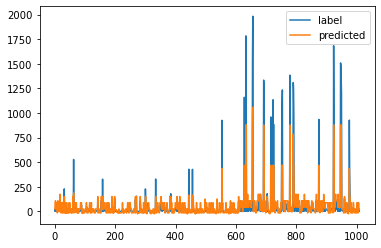

{0: [17836.155588601207, 0.6008985584360704],
 1: [7458.403479935749, 0.6228427048837917],
 2: [12345.054748359065, 0.7132428367267976]}

In [106]:
dataset2 = OptionsDataset('total_df.csv', csv=True, features = features_2)

metrics = {}
for fold in range(3):
    print("Fold", fold)
    train_for_a_fold(cfg, fold, dataset2, extended = True)
    df = test_for_a_fold(cfg, fold, dataset2, extended = True)
    mse = mean_squared_error(df['label'], df['predicted'])
    r2 = r2_score(df['label'], df['predicted'])
    metrics[fold] = [mse, r2]
    df.plot()
    plt.show()

metrics


In [107]:
metrics

{0: [17836.155588601207, 0.6008985584360704],
 1: [7458.403479935749, 0.6228427048837917],
 2: [12345.054748359065, 0.7132428367267976]}

In [112]:
import statistics
print(statistics.mean([metrics[i][0] for i in range(3)]))
print(statistics.mean([metrics[i][1] for i in range(3)]))

12546.53793896534
0.6456613666822199


In [38]:
total_df

,index,mness,ttm,embed_lev,impvol,gamma,vega,theta,strike,delta,...,impvol_additional,gamma_additional,vega_additional,theta_additional,strike_additional,delta_additional,spot_close_additional,divrate_additional,vix_additional,short_rate_additional
0,42,1.857294,28,55.633217,0.169906,0.002070,16.72431,-20.102380,875.0,0.034694,...,0.000000,0.000000,0.00000,0.0000,0.0,0.000000,0.00,0.000000,0.00,0.000000
1,43,0.488979,56,30.652784,0.132271,0.011247,92.88889,-52.013510,685.0,0.355372,...,0.000000,0.000000,0.00000,0.0000,0.0,0.000000,0.00,0.000000,0.00,0.000000
2,44,1.874161,28,70.045687,0.134731,0.003244,13.18954,-12.747660,685.0,0.034270,...,0.000000,0.000000,0.00000,0.0000,0.0,0.000000,0.00,0.000000,0.00,0.000000
3,52,2.210994,119,29.281115,0.166849,0.000412,39.72491,-11.555700,1650.0,0.021907,...,0.000000,0.000000,0.00000,0.0000,0.0,0.000000,0.00,0.000000,0.00,0.000000
4,53,2.612415,91,38.801964,0.162164,0.000187,13.34660,-4.829397,1650.0,0.007264,...,0.000000,0.000000,0.00000,0.0000,0.0,0.000000,0.00,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180809,180803,-0.625458,56,39.826654,0.104692,0.003099,324.23790,-114.568500,2510.0,-0.260592,...,0.104692,0.003099,324.23790,-114.5685,2510.0,-0.260592,2575.21,0.018232,9.97,0.012243
180810,180804,-0.467571,56,40.341208,0.096709,0.003673,354.91720,-116.236200,2530.0,-0.315654,...,0.096709,0.003673,354.91720,-116.2362,2530.0,-0.315654,2575.21,0.018232,9.97,0.012243
180811,180805,0.255425,56,36.660494,0.076517,0.005031,384.66660,-102.074900,2595.0,-0.600756,...,0.076517,0.005031,384.66660,-102.0749,2595.0,-0.600756,2575.21,0.018232,9.97,0.012243
180812,180809,1.308051,28,18.787525,0.125499,0.001887,116.19330,-106.506800,2695.0,-0.906105,...,0.125499,0.001887,116.19330,-106.5068,2695.0,-0.906105,2575.21,0.018232,9.97,0.012243
